<a href="https://colab.research.google.com/github/zongxinc/NLP_project/blob/main/Copy_of_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 325s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd

df = pd.read_excel('/content/gdrive/MyDrive/GVFC_AnnotatedHeadlines.xlsx')

In [6]:
titles = df['news_title']
ImageID = df['ImageID']

In [7]:
len(titles)

1300

In [8]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [9]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [10]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [11]:
len(image_path_to_caption)

82783

In [12]:
for i in range(1000):
  train_image_paths.append('/content/gdrive/MyDrive/all_shooting_images_newest/' + str(ImageID[i]) +'.jpg')
  image_path_to_caption['/content/gdrive/MyDrive/all_shooting_images_newest/' + str(ImageID[i]) +'.jpg'].append(f"<start> {titles[i]} <end>")

In [13]:
train_image_paths[6001]

'/content/gdrive/MyDrive/all_shooting_images_newest/10073.jpg'

In [14]:
train_captions = []
img_name_vector = []
count = 0
for image_path in train_image_paths:

  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [15]:
len(img_name_vector)
# img_name_vector[32014]

31011

<start> Synagogue gunman kills 11 in America's worst anti-Semitic attack <end>


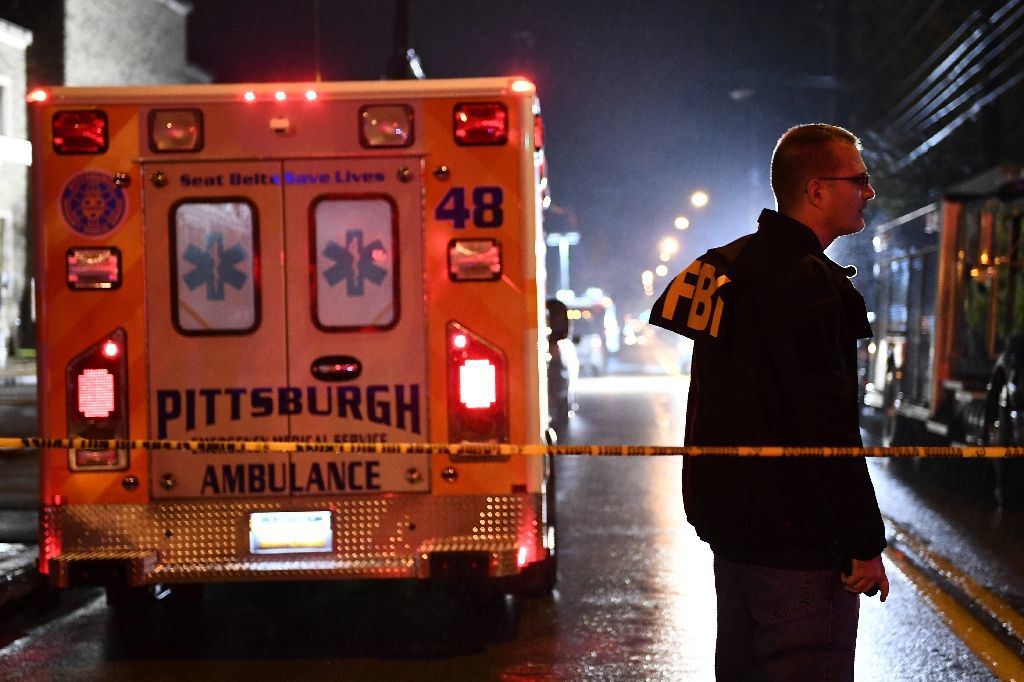

In [17]:
print(train_captions[31010])
Image.open(img_name_vector[31010])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [18]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [19]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [20]:
!pip install tqdm
from tqdm import tqdm

In [21]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    print(path_of_feature)
    np.save(path_of_feature, bf.numpy())

  0%|          | 0/438 [00:00<?, ?it/s]

/content/gdrive/MyDrive/all_shooting_images_newest/1.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100001.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100005.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100007.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10001.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100013.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100014.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100017.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100019.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10002.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100021.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100022.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100024.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100027.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100034.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100035.jpg


  0%|          | 1/438 [00:42<5:08:06, 42.30s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10004.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100042.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100044.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100045.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10005.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100051.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100053.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100059.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10006.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100060.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100063.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100064.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100066.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100069.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10007.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100078.jpg


  0%|          | 2/438 [00:48<3:48:20, 31.42s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100079.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10008.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100080.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100082.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100083.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100084.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100085.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100086.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100087.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100088.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10009.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100090.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100095.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100099.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10010.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100102.jpg


  1%|          | 3/438 [00:54<2:53:20, 23.91s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100103.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100106.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10011.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100116.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100117.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100122.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10013.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100131.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100134.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100135.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100137.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100140.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100145.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100146.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100147.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10015.jpg


  1%|          | 4/438 [01:01<2:15:09, 18.69s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100151.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100152.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100160.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100166.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10017.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100170.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100171.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100173.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100174.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100177.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100178.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10018.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100181.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100186.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100189.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10019.jpg


  1%|          | 5/438 [01:07<1:48:43, 15.07s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100196.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100198.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100203.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100207.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100211.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100213.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100214.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100217.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100219.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10022.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100222.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100223.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100225.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100227.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100229.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10023.jpg


  1%|▏         | 6/438 [01:14<1:29:49, 12.48s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100230.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100231.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100232.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100236.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100240.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100242.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100244.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100245.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100248.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100250.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100251.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100252.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100256.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100258.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10026.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100260.jpg


  2%|▏         | 7/438 [01:20<1:16:37, 10.67s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100264.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100266.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10027.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100270.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100272.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10028.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100284.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100286.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100288.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100293.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100303.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100304.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100306.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100311.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100315.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100316.jpg


  2%|▏         | 8/438 [01:26<1:06:42,  9.31s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100317.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100320.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100321.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100322.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100325.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100329.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100330.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100331.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100333.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100334.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100338.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100339.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100342.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100343.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100345.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10035.jpg


  2%|▏         | 9/438 [01:32<59:21,  8.30s/it]  

/content/gdrive/MyDrive/all_shooting_images_newest/100350.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100354.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100359.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100366.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100368.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10037.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100372.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100373.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100375.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100379.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100380.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100381.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100385.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100387.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100388.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10039.jpg


  2%|▏         | 10/438 [01:39<54:48,  7.68s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100393.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100394.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100397.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100398.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100399.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100400.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100401.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100409.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100416.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100417.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100418.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100420.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100422.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100424.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100427.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100429.jpg


  3%|▎         | 11/438 [01:45<51:46,  7.28s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100435.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100437.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100438.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100439.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10044.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100440.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100441.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100444.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100445.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100446.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100448.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100450.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100451.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100452.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100454.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100456.jpg


  3%|▎         | 12/438 [01:51<49:07,  6.92s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100459.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100460.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100461.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100468.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100469.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10047.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100471.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100478.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100479.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10048.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100480.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100482.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100483.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10049.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100490.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100491.jpg


  3%|▎         | 13/438 [01:57<47:45,  6.74s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/100492.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100493.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100494.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100497.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100500.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/100502.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10053.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10054.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10056.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10057.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10058.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10061.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10062.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10063.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10065.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10066.jpg


  3%|▎         | 14/438 [02:04<46:35,  6.59s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10070.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10073.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10075.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10076.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10078.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10079.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10080.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10081.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10083.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10085.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10087.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10090.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10092.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10093.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10096.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10100.jpg


  3%|▎         | 15/438 [02:10<46:18,  6.57s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10102.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10104.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10106.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10107.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10112.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10113.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10116.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10117.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10118.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10119.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10120.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10122.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10123.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10125.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10126.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10129.jpg


  4%|▎         | 16/438 [02:16<45:24,  6.46s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10131.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10134.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10138.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10139.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10140.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10145.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10148.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10151.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10154.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10155.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10156.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10157.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10158.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10161.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10163.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10165.jpg


  4%|▍         | 17/438 [02:22<44:38,  6.36s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10169.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10170.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10173.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10174.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10175.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10176.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10179.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10181.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10183.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10184.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10186.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10189.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10191.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10197.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/102.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10200.jpg


  4%|▍         | 18/438 [02:29<44:49,  6.40s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10201.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10202.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10203.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10204.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10207.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10209.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10213.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10214.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10215.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10217.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10218.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10219.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10220.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10221.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10222.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10223.jpg


  4%|▍         | 19/438 [02:35<44:56,  6.44s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10224.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10226.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10227.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10229.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10230.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10231.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10233.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10234.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10236.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10237.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10238.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10240.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10245.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10248.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10252.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10253.jpg


  5%|▍         | 20/438 [02:42<44:20,  6.37s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10254.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10255.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10264.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10265.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10267.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10268.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10271.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10277.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10279.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10280.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10282.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10285.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10290.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10294.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10301.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10302.jpg


  5%|▍         | 21/438 [02:48<45:01,  6.48s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10305.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10309.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10310.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10313.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10316.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10318.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10321.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10330.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10331.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10332.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10336.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10338.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10343.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10351.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10352.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10354.jpg


  5%|▌         | 22/438 [02:54<43:54,  6.33s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10356.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10357.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10361.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10364.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10366.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10367.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10368.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10369.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10377.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10379.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10381.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10383.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10385.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10389.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10392.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10394.jpg


  5%|▌         | 23/438 [03:01<44:09,  6.38s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10395.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10396.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10398.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10406.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10409.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10410.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10413.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10415.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10418.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10420.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10423.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10425.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10427.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10428.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10430.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10432.jpg


  5%|▌         | 24/438 [03:07<42:47,  6.20s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10434.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10435.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10445.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10446.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10448.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10450.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10461.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10464.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10466.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10469.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10471.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10474.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10475.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10476.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10477.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10480.jpg


  6%|▌         | 25/438 [03:13<43:04,  6.26s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10482.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10483.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10485.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10496.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10497.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10499.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10502.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10508.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10509.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10513.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10514.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10515.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10518.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10525.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10527.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10528.jpg


  6%|▌         | 26/438 [03:19<43:02,  6.27s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10531.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10533.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10534.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10535.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10538.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10539.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10540.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10541.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10543.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10546.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10549.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10550.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10551.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10552.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10553.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10554.jpg


  6%|▌         | 27/438 [03:25<42:37,  6.22s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10556.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10560.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10561.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10562.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10564.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10572.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10575.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10577.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10578.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10579.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10582.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10583.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10587.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10588.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10589.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10592.jpg


  6%|▋         | 28/438 [03:32<44:12,  6.47s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10593.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10598.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10602.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10603.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10604.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10608.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10610.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10614.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10619.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10622.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10623.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10624.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10625.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10626.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10631.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10635.jpg


  7%|▋         | 29/438 [03:39<43:36,  6.40s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10637.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10639.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10640.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10641.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10642.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10646.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10648.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10650.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10651.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10653.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10654.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10655.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10656.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10657.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10659.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10661.jpg


  7%|▋         | 30/438 [03:45<43:22,  6.38s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10663.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10665.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10669.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10670.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10673.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10677.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10678.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10679.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10681.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10684.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10685.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10687.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10688.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10689.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10690.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10693.jpg


  7%|▋         | 31/438 [03:52<44:50,  6.61s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10697.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10699.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10700.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10704.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10706.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10708.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10714.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10715.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10718.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10720.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10723.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10724.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10725.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10727.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10731.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10734.jpg


  7%|▋         | 32/438 [03:58<43:43,  6.46s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10737.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10740.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10741.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10747.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10757.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10759.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10760.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10764.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10765.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10767.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10769.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10776.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10777.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10779.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10780.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10783.jpg


  8%|▊         | 33/438 [04:04<42:55,  6.36s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10784.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10785.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10787.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10788.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10790.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10793.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10797.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10798.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10802.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10804.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10807.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10809.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10810.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10811.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10813.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10814.jpg


  8%|▊         | 34/438 [04:11<43:36,  6.48s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10821.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10825.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10826.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10827.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10828.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10831.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10834.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10839.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10843.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10844.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10845.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10850.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10852.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10854.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10860.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10861.jpg


  8%|▊         | 35/438 [04:18<43:28,  6.47s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10862.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10867.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10871.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10872.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10873.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10876.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10878.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10882.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10883.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10890.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10891.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10892.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10894.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10897.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10898.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10900.jpg


  8%|▊         | 36/438 [04:24<43:06,  6.43s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/10901.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/10902.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/11.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110007.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110026.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110028.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110042.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110043.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110044.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110045.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110056.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110057.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110065.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110067.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110069.jpg


  8%|▊         | 37/438 [04:31<43:19,  6.48s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/110070.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110078.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110080.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110081.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110088.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110089.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110094.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110099.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110101.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110102.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110103.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110105.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110114.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110115.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110117.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110118.jpg


  9%|▊         | 38/438 [04:37<42:08,  6.32s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/110119.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110123.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110128.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110131.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110132.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110134.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110143.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110145.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110152.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110156.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110160.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110161.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110163.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110172.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110179.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110186.jpg


  9%|▉         | 39/438 [04:43<42:48,  6.44s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/110187.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110191.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110197.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110199.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110208.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110229.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110233.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110235.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110240.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110241.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110244.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110252.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110253.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110254.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110263.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110264.jpg


  9%|▉         | 40/438 [04:50<42:37,  6.43s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/110267.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110270.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110272.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110274.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110276.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110290.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110297.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110306.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110313.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110314.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110327.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110335.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110337.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110339.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110342.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110351.jpg


  9%|▉         | 41/438 [04:58<46:48,  7.08s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/110360.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110361.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110362.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110369.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110370.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110373.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110379.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110383.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110384.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110393.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110396.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110405.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110409.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110411.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110414.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110416.jpg


 10%|▉         | 42/438 [05:05<45:30,  6.89s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/110427.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110433.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110437.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110451.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110453.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110455.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110457.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110460.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110462.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110471.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110476.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110477.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110479.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110481.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110484.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110491.jpg


 10%|▉         | 43/438 [05:11<43:50,  6.66s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/110492.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110494.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110502.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110503.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110504.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110506.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110508.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110510.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110512.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110514.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110515.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110516.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110517.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/110518.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/112.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/113.jpg


 10%|█         | 44/438 [05:17<43:04,  6.56s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/114.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/116.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/12.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/121.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/125.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/126.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/127.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/128.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/13.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/130.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/131.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/132.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/135.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/137.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/140.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/144.jpg


 10%|█         | 45/438 [05:23<42:21,  6.47s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/147.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/149.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/15.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/151.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/155.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/156.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/157.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/16.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/162.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/163.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/164.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/165.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/166.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/169.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/17.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/170.jpg


 11%|█         | 46/438 [05:30<41:44,  6.39s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/171.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/174.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/177.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/18.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/180.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/182.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/183.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/188.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/189.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/19.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/197.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/199.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/2.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/20.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/200.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/201.jpg


 11%|█         | 47/438 [05:36<41:59,  6.44s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/204.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/209.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/21.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/212.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/214.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/219.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/22.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/221.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/222.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/226.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/228.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/229.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/231.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/232.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/233.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/238.jpg


 11%|█         | 48/438 [05:42<41:14,  6.35s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/239.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/240.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/241.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/244.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/245.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/246.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/247.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/248.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/25.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/252.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/259.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/260.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/261.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/262.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/265.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/266.jpg


 11%|█         | 49/438 [05:49<40:58,  6.32s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/27.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/271.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/273.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/274.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/278.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/291.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/292.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/294.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/296.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/299.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/302.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/306.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/307.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/311.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/313.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/314.jpg


 11%|█▏        | 50/438 [05:55<40:50,  6.32s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/315.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/316.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/320.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/322.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/33.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/332.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/334.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/335.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/339.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/340.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/347.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/352.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/354.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/356.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/36.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/364.jpg


 12%|█▏        | 51/438 [06:01<41:21,  6.41s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/37.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/373.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/376.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/38.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/386.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/391.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/394.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/395.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/397.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/398.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/4.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/401.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/405.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/409.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/411.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/412.jpg


 12%|█▏        | 52/438 [06:08<41:03,  6.38s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/417.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/418.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/419.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/42.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/422.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/424.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/426.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/428.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/431.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/434.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/437.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/444.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/449.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/45.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/451.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/453.jpg


 12%|█▏        | 53/438 [06:14<40:33,  6.32s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/455.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/456.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/457.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/459.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/460.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/474.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/475.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/477.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/479.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/480.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/481.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/482.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/485.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/486.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/487.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/488.jpg


 12%|█▏        | 54/438 [06:20<40:30,  6.33s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/494.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/497.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/499.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/50.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/501.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/55.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/6.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/65.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/66.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/69.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/7.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/71.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/73.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/74.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/76.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/77.jpg


 13%|█▎        | 55/438 [06:27<40:23,  6.33s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/78.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/84.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/85.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/86.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/87.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/88.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/9.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90005.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90007.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90014.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90021.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90025.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90026.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90037.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90038.jpg


 13%|█▎        | 56/438 [06:33<39:53,  6.27s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/90043.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90048.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90054.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90059.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90061.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90066.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90074.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90082.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90093.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90106.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90109.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90116.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90118.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90120.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90131.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90135.jpg


 13%|█▎        | 57/438 [06:39<39:29,  6.22s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/90137.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90138.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90147.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90150.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90158.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90160.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90164.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90185.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90190.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90194.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90202.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90206.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90212.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90218.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90220.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90224.jpg


 13%|█▎        | 58/438 [06:45<39:24,  6.22s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/90226.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90227.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90229.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90231.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90237.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90238.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90243.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90244.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90245.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90248.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90251.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90256.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90258.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90259.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90263.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90271.jpg


 13%|█▎        | 59/438 [06:51<38:53,  6.16s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/90277.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90282.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90288.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90292.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90296.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90297.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90301.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90302.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90303.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90304.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90308.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90321.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90325.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90326.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90330.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90335.jpg


 14%|█▎        | 60/438 [06:58<40:02,  6.36s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/90338.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90339.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90343.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90347.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90348.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90350.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90353.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90369.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90370.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90376.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90382.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90384.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90385.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90387.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90398.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90402.jpg


 14%|█▍        | 61/438 [07:04<39:17,  6.25s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/90409.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90416.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90419.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90420.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90422.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90423.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90424.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90427.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90430.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90436.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90437.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90444.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90446.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90451.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90456.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90459.jpg


 14%|█▍        | 62/438 [07:10<38:23,  6.13s/it]

/content/gdrive/MyDrive/all_shooting_images_newest/90461.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90463.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90465.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90478.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90483.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90493.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/90495.jpg
/content/gdrive/MyDrive/all_shooting_images_newest/96.jpg


 15%|█▍        | 64/438 [07:13<23:11,  3.72s/it]

/content/train2014/COCO_train2014_000000000077.jpg
/content/train2014/COCO_train2014_000000000138.jpg
/content/train2014/COCO_train2014_000000000151.jpg
/content/train2014/COCO_train2014_000000000389.jpg
/content/train2014/COCO_train2014_000000000508.jpg
/content/train2014/COCO_train2014_000000000531.jpg
/content/train2014/COCO_train2014_000000000542.jpg
/content/train2014/COCO_train2014_000000000629.jpg
/content/train2014/COCO_train2014_000000000673.jpg
/content/train2014/COCO_train2014_000000000681.jpg
/content/train2014/COCO_train2014_000000000706.jpg
/content/train2014/COCO_train2014_000000000735.jpg
/content/train2014/COCO_train2014_000000000781.jpg
/content/train2014/COCO_train2014_000000000901.jpg
/content/train2014/COCO_train2014_000000000934.jpg
/content/train2014/COCO_train2014_000000000941.jpg
/content/train2014/COCO_train2014_000000001014.jpg
/content/train2014/COCO_train2014_000000001200.jpg
/content/train2014/COCO_train2014_000000001261.jpg
/content/train2014/COCO_train20

 15%|█▍        | 65/438 [07:13<16:32,  2.66s/it]

/content/train2014/COCO_train2014_000000001688.jpg
/content/train2014/COCO_train2014_000000001777.jpg
/content/train2014/COCO_train2014_000000001804.jpg
/content/train2014/COCO_train2014_000000001926.jpg
/content/train2014/COCO_train2014_000000001966.jpg
/content/train2014/COCO_train2014_000000001999.jpg
/content/train2014/COCO_train2014_000000002197.jpg
/content/train2014/COCO_train2014_000000002217.jpg
/content/train2014/COCO_train2014_000000002278.jpg
/content/train2014/COCO_train2014_000000002402.jpg
/content/train2014/COCO_train2014_000000002754.jpg
/content/train2014/COCO_train2014_000000002774.jpg
/content/train2014/COCO_train2014_000000003077.jpg
/content/train2014/COCO_train2014_000000003225.jpg
/content/train2014/COCO_train2014_000000003366.jpg
/content/train2014/COCO_train2014_000000003493.jpg
/content/train2014/COCO_train2014_000000003692.jpg
/content/train2014/COCO_train2014_000000003860.jpg
/content/train2014/COCO_train2014_000000003995.jpg
/content/train2014/COCO_train20

 15%|█▌        | 67/438 [07:14<08:36,  1.39s/it]

/content/train2014/COCO_train2014_000000005435.jpg
/content/train2014/COCO_train2014_000000005574.jpg
/content/train2014/COCO_train2014_000000005614.jpg
/content/train2014/COCO_train2014_000000005947.jpg
/content/train2014/COCO_train2014_000000005994.jpg
/content/train2014/COCO_train2014_000000006051.jpg
/content/train2014/COCO_train2014_000000006120.jpg
/content/train2014/COCO_train2014_000000006140.jpg
/content/train2014/COCO_train2014_000000006197.jpg
/content/train2014/COCO_train2014_000000006414.jpg
/content/train2014/COCO_train2014_000000006464.jpg
/content/train2014/COCO_train2014_000000006517.jpg
/content/train2014/COCO_train2014_000000006590.jpg
/content/train2014/COCO_train2014_000000006873.jpg
/content/train2014/COCO_train2014_000000007139.jpg
/content/train2014/COCO_train2014_000000007224.jpg
/content/train2014/COCO_train2014_000000007420.jpg
/content/train2014/COCO_train2014_000000007424.jpg
/content/train2014/COCO_train2014_000000007500.jpg


 16%|█▌        | 69/438 [07:14<04:42,  1.30it/s]

/content/train2014/COCO_train2014_000000007596.jpg
/content/train2014/COCO_train2014_000000007623.jpg
/content/train2014/COCO_train2014_000000007685.jpg
/content/train2014/COCO_train2014_000000007827.jpg
/content/train2014/COCO_train2014_000000007830.jpg
/content/train2014/COCO_train2014_000000007838.jpg
/content/train2014/COCO_train2014_000000007945.jpg
/content/train2014/COCO_train2014_000000008093.jpg
/content/train2014/COCO_train2014_000000008285.jpg
/content/train2014/COCO_train2014_000000008332.jpg
/content/train2014/COCO_train2014_000000008436.jpg
/content/train2014/COCO_train2014_000000008519.jpg
/content/train2014/COCO_train2014_000000008571.jpg
/content/train2014/COCO_train2014_000000008677.jpg
/content/train2014/COCO_train2014_000000008791.jpg
/content/train2014/COCO_train2014_000000009045.jpg
/content/train2014/COCO_train2014_000000009060.jpg
/content/train2014/COCO_train2014_000000009133.jpg
/content/train2014/COCO_train2014_000000009253.jpg
/content/train2014/COCO_train20

 16%|█▌        | 71/438 [07:14<02:50,  2.16it/s]

/content/train2014/COCO_train2014_000000010735.jpg
/content/train2014/COCO_train2014_000000010871.jpg
/content/train2014/COCO_train2014_000000011052.jpg
/content/train2014/COCO_train2014_000000011077.jpg
/content/train2014/COCO_train2014_000000011080.jpg
/content/train2014/COCO_train2014_000000011258.jpg
/content/train2014/COCO_train2014_000000011282.jpg
/content/train2014/COCO_train2014_000000011361.jpg
/content/train2014/COCO_train2014_000000011420.jpg
/content/train2014/COCO_train2014_000000011508.jpg
/content/train2014/COCO_train2014_000000011774.jpg
/content/train2014/COCO_train2014_000000011856.jpg
/content/train2014/COCO_train2014_000000011953.jpg
/content/train2014/COCO_train2014_000000012109.jpg
/content/train2014/COCO_train2014_000000012138.jpg
/content/train2014/COCO_train2014_000000012501.jpg
/content/train2014/COCO_train2014_000000012673.jpg
/content/train2014/COCO_train2014_000000012790.jpg
/content/train2014/COCO_train2014_000000012803.jpg
/content/train2014/COCO_train20

 17%|█▋        | 73/438 [07:15<01:53,  3.21it/s]

/content/train2014/COCO_train2014_000000013576.jpg
/content/train2014/COCO_train2014_000000013893.jpg
/content/train2014/COCO_train2014_000000013912.jpg
/content/train2014/COCO_train2014_000000013938.jpg
/content/train2014/COCO_train2014_000000013986.jpg
/content/train2014/COCO_train2014_000000014103.jpg
/content/train2014/COCO_train2014_000000014230.jpg
/content/train2014/COCO_train2014_000000014307.jpg
/content/train2014/COCO_train2014_000000014329.jpg
/content/train2014/COCO_train2014_000000014396.jpg
/content/train2014/COCO_train2014_000000014575.jpg
/content/train2014/COCO_train2014_000000014653.jpg
/content/train2014/COCO_train2014_000000014662.jpg
/content/train2014/COCO_train2014_000000014686.jpg
/content/train2014/COCO_train2014_000000014748.jpg
/content/train2014/COCO_train2014_000000014849.jpg
/content/train2014/COCO_train2014_000000014854.jpg
/content/train2014/COCO_train2014_000000014886.jpg
/content/train2014/COCO_train2014_000000014954.jpg
/content/train2014/COCO_train20

 17%|█▋        | 74/438 [07:15<01:37,  3.75it/s]

/content/train2014/COCO_train2014_000000016538.jpg
/content/train2014/COCO_train2014_000000016796.jpg
/content/train2014/COCO_train2014_000000016837.jpg
/content/train2014/COCO_train2014_000000017226.jpg
/content/train2014/COCO_train2014_000000017399.jpg
/content/train2014/COCO_train2014_000000017474.jpg
/content/train2014/COCO_train2014_000000017570.jpg
/content/train2014/COCO_train2014_000000017585.jpg
/content/train2014/COCO_train2014_000000017751.jpg
/content/train2014/COCO_train2014_000000017962.jpg
/content/train2014/COCO_train2014_000000018155.jpg
/content/train2014/COCO_train2014_000000018157.jpg
/content/train2014/COCO_train2014_000000018293.jpg
/content/train2014/COCO_train2014_000000018316.jpg
/content/train2014/COCO_train2014_000000018317.jpg
/content/train2014/COCO_train2014_000000018414.jpg


 17%|█▋        | 75/438 [07:15<01:35,  3.80it/s]

/content/train2014/COCO_train2014_000000018658.jpg
/content/train2014/COCO_train2014_000000018775.jpg
/content/train2014/COCO_train2014_000000018952.jpg
/content/train2014/COCO_train2014_000000019013.jpg
/content/train2014/COCO_train2014_000000019413.jpg
/content/train2014/COCO_train2014_000000019431.jpg
/content/train2014/COCO_train2014_000000019552.jpg
/content/train2014/COCO_train2014_000000019581.jpg
/content/train2014/COCO_train2014_000000019739.jpg
/content/train2014/COCO_train2014_000000019938.jpg
/content/train2014/COCO_train2014_000000019987.jpg
/content/train2014/COCO_train2014_000000020012.jpg
/content/train2014/COCO_train2014_000000020106.jpg
/content/train2014/COCO_train2014_000000020119.jpg
/content/train2014/COCO_train2014_000000020146.jpg
/content/train2014/COCO_train2014_000000020311.jpg
/content/train2014/COCO_train2014_000000020376.jpg
/content/train2014/COCO_train2014_000000020417.jpg
/content/train2014/COCO_train2014_000000020556.jpg
/content/train2014/COCO_train20

 18%|█▊        | 77/438 [07:15<01:20,  4.51it/s]

/content/train2014/COCO_train2014_000000021531.jpg
/content/train2014/COCO_train2014_000000021535.jpg
/content/train2014/COCO_train2014_000000021544.jpg
/content/train2014/COCO_train2014_000000021622.jpg
/content/train2014/COCO_train2014_000000021796.jpg
/content/train2014/COCO_train2014_000000021972.jpg
/content/train2014/COCO_train2014_000000022032.jpg
/content/train2014/COCO_train2014_000000022195.jpg
/content/train2014/COCO_train2014_000000022226.jpg
/content/train2014/COCO_train2014_000000022281.jpg
/content/train2014/COCO_train2014_000000022298.jpg
/content/train2014/COCO_train2014_000000022355.jpg
/content/train2014/COCO_train2014_000000022374.jpg
/content/train2014/COCO_train2014_000000022377.jpg
/content/train2014/COCO_train2014_000000022478.jpg
/content/train2014/COCO_train2014_000000022536.jpg
/content/train2014/COCO_train2014_000000022545.jpg
/content/train2014/COCO_train2014_000000022636.jpg
/content/train2014/COCO_train2014_000000022696.jpg
/content/train2014/COCO_train20

 18%|█▊        | 79/438 [07:16<01:08,  5.25it/s]

/content/train2014/COCO_train2014_000000022879.jpg
/content/train2014/COCO_train2014_000000022962.jpg
/content/train2014/COCO_train2014_000000022964.jpg
/content/train2014/COCO_train2014_000000023014.jpg
/content/train2014/COCO_train2014_000000023098.jpg
/content/train2014/COCO_train2014_000000023162.jpg
/content/train2014/COCO_train2014_000000023245.jpg
/content/train2014/COCO_train2014_000000023405.jpg
/content/train2014/COCO_train2014_000000023450.jpg
/content/train2014/COCO_train2014_000000023480.jpg
/content/train2014/COCO_train2014_000000023487.jpg
/content/train2014/COCO_train2014_000000023548.jpg
/content/train2014/COCO_train2014_000000023676.jpg
/content/train2014/COCO_train2014_000000023735.jpg
/content/train2014/COCO_train2014_000000023786.jpg
/content/train2014/COCO_train2014_000000023803.jpg
/content/train2014/COCO_train2014_000000024073.jpg
/content/train2014/COCO_train2014_000000024305.jpg
/content/train2014/COCO_train2014_000000024585.jpg
/content/train2014/COCO_train20

 18%|█▊        | 81/438 [07:16<01:02,  5.72it/s]

/content/train2014/COCO_train2014_000000026072.jpg
/content/train2014/COCO_train2014_000000026297.jpg
/content/train2014/COCO_train2014_000000026367.jpg
/content/train2014/COCO_train2014_000000026405.jpg
/content/train2014/COCO_train2014_000000026425.jpg
/content/train2014/COCO_train2014_000000026551.jpg
/content/train2014/COCO_train2014_000000026602.jpg
/content/train2014/COCO_train2014_000000026775.jpg
/content/train2014/COCO_train2014_000000026958.jpg
/content/train2014/COCO_train2014_000000027015.jpg
/content/train2014/COCO_train2014_000000027030.jpg
/content/train2014/COCO_train2014_000000027037.jpg
/content/train2014/COCO_train2014_000000027149.jpg
/content/train2014/COCO_train2014_000000027370.jpg
/content/train2014/COCO_train2014_000000027406.jpg
/content/train2014/COCO_train2014_000000027665.jpg
/content/train2014/COCO_train2014_000000027792.jpg
/content/train2014/COCO_train2014_000000027883.jpg
/content/train2014/COCO_train2014_000000027921.jpg
/content/train2014/COCO_train20

 19%|█▉        | 83/438 [07:16<01:01,  5.79it/s]

/content/train2014/COCO_train2014_000000029226.jpg
/content/train2014/COCO_train2014_000000029288.jpg
/content/train2014/COCO_train2014_000000029403.jpg
/content/train2014/COCO_train2014_000000029432.jpg
/content/train2014/COCO_train2014_000000029622.jpg
/content/train2014/COCO_train2014_000000029751.jpg
/content/train2014/COCO_train2014_000000029755.jpg
/content/train2014/COCO_train2014_000000029821.jpg
/content/train2014/COCO_train2014_000000029853.jpg
/content/train2014/COCO_train2014_000000029914.jpg
/content/train2014/COCO_train2014_000000030055.jpg
/content/train2014/COCO_train2014_000000030114.jpg
/content/train2014/COCO_train2014_000000030247.jpg
/content/train2014/COCO_train2014_000000030289.jpg
/content/train2014/COCO_train2014_000000030340.jpg
/content/train2014/COCO_train2014_000000030355.jpg
/content/train2014/COCO_train2014_000000030357.jpg
/content/train2014/COCO_train2014_000000030371.jpg
/content/train2014/COCO_train2014_000000030449.jpg
/content/train2014/COCO_train20

 19%|█▉        | 85/438 [07:17<00:58,  6.06it/s]

/content/train2014/COCO_train2014_000000031979.jpg
/content/train2014/COCO_train2014_000000032074.jpg
/content/train2014/COCO_train2014_000000032231.jpg
/content/train2014/COCO_train2014_000000032442.jpg
/content/train2014/COCO_train2014_000000032468.jpg
/content/train2014/COCO_train2014_000000032566.jpg
/content/train2014/COCO_train2014_000000032787.jpg
/content/train2014/COCO_train2014_000000033047.jpg
/content/train2014/COCO_train2014_000000033127.jpg
/content/train2014/COCO_train2014_000000033186.jpg
/content/train2014/COCO_train2014_000000033305.jpg
/content/train2014/COCO_train2014_000000033596.jpg
/content/train2014/COCO_train2014_000000033634.jpg
/content/train2014/COCO_train2014_000000033764.jpg
/content/train2014/COCO_train2014_000000033874.jpg
/content/train2014/COCO_train2014_000000033901.jpg
/content/train2014/COCO_train2014_000000033902.jpg
/content/train2014/COCO_train2014_000000033917.jpg
/content/train2014/COCO_train2014_000000033995.jpg
/content/train2014/COCO_train20

 20%|█▉        | 87/438 [07:17<00:58,  6.04it/s]

/content/train2014/COCO_train2014_000000035367.jpg
/content/train2014/COCO_train2014_000000035424.jpg
/content/train2014/COCO_train2014_000000035446.jpg
/content/train2014/COCO_train2014_000000035551.jpg
/content/train2014/COCO_train2014_000000035793.jpg
/content/train2014/COCO_train2014_000000035916.jpg
/content/train2014/COCO_train2014_000000035927.jpg
/content/train2014/COCO_train2014_000000035964.jpg
/content/train2014/COCO_train2014_000000035985.jpg
/content/train2014/COCO_train2014_000000036652.jpg
/content/train2014/COCO_train2014_000000036957.jpg
/content/train2014/COCO_train2014_000000037011.jpg
/content/train2014/COCO_train2014_000000037091.jpg
/content/train2014/COCO_train2014_000000037102.jpg
/content/train2014/COCO_train2014_000000037140.jpg
/content/train2014/COCO_train2014_000000037183.jpg
/content/train2014/COCO_train2014_000000037198.jpg
/content/train2014/COCO_train2014_000000037377.jpg
/content/train2014/COCO_train2014_000000037433.jpg
/content/train2014/COCO_train20

 20%|██        | 89/438 [07:17<01:02,  5.56it/s]

/content/train2014/COCO_train2014_000000038417.jpg
/content/train2014/COCO_train2014_000000038474.jpg
/content/train2014/COCO_train2014_000000038628.jpg
/content/train2014/COCO_train2014_000000038752.jpg
/content/train2014/COCO_train2014_000000038798.jpg
/content/train2014/COCO_train2014_000000038838.jpg
/content/train2014/COCO_train2014_000000038955.jpg
/content/train2014/COCO_train2014_000000039022.jpg
/content/train2014/COCO_train2014_000000039171.jpg
/content/train2014/COCO_train2014_000000039276.jpg
/content/train2014/COCO_train2014_000000039301.jpg
/content/train2014/COCO_train2014_000000039438.jpg
/content/train2014/COCO_train2014_000000039447.jpg
/content/train2014/COCO_train2014_000000039455.jpg
/content/train2014/COCO_train2014_000000039497.jpg
/content/train2014/COCO_train2014_000000039527.jpg
/content/train2014/COCO_train2014_000000039556.jpg
/content/train2014/COCO_train2014_000000039884.jpg
/content/train2014/COCO_train2014_000000039958.jpg
/content/train2014/COCO_train20

 21%|██        | 90/438 [07:18<01:43,  3.37it/s]

/content/train2014/COCO_train2014_000000041135.jpg
/content/train2014/COCO_train2014_000000041138.jpg
/content/train2014/COCO_train2014_000000041152.jpg
/content/train2014/COCO_train2014_000000041155.jpg
/content/train2014/COCO_train2014_000000041377.jpg
/content/train2014/COCO_train2014_000000041404.jpg
/content/train2014/COCO_train2014_000000041565.jpg
/content/train2014/COCO_train2014_000000041588.jpg
/content/train2014/COCO_train2014_000000041616.jpg
/content/train2014/COCO_train2014_000000041729.jpg
/content/train2014/COCO_train2014_000000041753.jpg
/content/train2014/COCO_train2014_000000041763.jpg
/content/train2014/COCO_train2014_000000042339.jpg
/content/train2014/COCO_train2014_000000042849.jpg
/content/train2014/COCO_train2014_000000042972.jpg
/content/train2014/COCO_train2014_000000043161.jpg
/content/train2014/COCO_train2014_000000043190.jpg
/content/train2014/COCO_train2014_000000043203.jpg


 21%|██        | 92/438 [07:18<01:19,  4.34it/s]

/content/train2014/COCO_train2014_000000043220.jpg
/content/train2014/COCO_train2014_000000043367.jpg
/content/train2014/COCO_train2014_000000043371.jpg
/content/train2014/COCO_train2014_000000043510.jpg
/content/train2014/COCO_train2014_000000043576.jpg
/content/train2014/COCO_train2014_000000043806.jpg
/content/train2014/COCO_train2014_000000044267.jpg
/content/train2014/COCO_train2014_000000044332.jpg
/content/train2014/COCO_train2014_000000044432.jpg
/content/train2014/COCO_train2014_000000044943.jpg
/content/train2014/COCO_train2014_000000044946.jpg
/content/train2014/COCO_train2014_000000044954.jpg
/content/train2014/COCO_train2014_000000044958.jpg
/content/train2014/COCO_train2014_000000044962.jpg
/content/train2014/COCO_train2014_000000045071.jpg
/content/train2014/COCO_train2014_000000045422.jpg
/content/train2014/COCO_train2014_000000045526.jpg
/content/train2014/COCO_train2014_000000045528.jpg
/content/train2014/COCO_train2014_000000045552.jpg
/content/train2014/COCO_train20

 21%|██▏       | 94/438 [07:19<01:06,  5.21it/s]

/content/train2014/COCO_train2014_000000046189.jpg
/content/train2014/COCO_train2014_000000046223.jpg
/content/train2014/COCO_train2014_000000046242.jpg
/content/train2014/COCO_train2014_000000046260.jpg
/content/train2014/COCO_train2014_000000046303.jpg
/content/train2014/COCO_train2014_000000046545.jpg
/content/train2014/COCO_train2014_000000046978.jpg
/content/train2014/COCO_train2014_000000047074.jpg
/content/train2014/COCO_train2014_000000047125.jpg
/content/train2014/COCO_train2014_000000047249.jpg
/content/train2014/COCO_train2014_000000047391.jpg
/content/train2014/COCO_train2014_000000047405.jpg
/content/train2014/COCO_train2014_000000047406.jpg
/content/train2014/COCO_train2014_000000047617.jpg
/content/train2014/COCO_train2014_000000047619.jpg
/content/train2014/COCO_train2014_000000047629.jpg
/content/train2014/COCO_train2014_000000047639.jpg
/content/train2014/COCO_train2014_000000047640.jpg
/content/train2014/COCO_train2014_000000047867.jpg
/content/train2014/COCO_train20

 22%|██▏       | 95/438 [07:19<01:03,  5.41it/s]

/content/train2014/COCO_train2014_000000049275.jpg
/content/train2014/COCO_train2014_000000049331.jpg
/content/train2014/COCO_train2014_000000049348.jpg
/content/train2014/COCO_train2014_000000049369.jpg
/content/train2014/COCO_train2014_000000049402.jpg
/content/train2014/COCO_train2014_000000049782.jpg
/content/train2014/COCO_train2014_000000049845.jpg
/content/train2014/COCO_train2014_000000049902.jpg
/content/train2014/COCO_train2014_000000050134.jpg
/content/train2014/COCO_train2014_000000050151.jpg
/content/train2014/COCO_train2014_000000050206.jpg
/content/train2014/COCO_train2014_000000050404.jpg
/content/train2014/COCO_train2014_000000050409.jpg
/content/train2014/COCO_train2014_000000050462.jpg
/content/train2014/COCO_train2014_000000050463.jpg
/content/train2014/COCO_train2014_000000050583.jpg
/content/train2014/COCO_train2014_000000050760.jpg
/content/train2014/COCO_train2014_000000050771.jpg
/content/train2014/COCO_train2014_000000050948.jpg
/content/train2014/COCO_train20

 22%|██▏       | 97/438 [07:19<00:59,  5.72it/s]

/content/train2014/COCO_train2014_000000051720.jpg
/content/train2014/COCO_train2014_000000051835.jpg
/content/train2014/COCO_train2014_000000052038.jpg
/content/train2014/COCO_train2014_000000052131.jpg
/content/train2014/COCO_train2014_000000052151.jpg
/content/train2014/COCO_train2014_000000052153.jpg
/content/train2014/COCO_train2014_000000052490.jpg
/content/train2014/COCO_train2014_000000052516.jpg
/content/train2014/COCO_train2014_000000052606.jpg
/content/train2014/COCO_train2014_000000052631.jpg
/content/train2014/COCO_train2014_000000052686.jpg
/content/train2014/COCO_train2014_000000052818.jpg
/content/train2014/COCO_train2014_000000052847.jpg
/content/train2014/COCO_train2014_000000052938.jpg
/content/train2014/COCO_train2014_000000052943.jpg
/content/train2014/COCO_train2014_000000052951.jpg
/content/train2014/COCO_train2014_000000053091.jpg
/content/train2014/COCO_train2014_000000053111.jpg
/content/train2014/COCO_train2014_000000053169.jpg
/content/train2014/COCO_train20

 23%|██▎       | 99/438 [07:20<00:56,  5.96it/s]

/content/train2014/COCO_train2014_000000053304.jpg
/content/train2014/COCO_train2014_000000053330.jpg
/content/train2014/COCO_train2014_000000053589.jpg
/content/train2014/COCO_train2014_000000053875.jpg
/content/train2014/COCO_train2014_000000054001.jpg
/content/train2014/COCO_train2014_000000054141.jpg
/content/train2014/COCO_train2014_000000054254.jpg
/content/train2014/COCO_train2014_000000054260.jpg
/content/train2014/COCO_train2014_000000054286.jpg
/content/train2014/COCO_train2014_000000054510.jpg
/content/train2014/COCO_train2014_000000054692.jpg
/content/train2014/COCO_train2014_000000054717.jpg
/content/train2014/COCO_train2014_000000055033.jpg
/content/train2014/COCO_train2014_000000055206.jpg
/content/train2014/COCO_train2014_000000055389.jpg
/content/train2014/COCO_train2014_000000055413.jpg
/content/train2014/COCO_train2014_000000055434.jpg
/content/train2014/COCO_train2014_000000055465.jpg
/content/train2014/COCO_train2014_000000055630.jpg
/content/train2014/COCO_train20

 23%|██▎       | 101/438 [07:20<00:55,  6.12it/s]

/content/train2014/COCO_train2014_000000057185.jpg
/content/train2014/COCO_train2014_000000057395.jpg
/content/train2014/COCO_train2014_000000057427.jpg
/content/train2014/COCO_train2014_000000057445.jpg
/content/train2014/COCO_train2014_000000057515.jpg
/content/train2014/COCO_train2014_000000057796.jpg
/content/train2014/COCO_train2014_000000057801.jpg
/content/train2014/COCO_train2014_000000057859.jpg
/content/train2014/COCO_train2014_000000057864.jpg
/content/train2014/COCO_train2014_000000058035.jpg
/content/train2014/COCO_train2014_000000058041.jpg
/content/train2014/COCO_train2014_000000058143.jpg
/content/train2014/COCO_train2014_000000058172.jpg
/content/train2014/COCO_train2014_000000058250.jpg
/content/train2014/COCO_train2014_000000058435.jpg
/content/train2014/COCO_train2014_000000058443.jpg
/content/train2014/COCO_train2014_000000058524.jpg
/content/train2014/COCO_train2014_000000058654.jpg
/content/train2014/COCO_train2014_000000059012.jpg
/content/train2014/COCO_train20

 23%|██▎       | 102/438 [07:20<01:01,  5.45it/s]

/content/train2014/COCO_train2014_000000059971.jpg
/content/train2014/COCO_train2014_000000060041.jpg
/content/train2014/COCO_train2014_000000060196.jpg
/content/train2014/COCO_train2014_000000060269.jpg
/content/train2014/COCO_train2014_000000060297.jpg
/content/train2014/COCO_train2014_000000060394.jpg
/content/train2014/COCO_train2014_000000060415.jpg
/content/train2014/COCO_train2014_000000060437.jpg
/content/train2014/COCO_train2014_000000060472.jpg
/content/train2014/COCO_train2014_000000060482.jpg
/content/train2014/COCO_train2014_000000060513.jpg
/content/train2014/COCO_train2014_000000060624.jpg
/content/train2014/COCO_train2014_000000060737.jpg
/content/train2014/COCO_train2014_000000060774.jpg
/content/train2014/COCO_train2014_000000060814.jpg
/content/train2014/COCO_train2014_000000060868.jpg
/content/train2014/COCO_train2014_000000061084.jpg
/content/train2014/COCO_train2014_000000061403.jpg
/content/train2014/COCO_train2014_000000061674.jpg
/content/train2014/COCO_train20

 24%|██▎       | 104/438 [07:20<00:58,  5.70it/s]

/content/train2014/COCO_train2014_000000062337.jpg
/content/train2014/COCO_train2014_000000062426.jpg
/content/train2014/COCO_train2014_000000062427.jpg
/content/train2014/COCO_train2014_000000062455.jpg
/content/train2014/COCO_train2014_000000062464.jpg
/content/train2014/COCO_train2014_000000062481.jpg
/content/train2014/COCO_train2014_000000062648.jpg
/content/train2014/COCO_train2014_000000062770.jpg
/content/train2014/COCO_train2014_000000062896.jpg
/content/train2014/COCO_train2014_000000063140.jpg
/content/train2014/COCO_train2014_000000063163.jpg
/content/train2014/COCO_train2014_000000063182.jpg
/content/train2014/COCO_train2014_000000063206.jpg
/content/train2014/COCO_train2014_000000063209.jpg
/content/train2014/COCO_train2014_000000063247.jpg
/content/train2014/COCO_train2014_000000063345.jpg
/content/train2014/COCO_train2014_000000063495.jpg
/content/train2014/COCO_train2014_000000063865.jpg
/content/train2014/COCO_train2014_000000063894.jpg
/content/train2014/COCO_train20

 24%|██▍       | 105/438 [07:21<00:58,  5.66it/s]

/content/train2014/COCO_train2014_000000064890.jpg
/content/train2014/COCO_train2014_000000065016.jpg
/content/train2014/COCO_train2014_000000065028.jpg
/content/train2014/COCO_train2014_000000065161.jpg
/content/train2014/COCO_train2014_000000065209.jpg
/content/train2014/COCO_train2014_000000065420.jpg
/content/train2014/COCO_train2014_000000065426.jpg
/content/train2014/COCO_train2014_000000065500.jpg
/content/train2014/COCO_train2014_000000065516.jpg
/content/train2014/COCO_train2014_000000065518.jpg
/content/train2014/COCO_train2014_000000065584.jpg
/content/train2014/COCO_train2014_000000065712.jpg
/content/train2014/COCO_train2014_000000065816.jpg
/content/train2014/COCO_train2014_000000065835.jpg
/content/train2014/COCO_train2014_000000065869.jpg
/content/train2014/COCO_train2014_000000065896.jpg
/content/train2014/COCO_train2014_000000065900.jpg
/content/train2014/COCO_train2014_000000065968.jpg
/content/train2014/COCO_train2014_000000066014.jpg
/content/train2014/COCO_train20

 24%|██▍       | 107/438 [07:21<00:58,  5.66it/s]

/content/train2014/COCO_train2014_000000066301.jpg
/content/train2014/COCO_train2014_000000066514.jpg
/content/train2014/COCO_train2014_000000066667.jpg
/content/train2014/COCO_train2014_000000066727.jpg
/content/train2014/COCO_train2014_000000066754.jpg
/content/train2014/COCO_train2014_000000066828.jpg
/content/train2014/COCO_train2014_000000066839.jpg
/content/train2014/COCO_train2014_000000067046.jpg
/content/train2014/COCO_train2014_000000067082.jpg
/content/train2014/COCO_train2014_000000067115.jpg
/content/train2014/COCO_train2014_000000067256.jpg
/content/train2014/COCO_train2014_000000067344.jpg
/content/train2014/COCO_train2014_000000067405.jpg
/content/train2014/COCO_train2014_000000067440.jpg
/content/train2014/COCO_train2014_000000067566.jpg
/content/train2014/COCO_train2014_000000067571.jpg
/content/train2014/COCO_train2014_000000067680.jpg
/content/train2014/COCO_train2014_000000067807.jpg
/content/train2014/COCO_train2014_000000068047.jpg
/content/train2014/COCO_train20

 25%|██▍       | 109/438 [07:21<00:57,  5.67it/s]

/content/train2014/COCO_train2014_000000068996.jpg
/content/train2014/COCO_train2014_000000069018.jpg
/content/train2014/COCO_train2014_000000069029.jpg
/content/train2014/COCO_train2014_000000069148.jpg
/content/train2014/COCO_train2014_000000069344.jpg
/content/train2014/COCO_train2014_000000069346.jpg
/content/train2014/COCO_train2014_000000069350.jpg
/content/train2014/COCO_train2014_000000069355.jpg
/content/train2014/COCO_train2014_000000069401.jpg
/content/train2014/COCO_train2014_000000069440.jpg
/content/train2014/COCO_train2014_000000069500.jpg
/content/train2014/COCO_train2014_000000069526.jpg
/content/train2014/COCO_train2014_000000069616.jpg
/content/train2014/COCO_train2014_000000069729.jpg
/content/train2014/COCO_train2014_000000069934.jpg
/content/train2014/COCO_train2014_000000069983.jpg
/content/train2014/COCO_train2014_000000070062.jpg
/content/train2014/COCO_train2014_000000070104.jpg
/content/train2014/COCO_train2014_000000070230.jpg
/content/train2014/COCO_train20

 25%|██▌       | 111/438 [07:22<00:54,  5.96it/s]

/content/train2014/COCO_train2014_000000071608.jpg
/content/train2014/COCO_train2014_000000071657.jpg
/content/train2014/COCO_train2014_000000071726.jpg
/content/train2014/COCO_train2014_000000071796.jpg
/content/train2014/COCO_train2014_000000071845.jpg
/content/train2014/COCO_train2014_000000071870.jpg
/content/train2014/COCO_train2014_000000072177.jpg
/content/train2014/COCO_train2014_000000072222.jpg
/content/train2014/COCO_train2014_000000072282.jpg
/content/train2014/COCO_train2014_000000072509.jpg
/content/train2014/COCO_train2014_000000072517.jpg
/content/train2014/COCO_train2014_000000072535.jpg
/content/train2014/COCO_train2014_000000072573.jpg
/content/train2014/COCO_train2014_000000072717.jpg
/content/train2014/COCO_train2014_000000072895.jpg
/content/train2014/COCO_train2014_000000073109.jpg
/content/train2014/COCO_train2014_000000073413.jpg
/content/train2014/COCO_train2014_000000073496.jpg
/content/train2014/COCO_train2014_000000073647.jpg
/content/train2014/COCO_train20

 26%|██▌       | 112/438 [07:22<00:53,  6.05it/s]

/content/train2014/COCO_train2014_000000074217.jpg
/content/train2014/COCO_train2014_000000074232.jpg
/content/train2014/COCO_train2014_000000074336.jpg
/content/train2014/COCO_train2014_000000074348.jpg
/content/train2014/COCO_train2014_000000074364.jpg
/content/train2014/COCO_train2014_000000074398.jpg
/content/train2014/COCO_train2014_000000074403.jpg
/content/train2014/COCO_train2014_000000074517.jpg
/content/train2014/COCO_train2014_000000074820.jpg
/content/train2014/COCO_train2014_000000074828.jpg
/content/train2014/COCO_train2014_000000074894.jpg
/content/train2014/COCO_train2014_000000075132.jpg
/content/train2014/COCO_train2014_000000075213.jpg
/content/train2014/COCO_train2014_000000075326.jpg
/content/train2014/COCO_train2014_000000075331.jpg
/content/train2014/COCO_train2014_000000075423.jpg
/content/train2014/COCO_train2014_000000075466.jpg
/content/train2014/COCO_train2014_000000075477.jpg
/content/train2014/COCO_train2014_000000075496.jpg
/content/train2014/COCO_train20

 26%|██▌       | 113/438 [07:22<00:54,  5.99it/s]


/content/train2014/COCO_train2014_000000076912.jpg
/content/train2014/COCO_train2014_000000077003.jpg
/content/train2014/COCO_train2014_000000077095.jpg
/content/train2014/COCO_train2014_000000077099.jpg
/content/train2014/COCO_train2014_000000077154.jpg
/content/train2014/COCO_train2014_000000077444.jpg
/content/train2014/COCO_train2014_000000077550.jpg
/content/train2014/COCO_train2014_000000077563.jpg
/content/train2014/COCO_train2014_000000077806.jpg
/content/train2014/COCO_train2014_000000077901.jpg
/content/train2014/COCO_train2014_000000078169.jpg
/content/train2014/COCO_train2014_000000078253.jpg


 26%|██▌       | 114/438 [07:22<00:58,  5.49it/s]

/content/train2014/COCO_train2014_000000078468.jpg
/content/train2014/COCO_train2014_000000078781.jpg
/content/train2014/COCO_train2014_000000078880.jpg
/content/train2014/COCO_train2014_000000079090.jpg
/content/train2014/COCO_train2014_000000079196.jpg
/content/train2014/COCO_train2014_000000079230.jpg
/content/train2014/COCO_train2014_000000079313.jpg
/content/train2014/COCO_train2014_000000079528.jpg
/content/train2014/COCO_train2014_000000079641.jpg
/content/train2014/COCO_train2014_000000079831.jpg
/content/train2014/COCO_train2014_000000080208.jpg
/content/train2014/COCO_train2014_000000080408.jpg
/content/train2014/COCO_train2014_000000080480.jpg
/content/train2014/COCO_train2014_000000080686.jpg
/content/train2014/COCO_train2014_000000080789.jpg
/content/train2014/COCO_train2014_000000080798.jpg


 26%|██▋       | 116/438 [07:23<00:58,  5.51it/s]

/content/train2014/COCO_train2014_000000080911.jpg
/content/train2014/COCO_train2014_000000081042.jpg
/content/train2014/COCO_train2014_000000081107.jpg
/content/train2014/COCO_train2014_000000081174.jpg
/content/train2014/COCO_train2014_000000081211.jpg
/content/train2014/COCO_train2014_000000081222.jpg
/content/train2014/COCO_train2014_000000081286.jpg
/content/train2014/COCO_train2014_000000081401.jpg
/content/train2014/COCO_train2014_000000081431.jpg
/content/train2014/COCO_train2014_000000081504.jpg
/content/train2014/COCO_train2014_000000081567.jpg
/content/train2014/COCO_train2014_000000081620.jpg
/content/train2014/COCO_train2014_000000081707.jpg
/content/train2014/COCO_train2014_000000081961.jpg
/content/train2014/COCO_train2014_000000081994.jpg
/content/train2014/COCO_train2014_000000082255.jpg
/content/train2014/COCO_train2014_000000082411.jpg
/content/train2014/COCO_train2014_000000082627.jpg
/content/train2014/COCO_train2014_000000082676.jpg
/content/train2014/COCO_train20

 27%|██▋       | 118/438 [07:23<00:50,  6.31it/s]

/content/train2014/COCO_train2014_000000082796.jpg
/content/train2014/COCO_train2014_000000082805.jpg
/content/train2014/COCO_train2014_000000082822.jpg
/content/train2014/COCO_train2014_000000082858.jpg
/content/train2014/COCO_train2014_000000083033.jpg
/content/train2014/COCO_train2014_000000083155.jpg
/content/train2014/COCO_train2014_000000083204.jpg
/content/train2014/COCO_train2014_000000083448.jpg
/content/train2014/COCO_train2014_000000083464.jpg
/content/train2014/COCO_train2014_000000083473.jpg
/content/train2014/COCO_train2014_000000083519.jpg
/content/train2014/COCO_train2014_000000083593.jpg
/content/train2014/COCO_train2014_000000083625.jpg
/content/train2014/COCO_train2014_000000083663.jpg
/content/train2014/COCO_train2014_000000083738.jpg
/content/train2014/COCO_train2014_000000083858.jpg
/content/train2014/COCO_train2014_000000083866.jpg
/content/train2014/COCO_train2014_000000084202.jpg
/content/train2014/COCO_train2014_000000084214.jpg
/content/train2014/COCO_train20

 27%|██▋       | 119/438 [07:23<01:19,  4.02it/s]

/content/train2014/COCO_train2014_000000084996.jpg
/content/train2014/COCO_train2014_000000085122.jpg
/content/train2014/COCO_train2014_000000085452.jpg
/content/train2014/COCO_train2014_000000085472.jpg
/content/train2014/COCO_train2014_000000085491.jpg
/content/train2014/COCO_train2014_000000085626.jpg
/content/train2014/COCO_train2014_000000085666.jpg
/content/train2014/COCO_train2014_000000085941.jpg
/content/train2014/COCO_train2014_000000085945.jpg
/content/train2014/COCO_train2014_000000085960.jpg
/content/train2014/COCO_train2014_000000086015.jpg
/content/train2014/COCO_train2014_000000086372.jpg
/content/train2014/COCO_train2014_000000086512.jpg
/content/train2014/COCO_train2014_000000086526.jpg
/content/train2014/COCO_train2014_000000086573.jpg
/content/train2014/COCO_train2014_000000086581.jpg
/content/train2014/COCO_train2014_000000086728.jpg
/content/train2014/COCO_train2014_000000086754.jpg
/content/train2014/COCO_train2014_000000086842.jpg
/content/train2014/COCO_train20

 27%|██▋       | 120/438 [07:23<01:15,  4.24it/s]

/content/train2014/COCO_train2014_000000087091.jpg
/content/train2014/COCO_train2014_000000087272.jpg
/content/train2014/COCO_train2014_000000087322.jpg
/content/train2014/COCO_train2014_000000087382.jpg
/content/train2014/COCO_train2014_000000087501.jpg
/content/train2014/COCO_train2014_000000087509.jpg
/content/train2014/COCO_train2014_000000087604.jpg
/content/train2014/COCO_train2014_000000087653.jpg
/content/train2014/COCO_train2014_000000087767.jpg
/content/train2014/COCO_train2014_000000087901.jpg
/content/train2014/COCO_train2014_000000087928.jpg
/content/train2014/COCO_train2014_000000088047.jpg
/content/train2014/COCO_train2014_000000088048.jpg
/content/train2014/COCO_train2014_000000088257.jpg
/content/train2014/COCO_train2014_000000088376.jpg
/content/train2014/COCO_train2014_000000088382.jpg
/content/train2014/COCO_train2014_000000088780.jpg
/content/train2014/COCO_train2014_000000089087.jpg
/content/train2014/COCO_train2014_000000089092.jpg
/content/train2014/COCO_train20

 28%|██▊       | 122/438 [07:24<01:02,  5.03it/s]

/content/train2014/COCO_train2014_000000089580.jpg
/content/train2014/COCO_train2014_000000089882.jpg
/content/train2014/COCO_train2014_000000089906.jpg
/content/train2014/COCO_train2014_000000089921.jpg
/content/train2014/COCO_train2014_000000089992.jpg
/content/train2014/COCO_train2014_000000090006.jpg
/content/train2014/COCO_train2014_000000090051.jpg
/content/train2014/COCO_train2014_000000090056.jpg
/content/train2014/COCO_train2014_000000090084.jpg
/content/train2014/COCO_train2014_000000090145.jpg
/content/train2014/COCO_train2014_000000090148.jpg
/content/train2014/COCO_train2014_000000090346.jpg
/content/train2014/COCO_train2014_000000090573.jpg
/content/train2014/COCO_train2014_000000090830.jpg
/content/train2014/COCO_train2014_000000091177.jpg
/content/train2014/COCO_train2014_000000091371.jpg
/content/train2014/COCO_train2014_000000091379.jpg
/content/train2014/COCO_train2014_000000091397.jpg
/content/train2014/COCO_train2014_000000091436.jpg
/content/train2014/COCO_train20

 28%|██▊       | 124/438 [07:24<00:55,  5.62it/s]

/content/train2014/COCO_train2014_000000091547.jpg
/content/train2014/COCO_train2014_000000091550.jpg
/content/train2014/COCO_train2014_000000091581.jpg
/content/train2014/COCO_train2014_000000091656.jpg
/content/train2014/COCO_train2014_000000091666.jpg
/content/train2014/COCO_train2014_000000091696.jpg
/content/train2014/COCO_train2014_000000091784.jpg
/content/train2014/COCO_train2014_000000091804.jpg
/content/train2014/COCO_train2014_000000092098.jpg
/content/train2014/COCO_train2014_000000092122.jpg
/content/train2014/COCO_train2014_000000092344.jpg
/content/train2014/COCO_train2014_000000092549.jpg
/content/train2014/COCO_train2014_000000092694.jpg
/content/train2014/COCO_train2014_000000092746.jpg
/content/train2014/COCO_train2014_000000092951.jpg
/content/train2014/COCO_train2014_000000093018.jpg
/content/train2014/COCO_train2014_000000093176.jpg
/content/train2014/COCO_train2014_000000093191.jpg
/content/train2014/COCO_train2014_000000093219.jpg
/content/train2014/COCO_train20

 29%|██▉       | 126/438 [07:24<00:53,  5.87it/s]

/content/train2014/COCO_train2014_000000094842.jpg
/content/train2014/COCO_train2014_000000094936.jpg
/content/train2014/COCO_train2014_000000094954.jpg
/content/train2014/COCO_train2014_000000094984.jpg
/content/train2014/COCO_train2014_000000095050.jpg
/content/train2014/COCO_train2014_000000095079.jpg
/content/train2014/COCO_train2014_000000095148.jpg
/content/train2014/COCO_train2014_000000095241.jpg
/content/train2014/COCO_train2014_000000095379.jpg
/content/train2014/COCO_train2014_000000095422.jpg
/content/train2014/COCO_train2014_000000095518.jpg
/content/train2014/COCO_train2014_000000095526.jpg
/content/train2014/COCO_train2014_000000095533.jpg
/content/train2014/COCO_train2014_000000095592.jpg
/content/train2014/COCO_train2014_000000095737.jpg
/content/train2014/COCO_train2014_000000095752.jpg
/content/train2014/COCO_train2014_000000095903.jpg
/content/train2014/COCO_train2014_000000095924.jpg
/content/train2014/COCO_train2014_000000096057.jpg
/content/train2014/COCO_train20

 29%|██▉       | 128/438 [07:25<00:52,  5.95it/s]

/content/train2014/COCO_train2014_000000097243.jpg
/content/train2014/COCO_train2014_000000097250.jpg
/content/train2014/COCO_train2014_000000097346.jpg
/content/train2014/COCO_train2014_000000097363.jpg
/content/train2014/COCO_train2014_000000097372.jpg
/content/train2014/COCO_train2014_000000097503.jpg
/content/train2014/COCO_train2014_000000097514.jpg
/content/train2014/COCO_train2014_000000097563.jpg
/content/train2014/COCO_train2014_000000097564.jpg
/content/train2014/COCO_train2014_000000097596.jpg
/content/train2014/COCO_train2014_000000097614.jpg
/content/train2014/COCO_train2014_000000097722.jpg
/content/train2014/COCO_train2014_000000097779.jpg
/content/train2014/COCO_train2014_000000097795.jpg
/content/train2014/COCO_train2014_000000097951.jpg
/content/train2014/COCO_train2014_000000098131.jpg
/content/train2014/COCO_train2014_000000098220.jpg
/content/train2014/COCO_train2014_000000098361.jpg
/content/train2014/COCO_train2014_000000098478.jpg
/content/train2014/COCO_train20

 30%|██▉       | 130/438 [07:25<00:56,  5.50it/s]

/content/train2014/COCO_train2014_000000100209.jpg
/content/train2014/COCO_train2014_000000100417.jpg
/content/train2014/COCO_train2014_000000100542.jpg
/content/train2014/COCO_train2014_000000100626.jpg
/content/train2014/COCO_train2014_000000100642.jpg
/content/train2014/COCO_train2014_000000100689.jpg
/content/train2014/COCO_train2014_000000100744.jpg
/content/train2014/COCO_train2014_000000100859.jpg
/content/train2014/COCO_train2014_000000101050.jpg
/content/train2014/COCO_train2014_000000101106.jpg
/content/train2014/COCO_train2014_000000101159.jpg
/content/train2014/COCO_train2014_000000101218.jpg
/content/train2014/COCO_train2014_000000101330.jpg
/content/train2014/COCO_train2014_000000101369.jpg
/content/train2014/COCO_train2014_000000101435.jpg
/content/train2014/COCO_train2014_000000101476.jpg
/content/train2014/COCO_train2014_000000101531.jpg
/content/train2014/COCO_train2014_000000101552.jpg
/content/train2014/COCO_train2014_000000101586.jpg
/content/train2014/COCO_train20

 30%|██▉       | 131/438 [07:25<00:55,  5.56it/s]

/content/train2014/COCO_train2014_000000102925.jpg
/content/train2014/COCO_train2014_000000102942.jpg
/content/train2014/COCO_train2014_000000103058.jpg
/content/train2014/COCO_train2014_000000103098.jpg
/content/train2014/COCO_train2014_000000103234.jpg
/content/train2014/COCO_train2014_000000103547.jpg
/content/train2014/COCO_train2014_000000103582.jpg
/content/train2014/COCO_train2014_000000104047.jpg
/content/train2014/COCO_train2014_000000104127.jpg
/content/train2014/COCO_train2014_000000104130.jpg
/content/train2014/COCO_train2014_000000104174.jpg
/content/train2014/COCO_train2014_000000104232.jpg
/content/train2014/COCO_train2014_000000104277.jpg
/content/train2014/COCO_train2014_000000104397.jpg
/content/train2014/COCO_train2014_000000104425.jpg
/content/train2014/COCO_train2014_000000104550.jpg
/content/train2014/COCO_train2014_000000104591.jpg
/content/train2014/COCO_train2014_000000104692.jpg
/content/train2014/COCO_train2014_000000104768.jpg
/content/train2014/COCO_train20

 30%|███       | 133/438 [07:26<00:55,  5.50it/s]

/content/train2014/COCO_train2014_000000105401.jpg
/content/train2014/COCO_train2014_000000105473.jpg
/content/train2014/COCO_train2014_000000105546.jpg
/content/train2014/COCO_train2014_000000105564.jpg
/content/train2014/COCO_train2014_000000105626.jpg
/content/train2014/COCO_train2014_000000105643.jpg
/content/train2014/COCO_train2014_000000105714.jpg
/content/train2014/COCO_train2014_000000105781.jpg
/content/train2014/COCO_train2014_000000106028.jpg
/content/train2014/COCO_train2014_000000106043.jpg
/content/train2014/COCO_train2014_000000106045.jpg
/content/train2014/COCO_train2014_000000106119.jpg
/content/train2014/COCO_train2014_000000106326.jpg
/content/train2014/COCO_train2014_000000106440.jpg
/content/train2014/COCO_train2014_000000106497.jpg
/content/train2014/COCO_train2014_000000106521.jpg
/content/train2014/COCO_train2014_000000106638.jpg
/content/train2014/COCO_train2014_000000106714.jpg
/content/train2014/COCO_train2014_000000106756.jpg
/content/train2014/COCO_train20

 31%|███       | 135/438 [07:26<00:52,  5.81it/s]

/content/train2014/COCO_train2014_000000107054.jpg
/content/train2014/COCO_train2014_000000107156.jpg
/content/train2014/COCO_train2014_000000107225.jpg
/content/train2014/COCO_train2014_000000107376.jpg
/content/train2014/COCO_train2014_000000107518.jpg
/content/train2014/COCO_train2014_000000107565.jpg
/content/train2014/COCO_train2014_000000107585.jpg
/content/train2014/COCO_train2014_000000107638.jpg
/content/train2014/COCO_train2014_000000107686.jpg
/content/train2014/COCO_train2014_000000107838.jpg
/content/train2014/COCO_train2014_000000107974.jpg
/content/train2014/COCO_train2014_000000107979.jpg
/content/train2014/COCO_train2014_000000108000.jpg
/content/train2014/COCO_train2014_000000108019.jpg
/content/train2014/COCO_train2014_000000108217.jpg
/content/train2014/COCO_train2014_000000108223.jpg
/content/train2014/COCO_train2014_000000108355.jpg
/content/train2014/COCO_train2014_000000108472.jpg
/content/train2014/COCO_train2014_000000108602.jpg
/content/train2014/COCO_train20

 31%|███▏      | 137/438 [07:26<00:48,  6.20it/s]

/content/train2014/COCO_train2014_000000110006.jpg
/content/train2014/COCO_train2014_000000110019.jpg
/content/train2014/COCO_train2014_000000110045.jpg
/content/train2014/COCO_train2014_000000110078.jpg
/content/train2014/COCO_train2014_000000110217.jpg
/content/train2014/COCO_train2014_000000110310.jpg
/content/train2014/COCO_train2014_000000110381.jpg
/content/train2014/COCO_train2014_000000110484.jpg
/content/train2014/COCO_train2014_000000110500.jpg
/content/train2014/COCO_train2014_000000110596.jpg
/content/train2014/COCO_train2014_000000110603.jpg
/content/train2014/COCO_train2014_000000110606.jpg
/content/train2014/COCO_train2014_000000110697.jpg
/content/train2014/COCO_train2014_000000110748.jpg
/content/train2014/COCO_train2014_000000110855.jpg
/content/train2014/COCO_train2014_000000111140.jpg
/content/train2014/COCO_train2014_000000111171.jpg
/content/train2014/COCO_train2014_000000111369.jpg
/content/train2014/COCO_train2014_000000111400.jpg
/content/train2014/COCO_train20

 32%|███▏      | 139/438 [07:27<00:47,  6.30it/s]

/content/train2014/COCO_train2014_000000112807.jpg
/content/train2014/COCO_train2014_000000112882.jpg
/content/train2014/COCO_train2014_000000112922.jpg
/content/train2014/COCO_train2014_000000112938.jpg
/content/train2014/COCO_train2014_000000112950.jpg
/content/train2014/COCO_train2014_000000112959.jpg
/content/train2014/COCO_train2014_000000113412.jpg
/content/train2014/COCO_train2014_000000113436.jpg
/content/train2014/COCO_train2014_000000113481.jpg
/content/train2014/COCO_train2014_000000113599.jpg
/content/train2014/COCO_train2014_000000113812.jpg
/content/train2014/COCO_train2014_000000113979.jpg
/content/train2014/COCO_train2014_000000114141.jpg
/content/train2014/COCO_train2014_000000114153.jpg
/content/train2014/COCO_train2014_000000114316.jpg
/content/train2014/COCO_train2014_000000114338.jpg
/content/train2014/COCO_train2014_000000114404.jpg
/content/train2014/COCO_train2014_000000114652.jpg
/content/train2014/COCO_train2014_000000114784.jpg
/content/train2014/COCO_train20

 32%|███▏      | 140/438 [07:27<00:47,  6.24it/s]

/content/train2014/COCO_train2014_000000115829.jpg
/content/train2014/COCO_train2014_000000116005.jpg
/content/train2014/COCO_train2014_000000116031.jpg
/content/train2014/COCO_train2014_000000116043.jpg
/content/train2014/COCO_train2014_000000116074.jpg
/content/train2014/COCO_train2014_000000116088.jpg
/content/train2014/COCO_train2014_000000116204.jpg
/content/train2014/COCO_train2014_000000116352.jpg
/content/train2014/COCO_train2014_000000116663.jpg
/content/train2014/COCO_train2014_000000116737.jpg
/content/train2014/COCO_train2014_000000116740.jpg
/content/train2014/COCO_train2014_000000116783.jpg
/content/train2014/COCO_train2014_000000116803.jpg
/content/train2014/COCO_train2014_000000116894.jpg
/content/train2014/COCO_train2014_000000116944.jpg
/content/train2014/COCO_train2014_000000117059.jpg
/content/train2014/COCO_train2014_000000117060.jpg
/content/train2014/COCO_train2014_000000117229.jpg
/content/train2014/COCO_train2014_000000117275.jpg
/content/train2014/COCO_train20

 33%|███▎      | 143/438 [07:27<00:46,  6.33it/s]

/content/train2014/COCO_train2014_000000118866.jpg
/content/train2014/COCO_train2014_000000118925.jpg
/content/train2014/COCO_train2014_000000119016.jpg
/content/train2014/COCO_train2014_000000119036.jpg
/content/train2014/COCO_train2014_000000119047.jpg
/content/train2014/COCO_train2014_000000119145.jpg
/content/train2014/COCO_train2014_000000119171.jpg
/content/train2014/COCO_train2014_000000119290.jpg
/content/train2014/COCO_train2014_000000119523.jpg
/content/train2014/COCO_train2014_000000119551.jpg
/content/train2014/COCO_train2014_000000119596.jpg
/content/train2014/COCO_train2014_000000119618.jpg
/content/train2014/COCO_train2014_000000119882.jpg
/content/train2014/COCO_train2014_000000119922.jpg
/content/train2014/COCO_train2014_000000119923.jpg
/content/train2014/COCO_train2014_000000120060.jpg
/content/train2014/COCO_train2014_000000120230.jpg
/content/train2014/COCO_train2014_000000120241.jpg
/content/train2014/COCO_train2014_000000120369.jpg
/content/train2014/COCO_train20

 33%|███▎      | 145/438 [07:28<00:47,  6.17it/s]

/content/train2014/COCO_train2014_000000123190.jpg
/content/train2014/COCO_train2014_000000123366.jpg
/content/train2014/COCO_train2014_000000123568.jpg
/content/train2014/COCO_train2014_000000123664.jpg
/content/train2014/COCO_train2014_000000123731.jpg
/content/train2014/COCO_train2014_000000123835.jpg
/content/train2014/COCO_train2014_000000124133.jpg
/content/train2014/COCO_train2014_000000124141.jpg
/content/train2014/COCO_train2014_000000124169.jpg
/content/train2014/COCO_train2014_000000124178.jpg
/content/train2014/COCO_train2014_000000124383.jpg
/content/train2014/COCO_train2014_000000124591.jpg
/content/train2014/COCO_train2014_000000124836.jpg
/content/train2014/COCO_train2014_000000124859.jpg
/content/train2014/COCO_train2014_000000125555.jpg
/content/train2014/COCO_train2014_000000125667.jpg
/content/train2014/COCO_train2014_000000125686.jpg
/content/train2014/COCO_train2014_000000125687.jpg
/content/train2014/COCO_train2014_000000125746.jpg
/content/train2014/COCO_train20

 33%|███▎      | 146/438 [07:28<00:54,  5.36it/s]

/content/train2014/COCO_train2014_000000127110.jpg
/content/train2014/COCO_train2014_000000127229.jpg
/content/train2014/COCO_train2014_000000127298.jpg
/content/train2014/COCO_train2014_000000127499.jpg
/content/train2014/COCO_train2014_000000127540.jpg
/content/train2014/COCO_train2014_000000127555.jpg
/content/train2014/COCO_train2014_000000127559.jpg
/content/train2014/COCO_train2014_000000127586.jpg
/content/train2014/COCO_train2014_000000127830.jpg
/content/train2014/COCO_train2014_000000127863.jpg
/content/train2014/COCO_train2014_000000127994.jpg
/content/train2014/COCO_train2014_000000128008.jpg
/content/train2014/COCO_train2014_000000128029.jpg
/content/train2014/COCO_train2014_000000128135.jpg
/content/train2014/COCO_train2014_000000128154.jpg
/content/train2014/COCO_train2014_000000128254.jpg
/content/train2014/COCO_train2014_000000128297.jpg
/content/train2014/COCO_train2014_000000128421.jpg
/content/train2014/COCO_train2014_000000128632.jpg
/content/train2014/COCO_train20

 34%|███▍      | 148/438 [07:28<00:50,  5.74it/s]

/content/train2014/COCO_train2014_000000130074.jpg
/content/train2014/COCO_train2014_000000130175.jpg
/content/train2014/COCO_train2014_000000130215.jpg
/content/train2014/COCO_train2014_000000130226.jpg
/content/train2014/COCO_train2014_000000130545.jpg
/content/train2014/COCO_train2014_000000130553.jpg
/content/train2014/COCO_train2014_000000130581.jpg
/content/train2014/COCO_train2014_000000130592.jpg
/content/train2014/COCO_train2014_000000130655.jpg
/content/train2014/COCO_train2014_000000130685.jpg
/content/train2014/COCO_train2014_000000130759.jpg
/content/train2014/COCO_train2014_000000130856.jpg
/content/train2014/COCO_train2014_000000130974.jpg
/content/train2014/COCO_train2014_000000131016.jpg
/content/train2014/COCO_train2014_000000131074.jpg
/content/train2014/COCO_train2014_000000131160.jpg
/content/train2014/COCO_train2014_000000131190.jpg
/content/train2014/COCO_train2014_000000131498.jpg
/content/train2014/COCO_train2014_000000131580.jpg
/content/train2014/COCO_train20

 34%|███▍      | 150/438 [07:29<00:50,  5.69it/s]

/content/train2014/COCO_train2014_000000132420.jpg
/content/train2014/COCO_train2014_000000132430.jpg
/content/train2014/COCO_train2014_000000132470.jpg
/content/train2014/COCO_train2014_000000132576.jpg
/content/train2014/COCO_train2014_000000132841.jpg
/content/train2014/COCO_train2014_000000132874.jpg
/content/train2014/COCO_train2014_000000133532.jpg
/content/train2014/COCO_train2014_000000133580.jpg
/content/train2014/COCO_train2014_000000133654.jpg
/content/train2014/COCO_train2014_000000133688.jpg
/content/train2014/COCO_train2014_000000133730.jpg
/content/train2014/COCO_train2014_000000133905.jpg
/content/train2014/COCO_train2014_000000133908.jpg
/content/train2014/COCO_train2014_000000134007.jpg
/content/train2014/COCO_train2014_000000134079.jpg
/content/train2014/COCO_train2014_000000134211.jpg
/content/train2014/COCO_train2014_000000134236.jpg
/content/train2014/COCO_train2014_000000134324.jpg
/content/train2014/COCO_train2014_000000134430.jpg
/content/train2014/COCO_train20

 35%|███▍      | 152/438 [07:29<00:48,  5.92it/s]

/content/train2014/COCO_train2014_000000134643.jpg
/content/train2014/COCO_train2014_000000134721.jpg
/content/train2014/COCO_train2014_000000134752.jpg
/content/train2014/COCO_train2014_000000134924.jpg
/content/train2014/COCO_train2014_000000135015.jpg
/content/train2014/COCO_train2014_000000135082.jpg
/content/train2014/COCO_train2014_000000135149.jpg
/content/train2014/COCO_train2014_000000135292.jpg
/content/train2014/COCO_train2014_000000135372.jpg
/content/train2014/COCO_train2014_000000135513.jpg
/content/train2014/COCO_train2014_000000135576.jpg
/content/train2014/COCO_train2014_000000135754.jpg
/content/train2014/COCO_train2014_000000135866.jpg
/content/train2014/COCO_train2014_000000136026.jpg
/content/train2014/COCO_train2014_000000136245.jpg
/content/train2014/COCO_train2014_000000136265.jpg
/content/train2014/COCO_train2014_000000136331.jpg
/content/train2014/COCO_train2014_000000136338.jpg
/content/train2014/COCO_train2014_000000136360.jpg
/content/train2014/COCO_train20

 35%|███▍      | 153/438 [07:29<00:47,  6.00it/s]

/content/train2014/COCO_train2014_000000137579.jpg
/content/train2014/COCO_train2014_000000138092.jpg
/content/train2014/COCO_train2014_000000138164.jpg
/content/train2014/COCO_train2014_000000138195.jpg
/content/train2014/COCO_train2014_000000138234.jpg
/content/train2014/COCO_train2014_000000138571.jpg
/content/train2014/COCO_train2014_000000138961.jpg
/content/train2014/COCO_train2014_000000139183.jpg
/content/train2014/COCO_train2014_000000139210.jpg
/content/train2014/COCO_train2014_000000139270.jpg
/content/train2014/COCO_train2014_000000139339.jpg
/content/train2014/COCO_train2014_000000139397.jpg
/content/train2014/COCO_train2014_000000139469.jpg
/content/train2014/COCO_train2014_000000139617.jpg
/content/train2014/COCO_train2014_000000139633.jpg
/content/train2014/COCO_train2014_000000139653.jpg
/content/train2014/COCO_train2014_000000139729.jpg
/content/train2014/COCO_train2014_000000139739.jpg
/content/train2014/COCO_train2014_000000139892.jpg
/content/train2014/COCO_train20

 35%|███▌      | 155/438 [07:29<00:45,  6.19it/s]

/content/train2014/COCO_train2014_000000140776.jpg
/content/train2014/COCO_train2014_000000140919.jpg
/content/train2014/COCO_train2014_000000140946.jpg
/content/train2014/COCO_train2014_000000141056.jpg
/content/train2014/COCO_train2014_000000141101.jpg
/content/train2014/COCO_train2014_000000141204.jpg
/content/train2014/COCO_train2014_000000141257.jpg
/content/train2014/COCO_train2014_000000141316.jpg
/content/train2014/COCO_train2014_000000141330.jpg
/content/train2014/COCO_train2014_000000141331.jpg
/content/train2014/COCO_train2014_000000141387.jpg
/content/train2014/COCO_train2014_000000142014.jpg
/content/train2014/COCO_train2014_000000142047.jpg
/content/train2014/COCO_train2014_000000142050.jpg
/content/train2014/COCO_train2014_000000142357.jpg
/content/train2014/COCO_train2014_000000142563.jpg
/content/train2014/COCO_train2014_000000142666.jpg


 36%|███▌      | 156/438 [07:30<00:46,  6.09it/s]

/content/train2014/COCO_train2014_000000142674.jpg
/content/train2014/COCO_train2014_000000142749.jpg
/content/train2014/COCO_train2014_000000142761.jpg
/content/train2014/COCO_train2014_000000142786.jpg
/content/train2014/COCO_train2014_000000143006.jpg
/content/train2014/COCO_train2014_000000143009.jpg
/content/train2014/COCO_train2014_000000143064.jpg
/content/train2014/COCO_train2014_000000143151.jpg
/content/train2014/COCO_train2014_000000143158.jpg
/content/train2014/COCO_train2014_000000143188.jpg
/content/train2014/COCO_train2014_000000143231.jpg
/content/train2014/COCO_train2014_000000143334.jpg
/content/train2014/COCO_train2014_000000143348.jpg
/content/train2014/COCO_train2014_000000143699.jpg
/content/train2014/COCO_train2014_000000143736.jpg
/content/train2014/COCO_train2014_000000143820.jpg
/content/train2014/COCO_train2014_000000143933.jpg
/content/train2014/COCO_train2014_000000144115.jpg
/content/train2014/COCO_train2014_000000144196.jpg
/content/train2014/COCO_train20

 36%|███▌      | 157/438 [07:30<00:50,  5.54it/s]

/content/train2014/COCO_train2014_000000144760.jpg
/content/train2014/COCO_train2014_000000144881.jpg
/content/train2014/COCO_train2014_000000145083.jpg
/content/train2014/COCO_train2014_000000145178.jpg
/content/train2014/COCO_train2014_000000145189.jpg
/content/train2014/COCO_train2014_000000145212.jpg
/content/train2014/COCO_train2014_000000145337.jpg
/content/train2014/COCO_train2014_000000145348.jpg
/content/train2014/COCO_train2014_000000145476.jpg
/content/train2014/COCO_train2014_000000145629.jpg
/content/train2014/COCO_train2014_000000145722.jpg
/content/train2014/COCO_train2014_000000145911.jpg
/content/train2014/COCO_train2014_000000145935.jpg
/content/train2014/COCO_train2014_000000145945.jpg
/content/train2014/COCO_train2014_000000145994.jpg
/content/train2014/COCO_train2014_000000146058.jpg
/content/train2014/COCO_train2014_000000146151.jpg
/content/train2014/COCO_train2014_000000146432.jpg
/content/train2014/COCO_train2014_000000146469.jpg
/content/train2014/COCO_train20

 36%|███▋      | 159/438 [07:30<00:49,  5.66it/s]

/content/train2014/COCO_train2014_000000146638.jpg
/content/train2014/COCO_train2014_000000146646.jpg
/content/train2014/COCO_train2014_000000146656.jpg
/content/train2014/COCO_train2014_000000146826.jpg
/content/train2014/COCO_train2014_000000146988.jpg
/content/train2014/COCO_train2014_000000147091.jpg
/content/train2014/COCO_train2014_000000147178.jpg
/content/train2014/COCO_train2014_000000147192.jpg
/content/train2014/COCO_train2014_000000147459.jpg
/content/train2014/COCO_train2014_000000147547.jpg
/content/train2014/COCO_train2014_000000147585.jpg
/content/train2014/COCO_train2014_000000147609.jpg
/content/train2014/COCO_train2014_000000147701.jpg
/content/train2014/COCO_train2014_000000147779.jpg
/content/train2014/COCO_train2014_000000147856.jpg
/content/train2014/COCO_train2014_000000147873.jpg
/content/train2014/COCO_train2014_000000148010.jpg
/content/train2014/COCO_train2014_000000148032.jpg
/content/train2014/COCO_train2014_000000148229.jpg


 37%|███▋      | 160/438 [07:30<00:49,  5.60it/s]

/content/train2014/COCO_train2014_000000148274.jpg
/content/train2014/COCO_train2014_000000148292.jpg
/content/train2014/COCO_train2014_000000148366.jpg
/content/train2014/COCO_train2014_000000148825.jpg
/content/train2014/COCO_train2014_000000148841.jpg
/content/train2014/COCO_train2014_000000148879.jpg
/content/train2014/COCO_train2014_000000149060.jpg
/content/train2014/COCO_train2014_000000149085.jpg
/content/train2014/COCO_train2014_000000149185.jpg
/content/train2014/COCO_train2014_000000149343.jpg
/content/train2014/COCO_train2014_000000149422.jpg
/content/train2014/COCO_train2014_000000149583.jpg
/content/train2014/COCO_train2014_000000149598.jpg
/content/train2014/COCO_train2014_000000149763.jpg
/content/train2014/COCO_train2014_000000149918.jpg
/content/train2014/COCO_train2014_000000150017.jpg
/content/train2014/COCO_train2014_000000150127.jpg
/content/train2014/COCO_train2014_000000150184.jpg
/content/train2014/COCO_train2014_000000150300.jpg
/content/train2014/COCO_train20

 37%|███▋      | 162/438 [07:31<00:48,  5.67it/s]

/content/train2014/COCO_train2014_000000151375.jpg
/content/train2014/COCO_train2014_000000151396.jpg
/content/train2014/COCO_train2014_000000151434.jpg
/content/train2014/COCO_train2014_000000151546.jpg
/content/train2014/COCO_train2014_000000151664.jpg
/content/train2014/COCO_train2014_000000151822.jpg
/content/train2014/COCO_train2014_000000151830.jpg
/content/train2014/COCO_train2014_000000151840.jpg
/content/train2014/COCO_train2014_000000151975.jpg
/content/train2014/COCO_train2014_000000152060.jpg
/content/train2014/COCO_train2014_000000152079.jpg
/content/train2014/COCO_train2014_000000152237.jpg
/content/train2014/COCO_train2014_000000152277.jpg
/content/train2014/COCO_train2014_000000152299.jpg
/content/train2014/COCO_train2014_000000152505.jpg
/content/train2014/COCO_train2014_000000152724.jpg
/content/train2014/COCO_train2014_000000152729.jpg
/content/train2014/COCO_train2014_000000152733.jpg


 37%|███▋      | 164/438 [07:31<00:47,  5.82it/s]

/content/train2014/COCO_train2014_000000152844.jpg
/content/train2014/COCO_train2014_000000152913.jpg
/content/train2014/COCO_train2014_000000152958.jpg
/content/train2014/COCO_train2014_000000152965.jpg
/content/train2014/COCO_train2014_000000153042.jpg
/content/train2014/COCO_train2014_000000153235.jpg
/content/train2014/COCO_train2014_000000153495.jpg
/content/train2014/COCO_train2014_000000153507.jpg
/content/train2014/COCO_train2014_000000153716.jpg
/content/train2014/COCO_train2014_000000153845.jpg
/content/train2014/COCO_train2014_000000153861.jpg
/content/train2014/COCO_train2014_000000153870.jpg
/content/train2014/COCO_train2014_000000153946.jpg
/content/train2014/COCO_train2014_000000154279.jpg
/content/train2014/COCO_train2014_000000154343.jpg
/content/train2014/COCO_train2014_000000154377.jpg
/content/train2014/COCO_train2014_000000154518.jpg
/content/train2014/COCO_train2014_000000154530.jpg
/content/train2014/COCO_train2014_000000154547.jpg
/content/train2014/COCO_train20

 38%|███▊      | 165/438 [07:31<00:47,  5.78it/s]

/content/train2014/COCO_train2014_000000155795.jpg
/content/train2014/COCO_train2014_000000155845.jpg
/content/train2014/COCO_train2014_000000155904.jpg
/content/train2014/COCO_train2014_000000155921.jpg
/content/train2014/COCO_train2014_000000156152.jpg
/content/train2014/COCO_train2014_000000156156.jpg
/content/train2014/COCO_train2014_000000156500.jpg
/content/train2014/COCO_train2014_000000156504.jpg
/content/train2014/COCO_train2014_000000156506.jpg
/content/train2014/COCO_train2014_000000156594.jpg
/content/train2014/COCO_train2014_000000156695.jpg
/content/train2014/COCO_train2014_000000156716.jpg
/content/train2014/COCO_train2014_000000156739.jpg
/content/train2014/COCO_train2014_000000156802.jpg
/content/train2014/COCO_train2014_000000156833.jpg
/content/train2014/COCO_train2014_000000157032.jpg
/content/train2014/COCO_train2014_000000157194.jpg
/content/train2014/COCO_train2014_000000157215.jpg
/content/train2014/COCO_train2014_000000157230.jpg
/content/train2014/COCO_train20

 38%|███▊      | 167/438 [07:32<00:47,  5.73it/s]

/content/train2014/COCO_train2014_000000158196.jpg
/content/train2014/COCO_train2014_000000158311.jpg
/content/train2014/COCO_train2014_000000158335.jpg
/content/train2014/COCO_train2014_000000158378.jpg
/content/train2014/COCO_train2014_000000158418.jpg
/content/train2014/COCO_train2014_000000158507.jpg
/content/train2014/COCO_train2014_000000158713.jpg
/content/train2014/COCO_train2014_000000158787.jpg
/content/train2014/COCO_train2014_000000158821.jpg
/content/train2014/COCO_train2014_000000158913.jpg
/content/train2014/COCO_train2014_000000159109.jpg
/content/train2014/COCO_train2014_000000159777.jpg
/content/train2014/COCO_train2014_000000159929.jpg
/content/train2014/COCO_train2014_000000159957.jpg
/content/train2014/COCO_train2014_000000160201.jpg
/content/train2014/COCO_train2014_000000160291.jpg
/content/train2014/COCO_train2014_000000160313.jpg


 38%|███▊      | 168/438 [07:32<00:46,  5.85it/s]

/content/train2014/COCO_train2014_000000160337.jpg
/content/train2014/COCO_train2014_000000160429.jpg
/content/train2014/COCO_train2014_000000160509.jpg
/content/train2014/COCO_train2014_000000160818.jpg
/content/train2014/COCO_train2014_000000160844.jpg
/content/train2014/COCO_train2014_000000160952.jpg
/content/train2014/COCO_train2014_000000161013.jpg
/content/train2014/COCO_train2014_000000161190.jpg
/content/train2014/COCO_train2014_000000161278.jpg
/content/train2014/COCO_train2014_000000161348.jpg
/content/train2014/COCO_train2014_000000161354.jpg
/content/train2014/COCO_train2014_000000161367.jpg
/content/train2014/COCO_train2014_000000161486.jpg
/content/train2014/COCO_train2014_000000161545.jpg
/content/train2014/COCO_train2014_000000161597.jpg
/content/train2014/COCO_train2014_000000161738.jpg
/content/train2014/COCO_train2014_000000161809.jpg
/content/train2014/COCO_train2014_000000161852.jpg
/content/train2014/COCO_train2014_000000162177.jpg
/content/train2014/COCO_train20

 39%|███▉      | 170/438 [07:32<00:47,  5.61it/s]

/content/train2014/COCO_train2014_000000163045.jpg
/content/train2014/COCO_train2014_000000163103.jpg
/content/train2014/COCO_train2014_000000163171.jpg
/content/train2014/COCO_train2014_000000163186.jpg
/content/train2014/COCO_train2014_000000163192.jpg
/content/train2014/COCO_train2014_000000163234.jpg
/content/train2014/COCO_train2014_000000163351.jpg
/content/train2014/COCO_train2014_000000163413.jpg
/content/train2014/COCO_train2014_000000163602.jpg
/content/train2014/COCO_train2014_000000163615.jpg
/content/train2014/COCO_train2014_000000163761.jpg
/content/train2014/COCO_train2014_000000163764.jpg
/content/train2014/COCO_train2014_000000163828.jpg
/content/train2014/COCO_train2014_000000164000.jpg
/content/train2014/COCO_train2014_000000164186.jpg
/content/train2014/COCO_train2014_000000164234.jpg
/content/train2014/COCO_train2014_000000164339.jpg
/content/train2014/COCO_train2014_000000164357.jpg
/content/train2014/COCO_train2014_000000164487.jpg
/content/train2014/COCO_train20

 39%|███▉      | 171/438 [07:32<00:47,  5.65it/s]

/content/train2014/COCO_train2014_000000164657.jpg
/content/train2014/COCO_train2014_000000164864.jpg
/content/train2014/COCO_train2014_000000164871.jpg
/content/train2014/COCO_train2014_000000165018.jpg
/content/train2014/COCO_train2014_000000165163.jpg
/content/train2014/COCO_train2014_000000165267.jpg
/content/train2014/COCO_train2014_000000165384.jpg
/content/train2014/COCO_train2014_000000165388.jpg
/content/train2014/COCO_train2014_000000165412.jpg
/content/train2014/COCO_train2014_000000165431.jpg
/content/train2014/COCO_train2014_000000165451.jpg
/content/train2014/COCO_train2014_000000165542.jpg
/content/train2014/COCO_train2014_000000165611.jpg
/content/train2014/COCO_train2014_000000165621.jpg
/content/train2014/COCO_train2014_000000165753.jpg
/content/train2014/COCO_train2014_000000165847.jpg
/content/train2014/COCO_train2014_000000165852.jpg


 39%|███▉      | 172/438 [07:32<00:49,  5.43it/s]

/content/train2014/COCO_train2014_000000165916.jpg
/content/train2014/COCO_train2014_000000165955.jpg
/content/train2014/COCO_train2014_000000165969.jpg
/content/train2014/COCO_train2014_000000165977.jpg
/content/train2014/COCO_train2014_000000166086.jpg
/content/train2014/COCO_train2014_000000166230.jpg
/content/train2014/COCO_train2014_000000166273.jpg
/content/train2014/COCO_train2014_000000166310.jpg
/content/train2014/COCO_train2014_000000166692.jpg
/content/train2014/COCO_train2014_000000166750.jpg
/content/train2014/COCO_train2014_000000166813.jpg
/content/train2014/COCO_train2014_000000166926.jpg
/content/train2014/COCO_train2014_000000167171.jpg
/content/train2014/COCO_train2014_000000167206.jpg
/content/train2014/COCO_train2014_000000167248.jpg
/content/train2014/COCO_train2014_000000167342.jpg
/content/train2014/COCO_train2014_000000167453.jpg
/content/train2014/COCO_train2014_000000167482.jpg
/content/train2014/COCO_train2014_000000167494.jpg
/content/train2014/COCO_train20

 40%|███▉      | 174/438 [07:33<00:45,  5.78it/s]

/content/train2014/COCO_train2014_000000167795.jpg
/content/train2014/COCO_train2014_000000167848.jpg
/content/train2014/COCO_train2014_000000167891.jpg
/content/train2014/COCO_train2014_000000167996.jpg
/content/train2014/COCO_train2014_000000168274.jpg
/content/train2014/COCO_train2014_000000168287.jpg
/content/train2014/COCO_train2014_000000168453.jpg
/content/train2014/COCO_train2014_000000168869.jpg
/content/train2014/COCO_train2014_000000169171.jpg
/content/train2014/COCO_train2014_000000169334.jpg
/content/train2014/COCO_train2014_000000169415.jpg
/content/train2014/COCO_train2014_000000169456.jpg
/content/train2014/COCO_train2014_000000169499.jpg
/content/train2014/COCO_train2014_000000169510.jpg
/content/train2014/COCO_train2014_000000169529.jpg
/content/train2014/COCO_train2014_000000169732.jpg
/content/train2014/COCO_train2014_000000169763.jpg
/content/train2014/COCO_train2014_000000169779.jpg
/content/train2014/COCO_train2014_000000169854.jpg
/content/train2014/COCO_train20

 40%|███▉      | 175/438 [07:33<00:42,  6.25it/s]

/content/train2014/COCO_train2014_000000170204.jpg
/content/train2014/COCO_train2014_000000170295.jpg
/content/train2014/COCO_train2014_000000170312.jpg
/content/train2014/COCO_train2014_000000170451.jpg
/content/train2014/COCO_train2014_000000170512.jpg
/content/train2014/COCO_train2014_000000170666.jpg
/content/train2014/COCO_train2014_000000170689.jpg
/content/train2014/COCO_train2014_000000170902.jpg
/content/train2014/COCO_train2014_000000170962.jpg
/content/train2014/COCO_train2014_000000171012.jpg
/content/train2014/COCO_train2014_000000171154.jpg
/content/train2014/COCO_train2014_000000171180.jpg
/content/train2014/COCO_train2014_000000171281.jpg
/content/train2014/COCO_train2014_000000171363.jpg
/content/train2014/COCO_train2014_000000171381.jpg
/content/train2014/COCO_train2014_000000171967.jpg


 40%|████      | 176/438 [07:33<00:54,  4.83it/s]

/content/train2014/COCO_train2014_000000172091.jpg
/content/train2014/COCO_train2014_000000172406.jpg
/content/train2014/COCO_train2014_000000172420.jpg
/content/train2014/COCO_train2014_000000172434.jpg
/content/train2014/COCO_train2014_000000172947.jpg
/content/train2014/COCO_train2014_000000173001.jpg
/content/train2014/COCO_train2014_000000173019.jpg
/content/train2014/COCO_train2014_000000173046.jpg
/content/train2014/COCO_train2014_000000173130.jpg
/content/train2014/COCO_train2014_000000173324.jpg
/content/train2014/COCO_train2014_000000173425.jpg
/content/train2014/COCO_train2014_000000173447.jpg
/content/train2014/COCO_train2014_000000173504.jpg
/content/train2014/COCO_train2014_000000173527.jpg
/content/train2014/COCO_train2014_000000173688.jpg
/content/train2014/COCO_train2014_000000173798.jpg
/content/train2014/COCO_train2014_000000173814.jpg
/content/train2014/COCO_train2014_000000173843.jpg
/content/train2014/COCO_train2014_000000173870.jpg
/content/train2014/COCO_train20

 41%|████      | 178/438 [07:34<00:48,  5.37it/s]

/content/train2014/COCO_train2014_000000174399.jpg
/content/train2014/COCO_train2014_000000174406.jpg
/content/train2014/COCO_train2014_000000174474.jpg
/content/train2014/COCO_train2014_000000174554.jpg
/content/train2014/COCO_train2014_000000174627.jpg
/content/train2014/COCO_train2014_000000174738.jpg
/content/train2014/COCO_train2014_000000174747.jpg
/content/train2014/COCO_train2014_000000174774.jpg
/content/train2014/COCO_train2014_000000174802.jpg
/content/train2014/COCO_train2014_000000174842.jpg
/content/train2014/COCO_train2014_000000174868.jpg
/content/train2014/COCO_train2014_000000174890.jpg
/content/train2014/COCO_train2014_000000174932.jpg
/content/train2014/COCO_train2014_000000175017.jpg
/content/train2014/COCO_train2014_000000175088.jpg
/content/train2014/COCO_train2014_000000175189.jpg
/content/train2014/COCO_train2014_000000175231.jpg
/content/train2014/COCO_train2014_000000175314.jpg
/content/train2014/COCO_train2014_000000175334.jpg
/content/train2014/COCO_train20

 41%|████      | 180/438 [07:34<00:43,  5.86it/s]

/content/train2014/COCO_train2014_000000175584.jpg
/content/train2014/COCO_train2014_000000175870.jpg
/content/train2014/COCO_train2014_000000175881.jpg
/content/train2014/COCO_train2014_000000175946.jpg
/content/train2014/COCO_train2014_000000176008.jpg
/content/train2014/COCO_train2014_000000176029.jpg
/content/train2014/COCO_train2014_000000176090.jpg
/content/train2014/COCO_train2014_000000176160.jpg
/content/train2014/COCO_train2014_000000176461.jpg
/content/train2014/COCO_train2014_000000176621.jpg
/content/train2014/COCO_train2014_000000176790.jpg
/content/train2014/COCO_train2014_000000176938.jpg
/content/train2014/COCO_train2014_000000176943.jpg
/content/train2014/COCO_train2014_000000177019.jpg
/content/train2014/COCO_train2014_000000177115.jpg
/content/train2014/COCO_train2014_000000177125.jpg
/content/train2014/COCO_train2014_000000177387.jpg
/content/train2014/COCO_train2014_000000177440.jpg
/content/train2014/COCO_train2014_000000177467.jpg
/content/train2014/COCO_train20

 42%|████▏     | 182/438 [07:34<00:43,  5.91it/s]

/content/train2014/COCO_train2014_000000178900.jpg
/content/train2014/COCO_train2014_000000178901.jpg
/content/train2014/COCO_train2014_000000178978.jpg
/content/train2014/COCO_train2014_000000178986.jpg
/content/train2014/COCO_train2014_000000178987.jpg
/content/train2014/COCO_train2014_000000179024.jpg
/content/train2014/COCO_train2014_000000179326.jpg
/content/train2014/COCO_train2014_000000179409.jpg
/content/train2014/COCO_train2014_000000179667.jpg
/content/train2014/COCO_train2014_000000179860.jpg
/content/train2014/COCO_train2014_000000180123.jpg
/content/train2014/COCO_train2014_000000180186.jpg
/content/train2014/COCO_train2014_000000180272.jpg
/content/train2014/COCO_train2014_000000180470.jpg
/content/train2014/COCO_train2014_000000180504.jpg
/content/train2014/COCO_train2014_000000180559.jpg
/content/train2014/COCO_train2014_000000180641.jpg
/content/train2014/COCO_train2014_000000180821.jpg
/content/train2014/COCO_train2014_000000180960.jpg
/content/train2014/COCO_train20

 42%|████▏     | 184/438 [07:35<00:42,  6.01it/s]

/content/train2014/COCO_train2014_000000182645.jpg
/content/train2014/COCO_train2014_000000182658.jpg
/content/train2014/COCO_train2014_000000182793.jpg
/content/train2014/COCO_train2014_000000182960.jpg
/content/train2014/COCO_train2014_000000182969.jpg
/content/train2014/COCO_train2014_000000183015.jpg
/content/train2014/COCO_train2014_000000183137.jpg
/content/train2014/COCO_train2014_000000183154.jpg
/content/train2014/COCO_train2014_000000183218.jpg
/content/train2014/COCO_train2014_000000183237.jpg
/content/train2014/COCO_train2014_000000183240.jpg
/content/train2014/COCO_train2014_000000183360.jpg
/content/train2014/COCO_train2014_000000183398.jpg
/content/train2014/COCO_train2014_000000183453.jpg
/content/train2014/COCO_train2014_000000183611.jpg
/content/train2014/COCO_train2014_000000183759.jpg
/content/train2014/COCO_train2014_000000183882.jpg
/content/train2014/COCO_train2014_000000183913.jpg
/content/train2014/COCO_train2014_000000183939.jpg
/content/train2014/COCO_train20

 42%|████▏     | 185/438 [07:35<00:48,  5.18it/s]

/content/train2014/COCO_train2014_000000185082.jpg
/content/train2014/COCO_train2014_000000185200.jpg
/content/train2014/COCO_train2014_000000185281.jpg
/content/train2014/COCO_train2014_000000185384.jpg
/content/train2014/COCO_train2014_000000185436.jpg
/content/train2014/COCO_train2014_000000185448.jpg
/content/train2014/COCO_train2014_000000185558.jpg
/content/train2014/COCO_train2014_000000185681.jpg
/content/train2014/COCO_train2014_000000185792.jpg
/content/train2014/COCO_train2014_000000185844.jpg
/content/train2014/COCO_train2014_000000185862.jpg
/content/train2014/COCO_train2014_000000185917.jpg
/content/train2014/COCO_train2014_000000185983.jpg
/content/train2014/COCO_train2014_000000186112.jpg
/content/train2014/COCO_train2014_000000186124.jpg
/content/train2014/COCO_train2014_000000186155.jpg
/content/train2014/COCO_train2014_000000186181.jpg
/content/train2014/COCO_train2014_000000186255.jpg
/content/train2014/COCO_train2014_000000186268.jpg
/content/train2014/COCO_train20

 43%|████▎     | 187/438 [07:35<00:46,  5.41it/s]

/content/train2014/COCO_train2014_000000187469.jpg
/content/train2014/COCO_train2014_000000187509.jpg
/content/train2014/COCO_train2014_000000187518.jpg
/content/train2014/COCO_train2014_000000187563.jpg
/content/train2014/COCO_train2014_000000187757.jpg
/content/train2014/COCO_train2014_000000187784.jpg
/content/train2014/COCO_train2014_000000187829.jpg
/content/train2014/COCO_train2014_000000187872.jpg
/content/train2014/COCO_train2014_000000187939.jpg
/content/train2014/COCO_train2014_000000188001.jpg
/content/train2014/COCO_train2014_000000188062.jpg
/content/train2014/COCO_train2014_000000188079.jpg
/content/train2014/COCO_train2014_000000188372.jpg
/content/train2014/COCO_train2014_000000188388.jpg
/content/train2014/COCO_train2014_000000188390.jpg
/content/train2014/COCO_train2014_000000188457.jpg
/content/train2014/COCO_train2014_000000188498.jpg
/content/train2014/COCO_train2014_000000188688.jpg
/content/train2014/COCO_train2014_000000188805.jpg
/content/train2014/COCO_train20

 43%|████▎     | 188/438 [07:35<00:45,  5.51it/s]

/content/train2014/COCO_train2014_000000189069.jpg
/content/train2014/COCO_train2014_000000189127.jpg
/content/train2014/COCO_train2014_000000189182.jpg
/content/train2014/COCO_train2014_000000189301.jpg
/content/train2014/COCO_train2014_000000189491.jpg
/content/train2014/COCO_train2014_000000189539.jpg
/content/train2014/COCO_train2014_000000189587.jpg
/content/train2014/COCO_train2014_000000189605.jpg
/content/train2014/COCO_train2014_000000189637.jpg
/content/train2014/COCO_train2014_000000189670.jpg
/content/train2014/COCO_train2014_000000189684.jpg
/content/train2014/COCO_train2014_000000189765.jpg
/content/train2014/COCO_train2014_000000189814.jpg
/content/train2014/COCO_train2014_000000190157.jpg
/content/train2014/COCO_train2014_000000190219.jpg
/content/train2014/COCO_train2014_000000190271.jpg
/content/train2014/COCO_train2014_000000190297.jpg
/content/train2014/COCO_train2014_000000190487.jpg


 43%|████▎     | 190/438 [07:36<00:44,  5.56it/s]

/content/train2014/COCO_train2014_000000190521.jpg
/content/train2014/COCO_train2014_000000190579.jpg
/content/train2014/COCO_train2014_000000190929.jpg
/content/train2014/COCO_train2014_000000191073.jpg
/content/train2014/COCO_train2014_000000191468.jpg
/content/train2014/COCO_train2014_000000191666.jpg
/content/train2014/COCO_train2014_000000191716.jpg
/content/train2014/COCO_train2014_000000191802.jpg
/content/train2014/COCO_train2014_000000191913.jpg
/content/train2014/COCO_train2014_000000191957.jpg
/content/train2014/COCO_train2014_000000192137.jpg
/content/train2014/COCO_train2014_000000192410.jpg
/content/train2014/COCO_train2014_000000192585.jpg
/content/train2014/COCO_train2014_000000192655.jpg
/content/train2014/COCO_train2014_000000192745.jpg
/content/train2014/COCO_train2014_000000192825.jpg
/content/train2014/COCO_train2014_000000192835.jpg
/content/train2014/COCO_train2014_000000192891.jpg
/content/train2014/COCO_train2014_000000192931.jpg
/content/train2014/COCO_train20

 44%|████▍     | 192/438 [07:36<00:41,  5.87it/s]

/content/train2014/COCO_train2014_000000194538.jpg
/content/train2014/COCO_train2014_000000194600.jpg
/content/train2014/COCO_train2014_000000194664.jpg
/content/train2014/COCO_train2014_000000194676.jpg
/content/train2014/COCO_train2014_000000194722.jpg
/content/train2014/COCO_train2014_000000194798.jpg
/content/train2014/COCO_train2014_000000194850.jpg
/content/train2014/COCO_train2014_000000194968.jpg
/content/train2014/COCO_train2014_000000195073.jpg
/content/train2014/COCO_train2014_000000195132.jpg
/content/train2014/COCO_train2014_000000195300.jpg
/content/train2014/COCO_train2014_000000195418.jpg
/content/train2014/COCO_train2014_000000195748.jpg
/content/train2014/COCO_train2014_000000195852.jpg
/content/train2014/COCO_train2014_000000196112.jpg
/content/train2014/COCO_train2014_000000196131.jpg
/content/train2014/COCO_train2014_000000196393.jpg
/content/train2014/COCO_train2014_000000196608.jpg
/content/train2014/COCO_train2014_000000196611.jpg
/content/train2014/COCO_train20

 44%|████▍     | 194/438 [07:36<00:41,  5.91it/s]

/content/train2014/COCO_train2014_000000198788.jpg
/content/train2014/COCO_train2014_000000199234.jpg
/content/train2014/COCO_train2014_000000199331.jpg
/content/train2014/COCO_train2014_000000199332.jpg
/content/train2014/COCO_train2014_000000199484.jpg
/content/train2014/COCO_train2014_000000199487.jpg
/content/train2014/COCO_train2014_000000199502.jpg
/content/train2014/COCO_train2014_000000199829.jpg
/content/train2014/COCO_train2014_000000200010.jpg
/content/train2014/COCO_train2014_000000200068.jpg
/content/train2014/COCO_train2014_000000200195.jpg
/content/train2014/COCO_train2014_000000200312.jpg
/content/train2014/COCO_train2014_000000200489.jpg
/content/train2014/COCO_train2014_000000200618.jpg
/content/train2014/COCO_train2014_000000200625.jpg
/content/train2014/COCO_train2014_000000200759.jpg
/content/train2014/COCO_train2014_000000200794.jpg
/content/train2014/COCO_train2014_000000200812.jpg
/content/train2014/COCO_train2014_000000201003.jpg
/content/train2014/COCO_train20

 45%|████▍     | 195/438 [07:36<00:40,  5.96it/s]

/content/train2014/COCO_train2014_000000202463.jpg
/content/train2014/COCO_train2014_000000202605.jpg
/content/train2014/COCO_train2014_000000202624.jpg
/content/train2014/COCO_train2014_000000202752.jpg
/content/train2014/COCO_train2014_000000202931.jpg
/content/train2014/COCO_train2014_000000203062.jpg
/content/train2014/COCO_train2014_000000203129.jpg
/content/train2014/COCO_train2014_000000203166.jpg
/content/train2014/COCO_train2014_000000203208.jpg
/content/train2014/COCO_train2014_000000203248.jpg
/content/train2014/COCO_train2014_000000203273.jpg
/content/train2014/COCO_train2014_000000203388.jpg
/content/train2014/COCO_train2014_000000203486.jpg
/content/train2014/COCO_train2014_000000203551.jpg
/content/train2014/COCO_train2014_000000203775.jpg
/content/train2014/COCO_train2014_000000203798.jpg
/content/train2014/COCO_train2014_000000203868.jpg
/content/train2014/COCO_train2014_000000203881.jpg
/content/train2014/COCO_train2014_000000203937.jpg
/content/train2014/COCO_train20

 45%|████▍     | 196/438 [07:37<00:41,  5.85it/s]

/content/train2014/COCO_train2014_000000205055.jpg
/content/train2014/COCO_train2014_000000205126.jpg
/content/train2014/COCO_train2014_000000205152.jpg
/content/train2014/COCO_train2014_000000205274.jpg
/content/train2014/COCO_train2014_000000205362.jpg
/content/train2014/COCO_train2014_000000205439.jpg
/content/train2014/COCO_train2014_000000205547.jpg
/content/train2014/COCO_train2014_000000205564.jpg
/content/train2014/COCO_train2014_000000205672.jpg
/content/train2014/COCO_train2014_000000205681.jpg
/content/train2014/COCO_train2014_000000205700.jpg


 45%|████▌     | 198/438 [07:37<00:42,  5.63it/s]

/content/train2014/COCO_train2014_000000205762.jpg
/content/train2014/COCO_train2014_000000205949.jpg
/content/train2014/COCO_train2014_000000206044.jpg
/content/train2014/COCO_train2014_000000206198.jpg
/content/train2014/COCO_train2014_000000206216.jpg
/content/train2014/COCO_train2014_000000206400.jpg
/content/train2014/COCO_train2014_000000206444.jpg
/content/train2014/COCO_train2014_000000206475.jpg
/content/train2014/COCO_train2014_000000206489.jpg
/content/train2014/COCO_train2014_000000206606.jpg
/content/train2014/COCO_train2014_000000206700.jpg
/content/train2014/COCO_train2014_000000206749.jpg
/content/train2014/COCO_train2014_000000206754.jpg
/content/train2014/COCO_train2014_000000206793.jpg
/content/train2014/COCO_train2014_000000206857.jpg
/content/train2014/COCO_train2014_000000207077.jpg
/content/train2014/COCO_train2014_000000207090.jpg
/content/train2014/COCO_train2014_000000207424.jpg
/content/train2014/COCO_train2014_000000207447.jpg
/content/train2014/COCO_train20

 46%|████▌     | 200/438 [07:37<00:40,  5.87it/s]

/content/train2014/COCO_train2014_000000207980.jpg
/content/train2014/COCO_train2014_000000208201.jpg
/content/train2014/COCO_train2014_000000208263.jpg
/content/train2014/COCO_train2014_000000208469.jpg
/content/train2014/COCO_train2014_000000208640.jpg
/content/train2014/COCO_train2014_000000208730.jpg
/content/train2014/COCO_train2014_000000208773.jpg
/content/train2014/COCO_train2014_000000208857.jpg
/content/train2014/COCO_train2014_000000209166.jpg
/content/train2014/COCO_train2014_000000209195.jpg
/content/train2014/COCO_train2014_000000209256.jpg
/content/train2014/COCO_train2014_000000209261.jpg
/content/train2014/COCO_train2014_000000209288.jpg
/content/train2014/COCO_train2014_000000209460.jpg
/content/train2014/COCO_train2014_000000209513.jpg
/content/train2014/COCO_train2014_000000209574.jpg
/content/train2014/COCO_train2014_000000209701.jpg
/content/train2014/COCO_train2014_000000209745.jpg
/content/train2014/COCO_train2014_000000209933.jpg
/content/train2014/COCO_train20

 46%|████▌     | 201/438 [07:38<00:43,  5.50it/s]

/content/train2014/COCO_train2014_000000211322.jpg
/content/train2014/COCO_train2014_000000211350.jpg
/content/train2014/COCO_train2014_000000211351.jpg
/content/train2014/COCO_train2014_000000211484.jpg
/content/train2014/COCO_train2014_000000211486.jpg
/content/train2014/COCO_train2014_000000211570.jpg
/content/train2014/COCO_train2014_000000211830.jpg
/content/train2014/COCO_train2014_000000211919.jpg
/content/train2014/COCO_train2014_000000211927.jpg
/content/train2014/COCO_train2014_000000212082.jpg
/content/train2014/COCO_train2014_000000212429.jpg
/content/train2014/COCO_train2014_000000212584.jpg
/content/train2014/COCO_train2014_000000212695.jpg
/content/train2014/COCO_train2014_000000212893.jpg
/content/train2014/COCO_train2014_000000212976.jpg
/content/train2014/COCO_train2014_000000213036.jpg
/content/train2014/COCO_train2014_000000213125.jpg
/content/train2014/COCO_train2014_000000213242.jpg
/content/train2014/COCO_train2014_000000213314.jpg
/content/train2014/COCO_train20

 46%|████▋     | 203/438 [07:38<00:41,  5.62it/s]


/content/train2014/COCO_train2014_000000214834.jpg
/content/train2014/COCO_train2014_000000214932.jpg
/content/train2014/COCO_train2014_000000214995.jpg
/content/train2014/COCO_train2014_000000214998.jpg
/content/train2014/COCO_train2014_000000215227.jpg
/content/train2014/COCO_train2014_000000215231.jpg
/content/train2014/COCO_train2014_000000215436.jpg
/content/train2014/COCO_train2014_000000215523.jpg
/content/train2014/COCO_train2014_000000215612.jpg
/content/train2014/COCO_train2014_000000215631.jpg
/content/train2014/COCO_train2014_000000215803.jpg
/content/train2014/COCO_train2014_000000215844.jpg
/content/train2014/COCO_train2014_000000216364.jpg
/content/train2014/COCO_train2014_000000216406.jpg
/content/train2014/COCO_train2014_000000216454.jpg
/content/train2014/COCO_train2014_000000216663.jpg
/content/train2014/COCO_train2014_000000216794.jpg
/content/train2014/COCO_train2014_000000216805.jpg


 47%|████▋     | 205/438 [07:38<00:39,  5.93it/s]

/content/train2014/COCO_train2014_000000216822.jpg
/content/train2014/COCO_train2014_000000216827.jpg
/content/train2014/COCO_train2014_000000216980.jpg
/content/train2014/COCO_train2014_000000217068.jpg
/content/train2014/COCO_train2014_000000217165.jpg
/content/train2014/COCO_train2014_000000217339.jpg
/content/train2014/COCO_train2014_000000217448.jpg
/content/train2014/COCO_train2014_000000217720.jpg
/content/train2014/COCO_train2014_000000217787.jpg
/content/train2014/COCO_train2014_000000218179.jpg
/content/train2014/COCO_train2014_000000218284.jpg
/content/train2014/COCO_train2014_000000218406.jpg
/content/train2014/COCO_train2014_000000218554.jpg
/content/train2014/COCO_train2014_000000218558.jpg
/content/train2014/COCO_train2014_000000218788.jpg
/content/train2014/COCO_train2014_000000218807.jpg
/content/train2014/COCO_train2014_000000219312.jpg
/content/train2014/COCO_train2014_000000219409.jpg
/content/train2014/COCO_train2014_000000219442.jpg
/content/train2014/COCO_train20

 47%|████▋     | 206/438 [07:38<00:40,  5.79it/s]

/content/train2014/COCO_train2014_000000220972.jpg
/content/train2014/COCO_train2014_000000221028.jpg
/content/train2014/COCO_train2014_000000221060.jpg
/content/train2014/COCO_train2014_000000221111.jpg
/content/train2014/COCO_train2014_000000221478.jpg
/content/train2014/COCO_train2014_000000221557.jpg
/content/train2014/COCO_train2014_000000221685.jpg
/content/train2014/COCO_train2014_000000221794.jpg
/content/train2014/COCO_train2014_000000221973.jpg
/content/train2014/COCO_train2014_000000222101.jpg
/content/train2014/COCO_train2014_000000222276.jpg
/content/train2014/COCO_train2014_000000222309.jpg
/content/train2014/COCO_train2014_000000222345.jpg
/content/train2014/COCO_train2014_000000222351.jpg
/content/train2014/COCO_train2014_000000222367.jpg
/content/train2014/COCO_train2014_000000222369.jpg
/content/train2014/COCO_train2014_000000222441.jpg
/content/train2014/COCO_train2014_000000222741.jpg
/content/train2014/COCO_train2014_000000222751.jpg
/content/train2014/COCO_train20

 47%|████▋     | 207/438 [07:39<00:40,  5.65it/s]

/content/train2014/COCO_train2014_000000223477.jpg
/content/train2014/COCO_train2014_000000223830.jpg
/content/train2014/COCO_train2014_000000223875.jpg
/content/train2014/COCO_train2014_000000223888.jpg
/content/train2014/COCO_train2014_000000224052.jpg
/content/train2014/COCO_train2014_000000224060.jpg
/content/train2014/COCO_train2014_000000224140.jpg
/content/train2014/COCO_train2014_000000224199.jpg
/content/train2014/COCO_train2014_000000224273.jpg
/content/train2014/COCO_train2014_000000224375.jpg
/content/train2014/COCO_train2014_000000224476.jpg
/content/train2014/COCO_train2014_000000224505.jpg
/content/train2014/COCO_train2014_000000224601.jpg
/content/train2014/COCO_train2014_000000224688.jpg
/content/train2014/COCO_train2014_000000224695.jpg
/content/train2014/COCO_train2014_000000224776.jpg
/content/train2014/COCO_train2014_000000224895.jpg
/content/train2014/COCO_train2014_000000224989.jpg
/content/train2014/COCO_train2014_000000225036.jpg
/content/train2014/COCO_train20

 47%|████▋     | 208/438 [07:39<00:41,  5.51it/s]

/content/train2014/COCO_train2014_000000225398.jpg
/content/train2014/COCO_train2014_000000225567.jpg
/content/train2014/COCO_train2014_000000225634.jpg
/content/train2014/COCO_train2014_000000225682.jpg
/content/train2014/COCO_train2014_000000225719.jpg


 48%|████▊     | 209/438 [07:39<00:46,  4.90it/s]

/content/train2014/COCO_train2014_000000225949.jpg
/content/train2014/COCO_train2014_000000226011.jpg
/content/train2014/COCO_train2014_000000226075.jpg
/content/train2014/COCO_train2014_000000226451.jpg
/content/train2014/COCO_train2014_000000226455.jpg
/content/train2014/COCO_train2014_000000226488.jpg
/content/train2014/COCO_train2014_000000226517.jpg
/content/train2014/COCO_train2014_000000226594.jpg
/content/train2014/COCO_train2014_000000226613.jpg
/content/train2014/COCO_train2014_000000226632.jpg
/content/train2014/COCO_train2014_000000226664.jpg
/content/train2014/COCO_train2014_000000226748.jpg
/content/train2014/COCO_train2014_000000226899.jpg
/content/train2014/COCO_train2014_000000226974.jpg
/content/train2014/COCO_train2014_000000226976.jpg
/content/train2014/COCO_train2014_000000227093.jpg
/content/train2014/COCO_train2014_000000227117.jpg
/content/train2014/COCO_train2014_000000227137.jpg
/content/train2014/COCO_train2014_000000227245.jpg
/content/train2014/COCO_train20

 48%|████▊     | 211/438 [07:39<00:43,  5.20it/s]

/content/train2014/COCO_train2014_000000227734.jpg
/content/train2014/COCO_train2014_000000227743.jpg
/content/train2014/COCO_train2014_000000227769.jpg
/content/train2014/COCO_train2014_000000227826.jpg
/content/train2014/COCO_train2014_000000228133.jpg
/content/train2014/COCO_train2014_000000228215.jpg
/content/train2014/COCO_train2014_000000228336.jpg
/content/train2014/COCO_train2014_000000228398.jpg
/content/train2014/COCO_train2014_000000228463.jpg
/content/train2014/COCO_train2014_000000228474.jpg
/content/train2014/COCO_train2014_000000228539.jpg
/content/train2014/COCO_train2014_000000228624.jpg
/content/train2014/COCO_train2014_000000228817.jpg
/content/train2014/COCO_train2014_000000228876.jpg
/content/train2014/COCO_train2014_000000228956.jpg
/content/train2014/COCO_train2014_000000229008.jpg
/content/train2014/COCO_train2014_000000229078.jpg
/content/train2014/COCO_train2014_000000229127.jpg
/content/train2014/COCO_train2014_000000229208.jpg
/content/train2014/COCO_train20

 48%|████▊     | 212/438 [07:40<00:42,  5.27it/s]

/content/train2014/COCO_train2014_000000229833.jpg
/content/train2014/COCO_train2014_000000229867.jpg
/content/train2014/COCO_train2014_000000230048.jpg
/content/train2014/COCO_train2014_000000230078.jpg
/content/train2014/COCO_train2014_000000230133.jpg
/content/train2014/COCO_train2014_000000230160.jpg
/content/train2014/COCO_train2014_000000230178.jpg
/content/train2014/COCO_train2014_000000230214.jpg
/content/train2014/COCO_train2014_000000230273.jpg
/content/train2014/COCO_train2014_000000230289.jpg
/content/train2014/COCO_train2014_000000230296.jpg
/content/train2014/COCO_train2014_000000230305.jpg
/content/train2014/COCO_train2014_000000230516.jpg
/content/train2014/COCO_train2014_000000230548.jpg
/content/train2014/COCO_train2014_000000230578.jpg
/content/train2014/COCO_train2014_000000230670.jpg


 49%|████▊     | 213/438 [07:40<00:42,  5.27it/s]

/content/train2014/COCO_train2014_000000230727.jpg
/content/train2014/COCO_train2014_000000230843.jpg
/content/train2014/COCO_train2014_000000231019.jpg
/content/train2014/COCO_train2014_000000231078.jpg
/content/train2014/COCO_train2014_000000231109.jpg
/content/train2014/COCO_train2014_000000231282.jpg
/content/train2014/COCO_train2014_000000231326.jpg
/content/train2014/COCO_train2014_000000231351.jpg
/content/train2014/COCO_train2014_000000231374.jpg
/content/train2014/COCO_train2014_000000231426.jpg
/content/train2014/COCO_train2014_000000231581.jpg
/content/train2014/COCO_train2014_000000231601.jpg
/content/train2014/COCO_train2014_000000231682.jpg
/content/train2014/COCO_train2014_000000231786.jpg
/content/train2014/COCO_train2014_000000231845.jpg
/content/train2014/COCO_train2014_000000232086.jpg
/content/train2014/COCO_train2014_000000232165.jpg
/content/train2014/COCO_train2014_000000232230.jpg
/content/train2014/COCO_train2014_000000232675.jpg
/content/train2014/COCO_train20

 49%|████▉     | 215/438 [07:40<00:40,  5.54it/s]

/content/train2014/COCO_train2014_000000233366.jpg
/content/train2014/COCO_train2014_000000233435.jpg
/content/train2014/COCO_train2014_000000233538.jpg
/content/train2014/COCO_train2014_000000233558.jpg
/content/train2014/COCO_train2014_000000233610.jpg
/content/train2014/COCO_train2014_000000233647.jpg
/content/train2014/COCO_train2014_000000233808.jpg
/content/train2014/COCO_train2014_000000233817.jpg
/content/train2014/COCO_train2014_000000233869.jpg
/content/train2014/COCO_train2014_000000233877.jpg
/content/train2014/COCO_train2014_000000233902.jpg
/content/train2014/COCO_train2014_000000233932.jpg
/content/train2014/COCO_train2014_000000233959.jpg
/content/train2014/COCO_train2014_000000234022.jpg
/content/train2014/COCO_train2014_000000234175.jpg
/content/train2014/COCO_train2014_000000234220.jpg
/content/train2014/COCO_train2014_000000234297.jpg
/content/train2014/COCO_train2014_000000234416.jpg
/content/train2014/COCO_train2014_000000234642.jpg


 50%|████▉     | 217/438 [07:40<00:38,  5.67it/s]

/content/train2014/COCO_train2014_000000234713.jpg
/content/train2014/COCO_train2014_000000234751.jpg
/content/train2014/COCO_train2014_000000234755.jpg
/content/train2014/COCO_train2014_000000234768.jpg
/content/train2014/COCO_train2014_000000234769.jpg
/content/train2014/COCO_train2014_000000234916.jpg
/content/train2014/COCO_train2014_000000235081.jpg
/content/train2014/COCO_train2014_000000235147.jpg
/content/train2014/COCO_train2014_000000235176.jpg
/content/train2014/COCO_train2014_000000235187.jpg
/content/train2014/COCO_train2014_000000235466.jpg
/content/train2014/COCO_train2014_000000235543.jpg
/content/train2014/COCO_train2014_000000235591.jpg
/content/train2014/COCO_train2014_000000235893.jpg
/content/train2014/COCO_train2014_000000235949.jpg
/content/train2014/COCO_train2014_000000236075.jpg
/content/train2014/COCO_train2014_000000236142.jpg
/content/train2014/COCO_train2014_000000236155.jpg
/content/train2014/COCO_train2014_000000236397.jpg
/content/train2014/COCO_train20

 50%|█████     | 219/438 [07:41<00:37,  5.86it/s]

/content/train2014/COCO_train2014_000000237923.jpg
/content/train2014/COCO_train2014_000000238006.jpg
/content/train2014/COCO_train2014_000000238022.jpg
/content/train2014/COCO_train2014_000000238095.jpg
/content/train2014/COCO_train2014_000000238140.jpg
/content/train2014/COCO_train2014_000000238189.jpg
/content/train2014/COCO_train2014_000000238316.jpg
/content/train2014/COCO_train2014_000000238685.jpg
/content/train2014/COCO_train2014_000000238748.jpg
/content/train2014/COCO_train2014_000000238827.jpg
/content/train2014/COCO_train2014_000000238963.jpg
/content/train2014/COCO_train2014_000000239000.jpg
/content/train2014/COCO_train2014_000000239060.jpg
/content/train2014/COCO_train2014_000000239114.jpg
/content/train2014/COCO_train2014_000000239337.jpg
/content/train2014/COCO_train2014_000000239382.jpg
/content/train2014/COCO_train2014_000000239396.jpg
/content/train2014/COCO_train2014_000000239518.jpg
/content/train2014/COCO_train2014_000000239670.jpg
/content/train2014/COCO_train20

 50%|█████     | 220/438 [07:41<00:36,  5.93it/s]

/content/train2014/COCO_train2014_000000240945.jpg
/content/train2014/COCO_train2014_000000241292.jpg
/content/train2014/COCO_train2014_000000241294.jpg
/content/train2014/COCO_train2014_000000241402.jpg
/content/train2014/COCO_train2014_000000241527.jpg
/content/train2014/COCO_train2014_000000241617.jpg
/content/train2014/COCO_train2014_000000241761.jpg
/content/train2014/COCO_train2014_000000241767.jpg
/content/train2014/COCO_train2014_000000241918.jpg
/content/train2014/COCO_train2014_000000241919.jpg
/content/train2014/COCO_train2014_000000241935.jpg
/content/train2014/COCO_train2014_000000242083.jpg
/content/train2014/COCO_train2014_000000242104.jpg
/content/train2014/COCO_train2014_000000242133.jpg
/content/train2014/COCO_train2014_000000242145.jpg
/content/train2014/COCO_train2014_000000242210.jpg
/content/train2014/COCO_train2014_000000242213.jpg
/content/train2014/COCO_train2014_000000242261.jpg
/content/train2014/COCO_train2014_000000242291.jpg
/content/train2014/COCO_train20

 51%|█████     | 222/438 [07:41<00:35,  6.01it/s]

/content/train2014/COCO_train2014_000000242716.jpg
/content/train2014/COCO_train2014_000000242739.jpg
/content/train2014/COCO_train2014_000000242828.jpg
/content/train2014/COCO_train2014_000000242832.jpg
/content/train2014/COCO_train2014_000000242885.jpg
/content/train2014/COCO_train2014_000000242984.jpg
/content/train2014/COCO_train2014_000000243028.jpg
/content/train2014/COCO_train2014_000000243176.jpg
/content/train2014/COCO_train2014_000000243336.jpg
/content/train2014/COCO_train2014_000000243787.jpg
/content/train2014/COCO_train2014_000000243820.jpg
/content/train2014/COCO_train2014_000000243823.jpg
/content/train2014/COCO_train2014_000000243824.jpg
/content/train2014/COCO_train2014_000000243847.jpg
/content/train2014/COCO_train2014_000000244057.jpg
/content/train2014/COCO_train2014_000000244157.jpg
/content/train2014/COCO_train2014_000000244227.jpg
/content/train2014/COCO_train2014_000000244353.jpg
/content/train2014/COCO_train2014_000000244442.jpg
/content/train2014/COCO_train20

 51%|█████     | 223/438 [07:41<00:35,  6.02it/s]

/content/train2014/COCO_train2014_000000244666.jpg
/content/train2014/COCO_train2014_000000244683.jpg
/content/train2014/COCO_train2014_000000244812.jpg
/content/train2014/COCO_train2014_000000244839.jpg
/content/train2014/COCO_train2014_000000244847.jpg
/content/train2014/COCO_train2014_000000245096.jpg
/content/train2014/COCO_train2014_000000245377.jpg
/content/train2014/COCO_train2014_000000245528.jpg
/content/train2014/COCO_train2014_000000245562.jpg
/content/train2014/COCO_train2014_000000245638.jpg
/content/train2014/COCO_train2014_000000245757.jpg
/content/train2014/COCO_train2014_000000245780.jpg
/content/train2014/COCO_train2014_000000246009.jpg
/content/train2014/COCO_train2014_000000246119.jpg
/content/train2014/COCO_train2014_000000246146.jpg
/content/train2014/COCO_train2014_000000246160.jpg
/content/train2014/COCO_train2014_000000246423.jpg
/content/train2014/COCO_train2014_000000246434.jpg


 51%|█████     | 224/438 [07:42<00:38,  5.60it/s]

/content/train2014/COCO_train2014_000000246641.jpg
/content/train2014/COCO_train2014_000000246725.jpg
/content/train2014/COCO_train2014_000000246779.jpg
/content/train2014/COCO_train2014_000000246794.jpg
/content/train2014/COCO_train2014_000000246980.jpg
/content/train2014/COCO_train2014_000000247126.jpg
/content/train2014/COCO_train2014_000000247131.jpg
/content/train2014/COCO_train2014_000000247368.jpg
/content/train2014/COCO_train2014_000000247603.jpg
/content/train2014/COCO_train2014_000000247668.jpg
/content/train2014/COCO_train2014_000000247699.jpg
/content/train2014/COCO_train2014_000000247718.jpg
/content/train2014/COCO_train2014_000000247858.jpg
/content/train2014/COCO_train2014_000000247919.jpg


 51%|█████▏    | 225/438 [07:42<00:42,  4.98it/s]

/content/train2014/COCO_train2014_000000248034.jpg
/content/train2014/COCO_train2014_000000248045.jpg
/content/train2014/COCO_train2014_000000248150.jpg
/content/train2014/COCO_train2014_000000248170.jpg
/content/train2014/COCO_train2014_000000248320.jpg
/content/train2014/COCO_train2014_000000248476.jpg
/content/train2014/COCO_train2014_000000248643.jpg
/content/train2014/COCO_train2014_000000248694.jpg
/content/train2014/COCO_train2014_000000248809.jpg
/content/train2014/COCO_train2014_000000248910.jpg
/content/train2014/COCO_train2014_000000248935.jpg
/content/train2014/COCO_train2014_000000248957.jpg
/content/train2014/COCO_train2014_000000249073.jpg
/content/train2014/COCO_train2014_000000249130.jpg
/content/train2014/COCO_train2014_000000249315.jpg
/content/train2014/COCO_train2014_000000249362.jpg
/content/train2014/COCO_train2014_000000249489.jpg
/content/train2014/COCO_train2014_000000249659.jpg
/content/train2014/COCO_train2014_000000249666.jpg
/content/train2014/COCO_train20

 52%|█████▏    | 227/438 [07:42<00:40,  5.16it/s]

/content/train2014/COCO_train2014_000000250557.jpg
/content/train2014/COCO_train2014_000000250607.jpg
/content/train2014/COCO_train2014_000000250684.jpg
/content/train2014/COCO_train2014_000000250749.jpg
/content/train2014/COCO_train2014_000000250777.jpg
/content/train2014/COCO_train2014_000000250844.jpg
/content/train2014/COCO_train2014_000000250909.jpg
/content/train2014/COCO_train2014_000000250929.jpg
/content/train2014/COCO_train2014_000000251036.jpg
/content/train2014/COCO_train2014_000000251135.jpg
/content/train2014/COCO_train2014_000000251312.jpg
/content/train2014/COCO_train2014_000000251375.jpg
/content/train2014/COCO_train2014_000000251408.jpg
/content/train2014/COCO_train2014_000000251448.jpg
/content/train2014/COCO_train2014_000000251475.jpg
/content/train2014/COCO_train2014_000000251511.jpg
/content/train2014/COCO_train2014_000000251835.jpg
/content/train2014/COCO_train2014_000000251868.jpg


 52%|█████▏    | 228/438 [07:42<00:39,  5.32it/s]

/content/train2014/COCO_train2014_000000252105.jpg
/content/train2014/COCO_train2014_000000252113.jpg
/content/train2014/COCO_train2014_000000252134.jpg
/content/train2014/COCO_train2014_000000252244.jpg
/content/train2014/COCO_train2014_000000252596.jpg
/content/train2014/COCO_train2014_000000252730.jpg
/content/train2014/COCO_train2014_000000252736.jpg
/content/train2014/COCO_train2014_000000252905.jpg
/content/train2014/COCO_train2014_000000253098.jpg
/content/train2014/COCO_train2014_000000253109.jpg
/content/train2014/COCO_train2014_000000253125.jpg
/content/train2014/COCO_train2014_000000253202.jpg
/content/train2014/COCO_train2014_000000253395.jpg
/content/train2014/COCO_train2014_000000253656.jpg
/content/train2014/COCO_train2014_000000253712.jpg
/content/train2014/COCO_train2014_000000253725.jpg
/content/train2014/COCO_train2014_000000253796.jpg
/content/train2014/COCO_train2014_000000253827.jpg
/content/train2014/COCO_train2014_000000253945.jpg
/content/train2014/COCO_train20

 53%|█████▎    | 230/438 [07:43<00:35,  5.85it/s]

/content/train2014/COCO_train2014_000000254082.jpg
/content/train2014/COCO_train2014_000000254176.jpg
/content/train2014/COCO_train2014_000000254199.jpg
/content/train2014/COCO_train2014_000000254250.jpg
/content/train2014/COCO_train2014_000000254301.jpg
/content/train2014/COCO_train2014_000000254376.jpg
/content/train2014/COCO_train2014_000000254396.jpg
/content/train2014/COCO_train2014_000000254418.jpg
/content/train2014/COCO_train2014_000000254577.jpg
/content/train2014/COCO_train2014_000000254656.jpg
/content/train2014/COCO_train2014_000000254658.jpg
/content/train2014/COCO_train2014_000000254856.jpg
/content/train2014/COCO_train2014_000000254882.jpg
/content/train2014/COCO_train2014_000000255010.jpg
/content/train2014/COCO_train2014_000000255017.jpg
/content/train2014/COCO_train2014_000000255295.jpg
/content/train2014/COCO_train2014_000000255337.jpg
/content/train2014/COCO_train2014_000000255459.jpg
/content/train2014/COCO_train2014_000000255524.jpg
/content/train2014/COCO_train20

 53%|█████▎    | 231/438 [07:43<00:34,  6.04it/s]

/content/train2014/COCO_train2014_000000256720.jpg
/content/train2014/COCO_train2014_000000256766.jpg
/content/train2014/COCO_train2014_000000256930.jpg
/content/train2014/COCO_train2014_000000257109.jpg
/content/train2014/COCO_train2014_000000257178.jpg
/content/train2014/COCO_train2014_000000257255.jpg
/content/train2014/COCO_train2014_000000257297.jpg
/content/train2014/COCO_train2014_000000257345.jpg
/content/train2014/COCO_train2014_000000257351.jpg
/content/train2014/COCO_train2014_000000257434.jpg
/content/train2014/COCO_train2014_000000257711.jpg
/content/train2014/COCO_train2014_000000257821.jpg
/content/train2014/COCO_train2014_000000257958.jpg
/content/train2014/COCO_train2014_000000257959.jpg
/content/train2014/COCO_train2014_000000258182.jpg
/content/train2014/COCO_train2014_000000258237.jpg


 53%|█████▎    | 232/438 [07:43<00:42,  4.87it/s]

/content/train2014/COCO_train2014_000000258248.jpg
/content/train2014/COCO_train2014_000000258356.jpg
/content/train2014/COCO_train2014_000000258450.jpg
/content/train2014/COCO_train2014_000000258566.jpg
/content/train2014/COCO_train2014_000000258571.jpg
/content/train2014/COCO_train2014_000000258635.jpg
/content/train2014/COCO_train2014_000000258642.jpg
/content/train2014/COCO_train2014_000000258688.jpg
/content/train2014/COCO_train2014_000000258770.jpg
/content/train2014/COCO_train2014_000000258788.jpg
/content/train2014/COCO_train2014_000000259149.jpg
/content/train2014/COCO_train2014_000000259172.jpg
/content/train2014/COCO_train2014_000000259198.jpg
/content/train2014/COCO_train2014_000000259242.jpg
/content/train2014/COCO_train2014_000000259284.jpg
/content/train2014/COCO_train2014_000000259349.jpg
/content/train2014/COCO_train2014_000000259431.jpg
/content/train2014/COCO_train2014_000000259467.jpg
/content/train2014/COCO_train2014_000000259553.jpg
/content/train2014/COCO_train20

 53%|█████▎    | 234/438 [07:44<00:37,  5.38it/s]

/content/train2014/COCO_train2014_000000260393.jpg
/content/train2014/COCO_train2014_000000260484.jpg
/content/train2014/COCO_train2014_000000260500.jpg
/content/train2014/COCO_train2014_000000260748.jpg
/content/train2014/COCO_train2014_000000260827.jpg
/content/train2014/COCO_train2014_000000260857.jpg
/content/train2014/COCO_train2014_000000260957.jpg
/content/train2014/COCO_train2014_000000260991.jpg
/content/train2014/COCO_train2014_000000261051.jpg
/content/train2014/COCO_train2014_000000261202.jpg
/content/train2014/COCO_train2014_000000261710.jpg
/content/train2014/COCO_train2014_000000261977.jpg
/content/train2014/COCO_train2014_000000262065.jpg
/content/train2014/COCO_train2014_000000262159.jpg
/content/train2014/COCO_train2014_000000262213.jpg
/content/train2014/COCO_train2014_000000262414.jpg
/content/train2014/COCO_train2014_000000262442.jpg
/content/train2014/COCO_train2014_000000262541.jpg
/content/train2014/COCO_train2014_000000262544.jpg
/content/train2014/COCO_train20

 54%|█████▍    | 236/438 [07:44<00:35,  5.73it/s]

/content/train2014/COCO_train2014_000000262704.jpg
/content/train2014/COCO_train2014_000000262884.jpg
/content/train2014/COCO_train2014_000000262909.jpg
/content/train2014/COCO_train2014_000000262925.jpg
/content/train2014/COCO_train2014_000000263101.jpg
/content/train2014/COCO_train2014_000000263281.jpg
/content/train2014/COCO_train2014_000000263294.jpg
/content/train2014/COCO_train2014_000000263327.jpg
/content/train2014/COCO_train2014_000000263434.jpg
/content/train2014/COCO_train2014_000000263479.jpg
/content/train2014/COCO_train2014_000000263582.jpg
/content/train2014/COCO_train2014_000000263620.jpg
/content/train2014/COCO_train2014_000000263623.jpg
/content/train2014/COCO_train2014_000000263770.jpg
/content/train2014/COCO_train2014_000000263826.jpg
/content/train2014/COCO_train2014_000000264165.jpg
/content/train2014/COCO_train2014_000000264340.jpg
/content/train2014/COCO_train2014_000000264388.jpg
/content/train2014/COCO_train2014_000000264499.jpg
/content/train2014/COCO_train20

 54%|█████▍    | 237/438 [07:44<00:35,  5.73it/s]

/content/train2014/COCO_train2014_000000266242.jpg
/content/train2014/COCO_train2014_000000266360.jpg
/content/train2014/COCO_train2014_000000266366.jpg
/content/train2014/COCO_train2014_000000266687.jpg
/content/train2014/COCO_train2014_000000266697.jpg
/content/train2014/COCO_train2014_000000266777.jpg
/content/train2014/COCO_train2014_000000267055.jpg
/content/train2014/COCO_train2014_000000267116.jpg
/content/train2014/COCO_train2014_000000267499.jpg
/content/train2014/COCO_train2014_000000267649.jpg
/content/train2014/COCO_train2014_000000267708.jpg
/content/train2014/COCO_train2014_000000267980.jpg
/content/train2014/COCO_train2014_000000268105.jpg
/content/train2014/COCO_train2014_000000268114.jpg
/content/train2014/COCO_train2014_000000268190.jpg
/content/train2014/COCO_train2014_000000268192.jpg


 55%|█████▍    | 239/438 [07:45<00:36,  5.46it/s]

/content/train2014/COCO_train2014_000000268227.jpg
/content/train2014/COCO_train2014_000000268306.jpg
/content/train2014/COCO_train2014_000000268430.jpg
/content/train2014/COCO_train2014_000000268548.jpg
/content/train2014/COCO_train2014_000000268570.jpg
/content/train2014/COCO_train2014_000000268586.jpg
/content/train2014/COCO_train2014_000000268781.jpg
/content/train2014/COCO_train2014_000000268993.jpg
/content/train2014/COCO_train2014_000000269088.jpg
/content/train2014/COCO_train2014_000000269091.jpg
/content/train2014/COCO_train2014_000000269126.jpg
/content/train2014/COCO_train2014_000000269381.jpg
/content/train2014/COCO_train2014_000000269434.jpg
/content/train2014/COCO_train2014_000000269543.jpg
/content/train2014/COCO_train2014_000000269621.jpg
/content/train2014/COCO_train2014_000000269751.jpg
/content/train2014/COCO_train2014_000000269798.jpg
/content/train2014/COCO_train2014_000000269945.jpg
/content/train2014/COCO_train2014_000000270098.jpg
/content/train2014/COCO_train20

 55%|█████▍    | 240/438 [07:45<00:35,  5.54it/s]

/content/train2014/COCO_train2014_000000271066.jpg
/content/train2014/COCO_train2014_000000271198.jpg
/content/train2014/COCO_train2014_000000271250.jpg
/content/train2014/COCO_train2014_000000271310.jpg
/content/train2014/COCO_train2014_000000271338.jpg
/content/train2014/COCO_train2014_000000271398.jpg
/content/train2014/COCO_train2014_000000271441.jpg
/content/train2014/COCO_train2014_000000271447.jpg
/content/train2014/COCO_train2014_000000271500.jpg
/content/train2014/COCO_train2014_000000271580.jpg
/content/train2014/COCO_train2014_000000271701.jpg
/content/train2014/COCO_train2014_000000271741.jpg
/content/train2014/COCO_train2014_000000271814.jpg
/content/train2014/COCO_train2014_000000272159.jpg
/content/train2014/COCO_train2014_000000272316.jpg
/content/train2014/COCO_train2014_000000272603.jpg
/content/train2014/COCO_train2014_000000272626.jpg
/content/train2014/COCO_train2014_000000272647.jpg
/content/train2014/COCO_train2014_000000272679.jpg
/content/train2014/COCO_train20

 55%|█████▌    | 243/438 [07:45<00:32,  5.97it/s]

/content/train2014/COCO_train2014_000000274089.jpg
/content/train2014/COCO_train2014_000000274123.jpg
/content/train2014/COCO_train2014_000000274275.jpg
/content/train2014/COCO_train2014_000000274304.jpg
/content/train2014/COCO_train2014_000000274356.jpg
/content/train2014/COCO_train2014_000000274376.jpg
/content/train2014/COCO_train2014_000000274514.jpg
/content/train2014/COCO_train2014_000000274536.jpg
/content/train2014/COCO_train2014_000000274665.jpg
/content/train2014/COCO_train2014_000000274667.jpg
/content/train2014/COCO_train2014_000000274734.jpg
/content/train2014/COCO_train2014_000000274853.jpg
/content/train2014/COCO_train2014_000000274894.jpg
/content/train2014/COCO_train2014_000000275001.jpg
/content/train2014/COCO_train2014_000000275102.jpg
/content/train2014/COCO_train2014_000000275348.jpg
/content/train2014/COCO_train2014_000000275530.jpg
/content/train2014/COCO_train2014_000000275603.jpg
/content/train2014/COCO_train2014_000000275723.jpg
/content/train2014/COCO_train20

 56%|█████▌    | 245/438 [07:45<00:31,  6.10it/s]

/content/train2014/COCO_train2014_000000277729.jpg
/content/train2014/COCO_train2014_000000277778.jpg
/content/train2014/COCO_train2014_000000277827.jpg
/content/train2014/COCO_train2014_000000277956.jpg
/content/train2014/COCO_train2014_000000278086.jpg
/content/train2014/COCO_train2014_000000278238.jpg
/content/train2014/COCO_train2014_000000278457.jpg
/content/train2014/COCO_train2014_000000278573.jpg
/content/train2014/COCO_train2014_000000278922.jpg
/content/train2014/COCO_train2014_000000278983.jpg
/content/train2014/COCO_train2014_000000279022.jpg
/content/train2014/COCO_train2014_000000279041.jpg
/content/train2014/COCO_train2014_000000279117.jpg
/content/train2014/COCO_train2014_000000279195.jpg
/content/train2014/COCO_train2014_000000279243.jpg
/content/train2014/COCO_train2014_000000279373.jpg
/content/train2014/COCO_train2014_000000279401.jpg
/content/train2014/COCO_train2014_000000279511.jpg
/content/train2014/COCO_train2014_000000279584.jpg
/content/train2014/COCO_train20

 56%|█████▌    | 246/438 [07:46<00:32,  5.98it/s]

/content/train2014/COCO_train2014_000000281158.jpg
/content/train2014/COCO_train2014_000000281267.jpg
/content/train2014/COCO_train2014_000000281578.jpg
/content/train2014/COCO_train2014_000000281632.jpg
/content/train2014/COCO_train2014_000000281779.jpg
/content/train2014/COCO_train2014_000000281887.jpg
/content/train2014/COCO_train2014_000000282032.jpg
/content/train2014/COCO_train2014_000000282279.jpg
/content/train2014/COCO_train2014_000000282385.jpg
/content/train2014/COCO_train2014_000000282406.jpg
/content/train2014/COCO_train2014_000000282464.jpg
/content/train2014/COCO_train2014_000000282949.jpg
/content/train2014/COCO_train2014_000000283004.jpg
/content/train2014/COCO_train2014_000000283043.jpg
/content/train2014/COCO_train2014_000000283500.jpg
/content/train2014/COCO_train2014_000000283530.jpg
/content/train2014/COCO_train2014_000000283589.jpg
/content/train2014/COCO_train2014_000000283600.jpg
/content/train2014/COCO_train2014_000000283620.jpg
/content/train2014/COCO_train20

 57%|█████▋    | 248/438 [07:46<00:31,  5.97it/s]

/content/train2014/COCO_train2014_000000284583.jpg
/content/train2014/COCO_train2014_000000284680.jpg
/content/train2014/COCO_train2014_000000284758.jpg
/content/train2014/COCO_train2014_000000284888.jpg
/content/train2014/COCO_train2014_000000284893.jpg
/content/train2014/COCO_train2014_000000285076.jpg
/content/train2014/COCO_train2014_000000285307.jpg
/content/train2014/COCO_train2014_000000285332.jpg
/content/train2014/COCO_train2014_000000285405.jpg
/content/train2014/COCO_train2014_000000285488.jpg
/content/train2014/COCO_train2014_000000285526.jpg
/content/train2014/COCO_train2014_000000285563.jpg
/content/train2014/COCO_train2014_000000285612.jpg
/content/train2014/COCO_train2014_000000285628.jpg
/content/train2014/COCO_train2014_000000285717.jpg
/content/train2014/COCO_train2014_000000285800.jpg
/content/train2014/COCO_train2014_000000285817.jpg


 57%|█████▋    | 249/438 [07:46<00:31,  5.94it/s]

/content/train2014/COCO_train2014_000000285911.jpg
/content/train2014/COCO_train2014_000000286033.jpg
/content/train2014/COCO_train2014_000000286116.jpg
/content/train2014/COCO_train2014_000000286137.jpg
/content/train2014/COCO_train2014_000000286153.jpg
/content/train2014/COCO_train2014_000000286302.jpg
/content/train2014/COCO_train2014_000000286388.jpg
/content/train2014/COCO_train2014_000000286471.jpg
/content/train2014/COCO_train2014_000000286482.jpg
/content/train2014/COCO_train2014_000000286525.jpg
/content/train2014/COCO_train2014_000000286550.jpg
/content/train2014/COCO_train2014_000000286594.jpg
/content/train2014/COCO_train2014_000000286886.jpg
/content/train2014/COCO_train2014_000000286897.jpg
/content/train2014/COCO_train2014_000000287407.jpg
/content/train2014/COCO_train2014_000000287601.jpg


 57%|█████▋    | 251/438 [07:47<00:34,  5.47it/s]

/content/train2014/COCO_train2014_000000287886.jpg
/content/train2014/COCO_train2014_000000287998.jpg
/content/train2014/COCO_train2014_000000288032.jpg
/content/train2014/COCO_train2014_000000288115.jpg
/content/train2014/COCO_train2014_000000288411.jpg
/content/train2014/COCO_train2014_000000288556.jpg
/content/train2014/COCO_train2014_000000288649.jpg
/content/train2014/COCO_train2014_000000288694.jpg
/content/train2014/COCO_train2014_000000288848.jpg
/content/train2014/COCO_train2014_000000288986.jpg
/content/train2014/COCO_train2014_000000289019.jpg
/content/train2014/COCO_train2014_000000289031.jpg
/content/train2014/COCO_train2014_000000289033.jpg
/content/train2014/COCO_train2014_000000289071.jpg
/content/train2014/COCO_train2014_000000289154.jpg
/content/train2014/COCO_train2014_000000289223.jpg
/content/train2014/COCO_train2014_000000289236.jpg
/content/train2014/COCO_train2014_000000289248.jpg
/content/train2014/COCO_train2014_000000289333.jpg
/content/train2014/COCO_train20

 58%|█████▊    | 252/438 [07:47<00:33,  5.60it/s]

/content/train2014/COCO_train2014_000000290524.jpg
/content/train2014/COCO_train2014_000000290543.jpg
/content/train2014/COCO_train2014_000000290544.jpg
/content/train2014/COCO_train2014_000000290898.jpg
/content/train2014/COCO_train2014_000000291140.jpg
/content/train2014/COCO_train2014_000000291260.jpg
/content/train2014/COCO_train2014_000000291280.jpg
/content/train2014/COCO_train2014_000000291349.jpg
/content/train2014/COCO_train2014_000000291599.jpg
/content/train2014/COCO_train2014_000000291717.jpg
/content/train2014/COCO_train2014_000000291725.jpg
/content/train2014/COCO_train2014_000000291755.jpg
/content/train2014/COCO_train2014_000000291839.jpg
/content/train2014/COCO_train2014_000000292030.jpg
/content/train2014/COCO_train2014_000000292125.jpg
/content/train2014/COCO_train2014_000000292152.jpg
/content/train2014/COCO_train2014_000000292289.jpg
/content/train2014/COCO_train2014_000000292314.jpg
/content/train2014/COCO_train2014_000000292351.jpg
/content/train2014/COCO_train20

 58%|█████▊    | 254/438 [07:47<00:32,  5.68it/s]

/content/train2014/COCO_train2014_000000293314.jpg
/content/train2014/COCO_train2014_000000293339.jpg
/content/train2014/COCO_train2014_000000293480.jpg
/content/train2014/COCO_train2014_000000293543.jpg
/content/train2014/COCO_train2014_000000293599.jpg
/content/train2014/COCO_train2014_000000293825.jpg
/content/train2014/COCO_train2014_000000293853.jpg
/content/train2014/COCO_train2014_000000294108.jpg
/content/train2014/COCO_train2014_000000294244.jpg
/content/train2014/COCO_train2014_000000294283.jpg
/content/train2014/COCO_train2014_000000294314.jpg
/content/train2014/COCO_train2014_000000294321.jpg
/content/train2014/COCO_train2014_000000294379.jpg
/content/train2014/COCO_train2014_000000294416.jpg
/content/train2014/COCO_train2014_000000294466.jpg
/content/train2014/COCO_train2014_000000294535.jpg
/content/train2014/COCO_train2014_000000294603.jpg
/content/train2014/COCO_train2014_000000294692.jpg
/content/train2014/COCO_train2014_000000294734.jpg
/content/train2014/COCO_train20

 58%|█████▊    | 256/438 [07:47<00:31,  5.86it/s]

/content/train2014/COCO_train2014_000000294974.jpg
/content/train2014/COCO_train2014_000000295020.jpg
/content/train2014/COCO_train2014_000000295049.jpg
/content/train2014/COCO_train2014_000000295473.jpg
/content/train2014/COCO_train2014_000000295655.jpg
/content/train2014/COCO_train2014_000000295766.jpg
/content/train2014/COCO_train2014_000000295831.jpg
/content/train2014/COCO_train2014_000000295838.jpg
/content/train2014/COCO_train2014_000000295864.jpg
/content/train2014/COCO_train2014_000000296067.jpg
/content/train2014/COCO_train2014_000000296161.jpg
/content/train2014/COCO_train2014_000000296162.jpg
/content/train2014/COCO_train2014_000000296211.jpg
/content/train2014/COCO_train2014_000000296417.jpg
/content/train2014/COCO_train2014_000000296693.jpg
/content/train2014/COCO_train2014_000000296933.jpg
/content/train2014/COCO_train2014_000000296984.jpg
/content/train2014/COCO_train2014_000000297168.jpg
/content/train2014/COCO_train2014_000000297242.jpg
/content/train2014/COCO_train20

 59%|█████▉    | 258/438 [07:48<00:29,  6.06it/s]

/content/train2014/COCO_train2014_000000298306.jpg
/content/train2014/COCO_train2014_000000298644.jpg
/content/train2014/COCO_train2014_000000298810.jpg
/content/train2014/COCO_train2014_000000298827.jpg
/content/train2014/COCO_train2014_000000299051.jpg
/content/train2014/COCO_train2014_000000299190.jpg
/content/train2014/COCO_train2014_000000299216.jpg
/content/train2014/COCO_train2014_000000299259.jpg
/content/train2014/COCO_train2014_000000299488.jpg
/content/train2014/COCO_train2014_000000299544.jpg
/content/train2014/COCO_train2014_000000299643.jpg
/content/train2014/COCO_train2014_000000299717.jpg
/content/train2014/COCO_train2014_000000299811.jpg
/content/train2014/COCO_train2014_000000299854.jpg
/content/train2014/COCO_train2014_000000299871.jpg
/content/train2014/COCO_train2014_000000299930.jpg
/content/train2014/COCO_train2014_000000300120.jpg
/content/train2014/COCO_train2014_000000300169.jpg
/content/train2014/COCO_train2014_000000300198.jpg
/content/train2014/COCO_train20

 59%|█████▉    | 259/438 [07:48<00:30,  5.95it/s]

/content/train2014/COCO_train2014_000000301646.jpg
/content/train2014/COCO_train2014_000000301697.jpg
/content/train2014/COCO_train2014_000000301714.jpg
/content/train2014/COCO_train2014_000000301749.jpg
/content/train2014/COCO_train2014_000000301851.jpg
/content/train2014/COCO_train2014_000000302102.jpg
/content/train2014/COCO_train2014_000000302216.jpg
/content/train2014/COCO_train2014_000000302240.jpg
/content/train2014/COCO_train2014_000000302281.jpg
/content/train2014/COCO_train2014_000000302458.jpg
/content/train2014/COCO_train2014_000000302467.jpg
/content/train2014/COCO_train2014_000000302469.jpg
/content/train2014/COCO_train2014_000000303368.jpg
/content/train2014/COCO_train2014_000000303430.jpg
/content/train2014/COCO_train2014_000000303471.jpg
/content/train2014/COCO_train2014_000000303540.jpg
/content/train2014/COCO_train2014_000000303923.jpg
/content/train2014/COCO_train2014_000000304092.jpg
/content/train2014/COCO_train2014_000000304110.jpg
/content/train2014/COCO_train20

 60%|█████▉    | 261/438 [07:48<00:29,  6.04it/s]

/content/train2014/COCO_train2014_000000305019.jpg
/content/train2014/COCO_train2014_000000305076.jpg
/content/train2014/COCO_train2014_000000305104.jpg
/content/train2014/COCO_train2014_000000305105.jpg
/content/train2014/COCO_train2014_000000305168.jpg
/content/train2014/COCO_train2014_000000305215.jpg
/content/train2014/COCO_train2014_000000305460.jpg
/content/train2014/COCO_train2014_000000305813.jpg
/content/train2014/COCO_train2014_000000305905.jpg
/content/train2014/COCO_train2014_000000306219.jpg
/content/train2014/COCO_train2014_000000306451.jpg
/content/train2014/COCO_train2014_000000306570.jpg
/content/train2014/COCO_train2014_000000307150.jpg
/content/train2014/COCO_train2014_000000307190.jpg
/content/train2014/COCO_train2014_000000307280.jpg
/content/train2014/COCO_train2014_000000307930.jpg
/content/train2014/COCO_train2014_000000307980.jpg
/content/train2014/COCO_train2014_000000308119.jpg


 60%|██████    | 263/438 [07:49<00:28,  6.08it/s]

/content/train2014/COCO_train2014_000000308121.jpg
/content/train2014/COCO_train2014_000000308353.jpg
/content/train2014/COCO_train2014_000000308422.jpg
/content/train2014/COCO_train2014_000000308436.jpg
/content/train2014/COCO_train2014_000000308463.jpg
/content/train2014/COCO_train2014_000000308496.jpg
/content/train2014/COCO_train2014_000000308522.jpg
/content/train2014/COCO_train2014_000000308536.jpg
/content/train2014/COCO_train2014_000000308612.jpg
/content/train2014/COCO_train2014_000000308688.jpg
/content/train2014/COCO_train2014_000000308722.jpg
/content/train2014/COCO_train2014_000000308739.jpg
/content/train2014/COCO_train2014_000000308744.jpg
/content/train2014/COCO_train2014_000000308772.jpg
/content/train2014/COCO_train2014_000000308829.jpg
/content/train2014/COCO_train2014_000000308968.jpg
/content/train2014/COCO_train2014_000000309002.jpg
/content/train2014/COCO_train2014_000000309060.jpg
/content/train2014/COCO_train2014_000000309084.jpg
/content/train2014/COCO_train20

 60%|██████    | 264/438 [07:49<00:28,  6.13it/s]

/content/train2014/COCO_train2014_000000310502.jpg
/content/train2014/COCO_train2014_000000310561.jpg
/content/train2014/COCO_train2014_000000310607.jpg
/content/train2014/COCO_train2014_000000310665.jpg
/content/train2014/COCO_train2014_000000310672.jpg
/content/train2014/COCO_train2014_000000310683.jpg
/content/train2014/COCO_train2014_000000310707.jpg
/content/train2014/COCO_train2014_000000310789.jpg
/content/train2014/COCO_train2014_000000310968.jpg
/content/train2014/COCO_train2014_000000311007.jpg
/content/train2014/COCO_train2014_000000311076.jpg
/content/train2014/COCO_train2014_000000311109.jpg
/content/train2014/COCO_train2014_000000311173.jpg
/content/train2014/COCO_train2014_000000311174.jpg
/content/train2014/COCO_train2014_000000311195.jpg
/content/train2014/COCO_train2014_000000311197.jpg
/content/train2014/COCO_train2014_000000311238.jpg
/content/train2014/COCO_train2014_000000311244.jpg
/content/train2014/COCO_train2014_000000311271.jpg
/content/train2014/COCO_train20

 61%|██████    | 266/438 [07:49<00:31,  5.44it/s]

/content/train2014/COCO_train2014_000000312367.jpg
/content/train2014/COCO_train2014_000000312380.jpg
/content/train2014/COCO_train2014_000000312435.jpg
/content/train2014/COCO_train2014_000000312486.jpg
/content/train2014/COCO_train2014_000000312630.jpg
/content/train2014/COCO_train2014_000000312662.jpg
/content/train2014/COCO_train2014_000000312802.jpg
/content/train2014/COCO_train2014_000000312841.jpg
/content/train2014/COCO_train2014_000000313116.jpg
/content/train2014/COCO_train2014_000000313206.jpg
/content/train2014/COCO_train2014_000000313234.jpg
/content/train2014/COCO_train2014_000000313249.jpg
/content/train2014/COCO_train2014_000000313502.jpg
/content/train2014/COCO_train2014_000000313541.jpg
/content/train2014/COCO_train2014_000000313553.jpg
/content/train2014/COCO_train2014_000000313727.jpg
/content/train2014/COCO_train2014_000000313757.jpg
/content/train2014/COCO_train2014_000000313932.jpg
/content/train2014/COCO_train2014_000000313956.jpg
/content/train2014/COCO_train20

 61%|██████    | 268/438 [07:49<00:29,  5.67it/s]

/content/train2014/COCO_train2014_000000315174.jpg
/content/train2014/COCO_train2014_000000315242.jpg
/content/train2014/COCO_train2014_000000315310.jpg
/content/train2014/COCO_train2014_000000315322.jpg
/content/train2014/COCO_train2014_000000315374.jpg
/content/train2014/COCO_train2014_000000315381.jpg
/content/train2014/COCO_train2014_000000315812.jpg
/content/train2014/COCO_train2014_000000316001.jpg
/content/train2014/COCO_train2014_000000316214.jpg
/content/train2014/COCO_train2014_000000316657.jpg
/content/train2014/COCO_train2014_000000316669.jpg
/content/train2014/COCO_train2014_000000316723.jpg
/content/train2014/COCO_train2014_000000316817.jpg
/content/train2014/COCO_train2014_000000316934.jpg
/content/train2014/COCO_train2014_000000316936.jpg
/content/train2014/COCO_train2014_000000316993.jpg
/content/train2014/COCO_train2014_000000317134.jpg
/content/train2014/COCO_train2014_000000317227.jpg
/content/train2014/COCO_train2014_000000317512.jpg
/content/train2014/COCO_train20

 61%|██████▏   | 269/438 [07:50<00:29,  5.64it/s]

/content/train2014/COCO_train2014_000000317679.jpg
/content/train2014/COCO_train2014_000000317730.jpg
/content/train2014/COCO_train2014_000000317863.jpg
/content/train2014/COCO_train2014_000000317891.jpg
/content/train2014/COCO_train2014_000000317911.jpg
/content/train2014/COCO_train2014_000000318180.jpg
/content/train2014/COCO_train2014_000000318306.jpg
/content/train2014/COCO_train2014_000000318385.jpg
/content/train2014/COCO_train2014_000000318475.jpg
/content/train2014/COCO_train2014_000000318507.jpg
/content/train2014/COCO_train2014_000000318529.jpg
/content/train2014/COCO_train2014_000000318541.jpg
/content/train2014/COCO_train2014_000000318631.jpg
/content/train2014/COCO_train2014_000000318677.jpg
/content/train2014/COCO_train2014_000000318724.jpg
/content/train2014/COCO_train2014_000000318741.jpg
/content/train2014/COCO_train2014_000000318807.jpg
/content/train2014/COCO_train2014_000000318811.jpg
/content/train2014/COCO_train2014_000000318820.jpg
/content/train2014/COCO_train20

 62%|██████▏   | 271/438 [07:50<00:29,  5.71it/s]

/content/train2014/COCO_train2014_000000319683.jpg
/content/train2014/COCO_train2014_000000319841.jpg
/content/train2014/COCO_train2014_000000319905.jpg
/content/train2014/COCO_train2014_000000319938.jpg
/content/train2014/COCO_train2014_000000319965.jpg
/content/train2014/COCO_train2014_000000320089.jpg
/content/train2014/COCO_train2014_000000320186.jpg
/content/train2014/COCO_train2014_000000320282.jpg
/content/train2014/COCO_train2014_000000320467.jpg
/content/train2014/COCO_train2014_000000320481.jpg
/content/train2014/COCO_train2014_000000320594.jpg
/content/train2014/COCO_train2014_000000320643.jpg
/content/train2014/COCO_train2014_000000320701.jpg
/content/train2014/COCO_train2014_000000321059.jpg
/content/train2014/COCO_train2014_000000321168.jpg
/content/train2014/COCO_train2014_000000321206.jpg
/content/train2014/COCO_train2014_000000321234.jpg
/content/train2014/COCO_train2014_000000321328.jpg
/content/train2014/COCO_train2014_000000321468.jpg
/content/train2014/COCO_train20

 62%|██████▏   | 273/438 [07:50<00:27,  5.89it/s]

/content/train2014/COCO_train2014_000000321878.jpg
/content/train2014/COCO_train2014_000000321897.jpg
/content/train2014/COCO_train2014_000000322007.jpg
/content/train2014/COCO_train2014_000000322239.jpg
/content/train2014/COCO_train2014_000000322246.jpg
/content/train2014/COCO_train2014_000000322327.jpg
/content/train2014/COCO_train2014_000000322398.jpg
/content/train2014/COCO_train2014_000000322402.jpg
/content/train2014/COCO_train2014_000000322427.jpg
/content/train2014/COCO_train2014_000000322692.jpg
/content/train2014/COCO_train2014_000000322763.jpg
/content/train2014/COCO_train2014_000000322769.jpg
/content/train2014/COCO_train2014_000000322777.jpg
/content/train2014/COCO_train2014_000000322820.jpg
/content/train2014/COCO_train2014_000000322969.jpg
/content/train2014/COCO_train2014_000000323054.jpg
/content/train2014/COCO_train2014_000000323129.jpg
/content/train2014/COCO_train2014_000000323303.jpg
/content/train2014/COCO_train2014_000000323661.jpg
/content/train2014/COCO_train20

 63%|██████▎   | 275/438 [07:51<00:26,  6.13it/s]

/content/train2014/COCO_train2014_000000324730.jpg
/content/train2014/COCO_train2014_000000324809.jpg
/content/train2014/COCO_train2014_000000324870.jpg
/content/train2014/COCO_train2014_000000324924.jpg
/content/train2014/COCO_train2014_000000324940.jpg
/content/train2014/COCO_train2014_000000324981.jpg
/content/train2014/COCO_train2014_000000325126.jpg
/content/train2014/COCO_train2014_000000325229.jpg
/content/train2014/COCO_train2014_000000325371.jpg
/content/train2014/COCO_train2014_000000325567.jpg
/content/train2014/COCO_train2014_000000325862.jpg
/content/train2014/COCO_train2014_000000325944.jpg
/content/train2014/COCO_train2014_000000325963.jpg
/content/train2014/COCO_train2014_000000326065.jpg
/content/train2014/COCO_train2014_000000326073.jpg
/content/train2014/COCO_train2014_000000326207.jpg
/content/train2014/COCO_train2014_000000326232.jpg
/content/train2014/COCO_train2014_000000326237.jpg
/content/train2014/COCO_train2014_000000326390.jpg
/content/train2014/COCO_train20

 63%|██████▎   | 277/438 [07:51<00:26,  6.05it/s]

/content/train2014/COCO_train2014_000000328185.jpg
/content/train2014/COCO_train2014_000000328216.jpg
/content/train2014/COCO_train2014_000000328346.jpg
/content/train2014/COCO_train2014_000000328412.jpg
/content/train2014/COCO_train2014_000000328686.jpg
/content/train2014/COCO_train2014_000000328732.jpg
/content/train2014/COCO_train2014_000000328743.jpg
/content/train2014/COCO_train2014_000000328969.jpg
/content/train2014/COCO_train2014_000000329004.jpg
/content/train2014/COCO_train2014_000000329016.jpg
/content/train2014/COCO_train2014_000000329125.jpg
/content/train2014/COCO_train2014_000000329127.jpg
/content/train2014/COCO_train2014_000000329182.jpg
/content/train2014/COCO_train2014_000000329501.jpg
/content/train2014/COCO_train2014_000000329546.jpg
/content/train2014/COCO_train2014_000000329558.jpg
/content/train2014/COCO_train2014_000000329644.jpg
/content/train2014/COCO_train2014_000000329661.jpg
/content/train2014/COCO_train2014_000000329843.jpg
/content/train2014/COCO_train20

 64%|██████▎   | 279/438 [07:51<00:27,  5.72it/s]

/content/train2014/COCO_train2014_000000330883.jpg
/content/train2014/COCO_train2014_000000331137.jpg
/content/train2014/COCO_train2014_000000331425.jpg
/content/train2014/COCO_train2014_000000331680.jpg
/content/train2014/COCO_train2014_000000331695.jpg
/content/train2014/COCO_train2014_000000331697.jpg
/content/train2014/COCO_train2014_000000331793.jpg
/content/train2014/COCO_train2014_000000331852.jpg
/content/train2014/COCO_train2014_000000332176.jpg
/content/train2014/COCO_train2014_000000332203.jpg
/content/train2014/COCO_train2014_000000332355.jpg
/content/train2014/COCO_train2014_000000332448.jpg
/content/train2014/COCO_train2014_000000332587.jpg
/content/train2014/COCO_train2014_000000332706.jpg
/content/train2014/COCO_train2014_000000332767.jpg
/content/train2014/COCO_train2014_000000332773.jpg
/content/train2014/COCO_train2014_000000332812.jpg
/content/train2014/COCO_train2014_000000332876.jpg
/content/train2014/COCO_train2014_000000333049.jpg
/content/train2014/COCO_train20

 64%|██████▍   | 280/438 [07:52<00:27,  5.81it/s]

/content/train2014/COCO_train2014_000000334019.jpg
/content/train2014/COCO_train2014_000000334098.jpg
/content/train2014/COCO_train2014_000000334215.jpg
/content/train2014/COCO_train2014_000000334251.jpg
/content/train2014/COCO_train2014_000000334441.jpg
/content/train2014/COCO_train2014_000000334474.jpg
/content/train2014/COCO_train2014_000000334491.jpg
/content/train2014/COCO_train2014_000000334671.jpg
/content/train2014/COCO_train2014_000000334789.jpg
/content/train2014/COCO_train2014_000000334892.jpg
/content/train2014/COCO_train2014_000000334938.jpg
/content/train2014/COCO_train2014_000000334950.jpg
/content/train2014/COCO_train2014_000000334997.jpg
/content/train2014/COCO_train2014_000000335013.jpg
/content/train2014/COCO_train2014_000000335072.jpg
/content/train2014/COCO_train2014_000000335125.jpg
/content/train2014/COCO_train2014_000000335200.jpg
/content/train2014/COCO_train2014_000000335255.jpg
/content/train2014/COCO_train2014_000000335534.jpg
/content/train2014/COCO_train20

 64%|██████▍   | 282/438 [07:52<00:27,  5.67it/s]

/content/train2014/COCO_train2014_000000336234.jpg
/content/train2014/COCO_train2014_000000336289.jpg
/content/train2014/COCO_train2014_000000336637.jpg
/content/train2014/COCO_train2014_000000336933.jpg
/content/train2014/COCO_train2014_000000337161.jpg
/content/train2014/COCO_train2014_000000337164.jpg
/content/train2014/COCO_train2014_000000337167.jpg
/content/train2014/COCO_train2014_000000337193.jpg
/content/train2014/COCO_train2014_000000337298.jpg
/content/train2014/COCO_train2014_000000337390.jpg
/content/train2014/COCO_train2014_000000337427.jpg
/content/train2014/COCO_train2014_000000337552.jpg
/content/train2014/COCO_train2014_000000337575.jpg
/content/train2014/COCO_train2014_000000337607.jpg
/content/train2014/COCO_train2014_000000337649.jpg
/content/train2014/COCO_train2014_000000337752.jpg
/content/train2014/COCO_train2014_000000337808.jpg
/content/train2014/COCO_train2014_000000337895.jpg
/content/train2014/COCO_train2014_000000338025.jpg
/content/train2014/COCO_train20

 65%|██████▍   | 283/438 [07:52<00:27,  5.64it/s]

/content/train2014/COCO_train2014_000000338544.jpg
/content/train2014/COCO_train2014_000000338736.jpg
/content/train2014/COCO_train2014_000000339001.jpg
/content/train2014/COCO_train2014_000000339029.jpg
/content/train2014/COCO_train2014_000000339034.jpg
/content/train2014/COCO_train2014_000000339074.jpg
/content/train2014/COCO_train2014_000000339111.jpg
/content/train2014/COCO_train2014_000000339159.jpg
/content/train2014/COCO_train2014_000000339240.jpg
/content/train2014/COCO_train2014_000000339446.jpg
/content/train2014/COCO_train2014_000000339595.jpg
/content/train2014/COCO_train2014_000000339684.jpg
/content/train2014/COCO_train2014_000000339711.jpg
/content/train2014/COCO_train2014_000000339790.jpg
/content/train2014/COCO_train2014_000000339927.jpg
/content/train2014/COCO_train2014_000000340118.jpg
/content/train2014/COCO_train2014_000000340139.jpg
/content/train2014/COCO_train2014_000000340187.jpg
/content/train2014/COCO_train2014_000000340501.jpg
/content/train2014/COCO_train20

 65%|██████▌   | 285/438 [07:52<00:26,  5.68it/s]

/content/train2014/COCO_train2014_000000341161.jpg
/content/train2014/COCO_train2014_000000341245.jpg
/content/train2014/COCO_train2014_000000341341.jpg
/content/train2014/COCO_train2014_000000341354.jpg
/content/train2014/COCO_train2014_000000341411.jpg
/content/train2014/COCO_train2014_000000341513.jpg
/content/train2014/COCO_train2014_000000341663.jpg
/content/train2014/COCO_train2014_000000341781.jpg
/content/train2014/COCO_train2014_000000341886.jpg
/content/train2014/COCO_train2014_000000342085.jpg
/content/train2014/COCO_train2014_000000342401.jpg
/content/train2014/COCO_train2014_000000342408.jpg
/content/train2014/COCO_train2014_000000342520.jpg
/content/train2014/COCO_train2014_000000342556.jpg
/content/train2014/COCO_train2014_000000342787.jpg
/content/train2014/COCO_train2014_000000342969.jpg
/content/train2014/COCO_train2014_000000342976.jpg
/content/train2014/COCO_train2014_000000343135.jpg
/content/train2014/COCO_train2014_000000343158.jpg
/content/train2014/COCO_train20

 66%|██████▌   | 287/438 [07:53<00:25,  5.88it/s]

/content/train2014/COCO_train2014_000000343357.jpg
/content/train2014/COCO_train2014_000000343422.jpg
/content/train2014/COCO_train2014_000000343520.jpg
/content/train2014/COCO_train2014_000000343542.jpg
/content/train2014/COCO_train2014_000000343812.jpg
/content/train2014/COCO_train2014_000000343872.jpg
/content/train2014/COCO_train2014_000000343887.jpg
/content/train2014/COCO_train2014_000000344031.jpg
/content/train2014/COCO_train2014_000000344080.jpg
/content/train2014/COCO_train2014_000000344196.jpg
/content/train2014/COCO_train2014_000000344361.jpg
/content/train2014/COCO_train2014_000000344374.jpg
/content/train2014/COCO_train2014_000000344399.jpg
/content/train2014/COCO_train2014_000000344442.jpg
/content/train2014/COCO_train2014_000000344637.jpg
/content/train2014/COCO_train2014_000000344735.jpg
/content/train2014/COCO_train2014_000000344765.jpg
/content/train2014/COCO_train2014_000000344793.jpg
/content/train2014/COCO_train2014_000000345019.jpg
/content/train2014/COCO_train20

 66%|██████▌   | 289/438 [07:53<00:24,  6.04it/s]

/content/train2014/COCO_train2014_000000346121.jpg
/content/train2014/COCO_train2014_000000346158.jpg
/content/train2014/COCO_train2014_000000346189.jpg
/content/train2014/COCO_train2014_000000346310.jpg
/content/train2014/COCO_train2014_000000346492.jpg
/content/train2014/COCO_train2014_000000346615.jpg
/content/train2014/COCO_train2014_000000346867.jpg
/content/train2014/COCO_train2014_000000346947.jpg
/content/train2014/COCO_train2014_000000347068.jpg
/content/train2014/COCO_train2014_000000347104.jpg
/content/train2014/COCO_train2014_000000347121.jpg
/content/train2014/COCO_train2014_000000347128.jpg
/content/train2014/COCO_train2014_000000347235.jpg
/content/train2014/COCO_train2014_000000347243.jpg
/content/train2014/COCO_train2014_000000347403.jpg
/content/train2014/COCO_train2014_000000347509.jpg
/content/train2014/COCO_train2014_000000347511.jpg
/content/train2014/COCO_train2014_000000347655.jpg
/content/train2014/COCO_train2014_000000347663.jpg
/content/train2014/COCO_train20

 66%|██████▋   | 291/438 [07:53<00:24,  6.09it/s]

/content/train2014/COCO_train2014_000000348907.jpg
/content/train2014/COCO_train2014_000000348945.jpg
/content/train2014/COCO_train2014_000000349030.jpg
/content/train2014/COCO_train2014_000000349059.jpg
/content/train2014/COCO_train2014_000000349234.jpg
/content/train2014/COCO_train2014_000000349338.jpg
/content/train2014/COCO_train2014_000000349410.jpg
/content/train2014/COCO_train2014_000000349686.jpg
/content/train2014/COCO_train2014_000000349784.jpg
/content/train2014/COCO_train2014_000000350014.jpg
/content/train2014/COCO_train2014_000000350240.jpg
/content/train2014/COCO_train2014_000000350254.jpg
/content/train2014/COCO_train2014_000000350510.jpg
/content/train2014/COCO_train2014_000000350557.jpg
/content/train2014/COCO_train2014_000000350578.jpg
/content/train2014/COCO_train2014_000000350701.jpg
/content/train2014/COCO_train2014_000000350852.jpg
/content/train2014/COCO_train2014_000000350987.jpg
/content/train2014/COCO_train2014_000000351112.jpg
/content/train2014/COCO_train20

 67%|██████▋   | 292/438 [07:54<00:24,  5.85it/s]

/content/train2014/COCO_train2014_000000352508.jpg
/content/train2014/COCO_train2014_000000352709.jpg
/content/train2014/COCO_train2014_000000353086.jpg
/content/train2014/COCO_train2014_000000353186.jpg
/content/train2014/COCO_train2014_000000353221.jpg
/content/train2014/COCO_train2014_000000353306.jpg
/content/train2014/COCO_train2014_000000353344.jpg
/content/train2014/COCO_train2014_000000353357.jpg
/content/train2014/COCO_train2014_000000353370.jpg
/content/train2014/COCO_train2014_000000353460.jpg
/content/train2014/COCO_train2014_000000353605.jpg
/content/train2014/COCO_train2014_000000353707.jpg
/content/train2014/COCO_train2014_000000353884.jpg
/content/train2014/COCO_train2014_000000353901.jpg
/content/train2014/COCO_train2014_000000354012.jpg
/content/train2014/COCO_train2014_000000354268.jpg


 67%|██████▋   | 294/438 [07:54<00:25,  5.62it/s]

/content/train2014/COCO_train2014_000000354545.jpg
/content/train2014/COCO_train2014_000000354626.jpg
/content/train2014/COCO_train2014_000000354846.jpg
/content/train2014/COCO_train2014_000000354932.jpg
/content/train2014/COCO_train2014_000000355035.jpg
/content/train2014/COCO_train2014_000000355072.jpg
/content/train2014/COCO_train2014_000000355186.jpg
/content/train2014/COCO_train2014_000000355385.jpg
/content/train2014/COCO_train2014_000000355426.jpg
/content/train2014/COCO_train2014_000000355559.jpg
/content/train2014/COCO_train2014_000000355611.jpg
/content/train2014/COCO_train2014_000000355628.jpg
/content/train2014/COCO_train2014_000000355717.jpg
/content/train2014/COCO_train2014_000000355760.jpg
/content/train2014/COCO_train2014_000000355767.jpg
/content/train2014/COCO_train2014_000000356007.jpg
/content/train2014/COCO_train2014_000000356029.jpg
/content/train2014/COCO_train2014_000000356108.jpg
/content/train2014/COCO_train2014_000000356112.jpg
/content/train2014/COCO_train20

 67%|██████▋   | 295/438 [07:54<00:25,  5.68it/s]

/content/train2014/COCO_train2014_000000357812.jpg
/content/train2014/COCO_train2014_000000357859.jpg
/content/train2014/COCO_train2014_000000357966.jpg
/content/train2014/COCO_train2014_000000357994.jpg
/content/train2014/COCO_train2014_000000357996.jpg
/content/train2014/COCO_train2014_000000358198.jpg
/content/train2014/COCO_train2014_000000358361.jpg
/content/train2014/COCO_train2014_000000358466.jpg
/content/train2014/COCO_train2014_000000358482.jpg
/content/train2014/COCO_train2014_000000358558.jpg
/content/train2014/COCO_train2014_000000358630.jpg
/content/train2014/COCO_train2014_000000358633.jpg
/content/train2014/COCO_train2014_000000358741.jpg
/content/train2014/COCO_train2014_000000358814.jpg
/content/train2014/COCO_train2014_000000358841.jpg
/content/train2014/COCO_train2014_000000359132.jpg
/content/train2014/COCO_train2014_000000359180.jpg
/content/train2014/COCO_train2014_000000359565.jpg
/content/train2014/COCO_train2014_000000359567.jpg
/content/train2014/COCO_train20

 68%|██████▊   | 297/438 [07:55<00:25,  5.55it/s]

/content/train2014/COCO_train2014_000000361145.jpg
/content/train2014/COCO_train2014_000000361149.jpg
/content/train2014/COCO_train2014_000000361253.jpg
/content/train2014/COCO_train2014_000000361381.jpg
/content/train2014/COCO_train2014_000000361454.jpg
/content/train2014/COCO_train2014_000000361477.jpg
/content/train2014/COCO_train2014_000000361520.jpg
/content/train2014/COCO_train2014_000000361620.jpg
/content/train2014/COCO_train2014_000000361755.jpg
/content/train2014/COCO_train2014_000000361774.jpg
/content/train2014/COCO_train2014_000000361788.jpg
/content/train2014/COCO_train2014_000000361930.jpg
/content/train2014/COCO_train2014_000000362065.jpg
/content/train2014/COCO_train2014_000000362318.jpg
/content/train2014/COCO_train2014_000000362371.jpg
/content/train2014/COCO_train2014_000000362399.jpg
/content/train2014/COCO_train2014_000000362480.jpg
/content/train2014/COCO_train2014_000000362676.jpg
/content/train2014/COCO_train2014_000000362768.jpg
/content/train2014/COCO_train20

 68%|██████▊   | 299/438 [07:55<00:24,  5.67it/s]

/content/train2014/COCO_train2014_000000363205.jpg
/content/train2014/COCO_train2014_000000363217.jpg
/content/train2014/COCO_train2014_000000363228.jpg
/content/train2014/COCO_train2014_000000363341.jpg
/content/train2014/COCO_train2014_000000363602.jpg
/content/train2014/COCO_train2014_000000363867.jpg
/content/train2014/COCO_train2014_000000363939.jpg
/content/train2014/COCO_train2014_000000364090.jpg
/content/train2014/COCO_train2014_000000364154.jpg
/content/train2014/COCO_train2014_000000364160.jpg
/content/train2014/COCO_train2014_000000364210.jpg
/content/train2014/COCO_train2014_000000364222.jpg
/content/train2014/COCO_train2014_000000364249.jpg
/content/train2014/COCO_train2014_000000364437.jpg
/content/train2014/COCO_train2014_000000364448.jpg
/content/train2014/COCO_train2014_000000364485.jpg
/content/train2014/COCO_train2014_000000364656.jpg
/content/train2014/COCO_train2014_000000364867.jpg
/content/train2014/COCO_train2014_000000365015.jpg
/content/train2014/COCO_train20

 68%|██████▊   | 300/438 [07:55<00:23,  5.82it/s]

/content/train2014/COCO_train2014_000000365164.jpg
/content/train2014/COCO_train2014_000000365206.jpg
/content/train2014/COCO_train2014_000000365218.jpg
/content/train2014/COCO_train2014_000000365231.jpg
/content/train2014/COCO_train2014_000000365261.jpg
/content/train2014/COCO_train2014_000000365451.jpg
/content/train2014/COCO_train2014_000000365527.jpg
/content/train2014/COCO_train2014_000000365530.jpg
/content/train2014/COCO_train2014_000000365573.jpg
/content/train2014/COCO_train2014_000000365592.jpg
/content/train2014/COCO_train2014_000000365596.jpg
/content/train2014/COCO_train2014_000000365614.jpg
/content/train2014/COCO_train2014_000000365739.jpg
/content/train2014/COCO_train2014_000000365802.jpg
/content/train2014/COCO_train2014_000000365950.jpg
/content/train2014/COCO_train2014_000000366049.jpg
/content/train2014/COCO_train2014_000000366089.jpg
/content/train2014/COCO_train2014_000000366109.jpg

 69%|██████▉   | 302/438 [07:55<00:23,  5.68it/s]


/content/train2014/COCO_train2014_000000366153.jpg
/content/train2014/COCO_train2014_000000366254.jpg
/content/train2014/COCO_train2014_000000366417.jpg
/content/train2014/COCO_train2014_000000366469.jpg
/content/train2014/COCO_train2014_000000366489.jpg
/content/train2014/COCO_train2014_000000366501.jpg
/content/train2014/COCO_train2014_000000366706.jpg
/content/train2014/COCO_train2014_000000366740.jpg
/content/train2014/COCO_train2014_000000367005.jpg
/content/train2014/COCO_train2014_000000367085.jpg
/content/train2014/COCO_train2014_000000367120.jpg
/content/train2014/COCO_train2014_000000367121.jpg
/content/train2014/COCO_train2014_000000367372.jpg
/content/train2014/COCO_train2014_000000367449.jpg
/content/train2014/COCO_train2014_000000367549.jpg
/content/train2014/COCO_train2014_000000367584.jpg
/content/train2014/COCO_train2014_000000367715.jpg
/content/train2014/COCO_train2014_000000367724.jpg
/content/train2014/COCO_train2014_000000367856.jpg
/content/train2014/COCO_train2

 69%|██████▉   | 304/438 [07:56<00:21,  6.10it/s]

/content/train2014/COCO_train2014_000000368764.jpg
/content/train2014/COCO_train2014_000000369019.jpg
/content/train2014/COCO_train2014_000000369036.jpg
/content/train2014/COCO_train2014_000000369201.jpg
/content/train2014/COCO_train2014_000000369253.jpg
/content/train2014/COCO_train2014_000000369268.jpg
/content/train2014/COCO_train2014_000000369295.jpg
/content/train2014/COCO_train2014_000000369338.jpg
/content/train2014/COCO_train2014_000000369367.jpg
/content/train2014/COCO_train2014_000000369449.jpg
/content/train2014/COCO_train2014_000000369476.jpg
/content/train2014/COCO_train2014_000000369580.jpg
/content/train2014/COCO_train2014_000000369644.jpg
/content/train2014/COCO_train2014_000000369735.jpg
/content/train2014/COCO_train2014_000000369792.jpg
/content/train2014/COCO_train2014_000000369905.jpg
/content/train2014/COCO_train2014_000000369936.jpg
/content/train2014/COCO_train2014_000000369952.jpg
/content/train2014/COCO_train2014_000000370152.jpg
/content/train2014/COCO_train20

 70%|██████▉   | 306/438 [07:56<00:21,  6.17it/s]

/content/train2014/COCO_train2014_000000371186.jpg
/content/train2014/COCO_train2014_000000371255.jpg
/content/train2014/COCO_train2014_000000371435.jpg
/content/train2014/COCO_train2014_000000371672.jpg
/content/train2014/COCO_train2014_000000371717.jpg
/content/train2014/COCO_train2014_000000371991.jpg
/content/train2014/COCO_train2014_000000372003.jpg
/content/train2014/COCO_train2014_000000372197.jpg
/content/train2014/COCO_train2014_000000372288.jpg
/content/train2014/COCO_train2014_000000372353.jpg
/content/train2014/COCO_train2014_000000372862.jpg
/content/train2014/COCO_train2014_000000372919.jpg
/content/train2014/COCO_train2014_000000372937.jpg
/content/train2014/COCO_train2014_000000372943.jpg
/content/train2014/COCO_train2014_000000373022.jpg
/content/train2014/COCO_train2014_000000373184.jpg
/content/train2014/COCO_train2014_000000373252.jpg
/content/train2014/COCO_train2014_000000373342.jpg
/content/train2014/COCO_train2014_000000373400.jpg
/content/train2014/COCO_train20

 70%|███████   | 308/438 [07:56<00:20,  6.24it/s]

/content/train2014/COCO_train2014_000000374454.jpg
/content/train2014/COCO_train2014_000000374845.jpg
/content/train2014/COCO_train2014_000000374904.jpg
/content/train2014/COCO_train2014_000000375086.jpg
/content/train2014/COCO_train2014_000000375202.jpg
/content/train2014/COCO_train2014_000000375220.jpg
/content/train2014/COCO_train2014_000000375311.jpg
/content/train2014/COCO_train2014_000000375637.jpg
/content/train2014/COCO_train2014_000000375759.jpg
/content/train2014/COCO_train2014_000000375838.jpg
/content/train2014/COCO_train2014_000000375882.jpg
/content/train2014/COCO_train2014_000000375904.jpg
/content/train2014/COCO_train2014_000000376065.jpg
/content/train2014/COCO_train2014_000000376381.jpg
/content/train2014/COCO_train2014_000000376422.jpg
/content/train2014/COCO_train2014_000000376802.jpg
/content/train2014/COCO_train2014_000000377084.jpg
/content/train2014/COCO_train2014_000000377284.jpg
/content/train2014/COCO_train2014_000000377366.jpg
/content/train2014/COCO_train20

 71%|███████   | 310/438 [07:57<00:20,  6.37it/s]

/content/train2014/COCO_train2014_000000378437.jpg
/content/train2014/COCO_train2014_000000378637.jpg
/content/train2014/COCO_train2014_000000378670.jpg
/content/train2014/COCO_train2014_000000378736.jpg
/content/train2014/COCO_train2014_000000378923.jpg
/content/train2014/COCO_train2014_000000378950.jpg
/content/train2014/COCO_train2014_000000379064.jpg
/content/train2014/COCO_train2014_000000379093.jpg
/content/train2014/COCO_train2014_000000379285.jpg
/content/train2014/COCO_train2014_000000379315.jpg
/content/train2014/COCO_train2014_000000379465.jpg
/content/train2014/COCO_train2014_000000379535.jpg
/content/train2014/COCO_train2014_000000379575.jpg
/content/train2014/COCO_train2014_000000379711.jpg
/content/train2014/COCO_train2014_000000379732.jpg
/content/train2014/COCO_train2014_000000379955.jpg
/content/train2014/COCO_train2014_000000379992.jpg
/content/train2014/COCO_train2014_000000380007.jpg
/content/train2014/COCO_train2014_000000380070.jpg
/content/train2014/COCO_train20

 71%|███████   | 311/438 [07:57<00:20,  6.31it/s]

/content/train2014/COCO_train2014_000000382274.jpg
/content/train2014/COCO_train2014_000000382383.jpg
/content/train2014/COCO_train2014_000000382472.jpg
/content/train2014/COCO_train2014_000000382515.jpg
/content/train2014/COCO_train2014_000000382558.jpg
/content/train2014/COCO_train2014_000000382673.jpg
/content/train2014/COCO_train2014_000000382929.jpg
/content/train2014/COCO_train2014_000000382939.jpg
/content/train2014/COCO_train2014_000000383220.jpg
/content/train2014/COCO_train2014_000000383390.jpg
/content/train2014/COCO_train2014_000000383752.jpg
/content/train2014/COCO_train2014_000000383768.jpg
/content/train2014/COCO_train2014_000000383816.jpg
/content/train2014/COCO_train2014_000000383841.jpg
/content/train2014/COCO_train2014_000000383866.jpg
/content/train2014/COCO_train2014_000000383884.jpg
/content/train2014/COCO_train2014_000000383985.jpg
/content/train2014/COCO_train2014_000000384030.jpg
/content/train2014/COCO_train2014_000000384034.jpg
/content/train2014/COCO_train20

 71%|███████   | 312/438 [07:57<00:20,  6.06it/s]

/content/train2014/COCO_train2014_000000385716.jpg
/content/train2014/COCO_train2014_000000385724.jpg
/content/train2014/COCO_train2014_000000385765.jpg
/content/train2014/COCO_train2014_000000385903.jpg
/content/train2014/COCO_train2014_000000385929.jpg
/content/train2014/COCO_train2014_000000386079.jpg
/content/train2014/COCO_train2014_000000386080.jpg
/content/train2014/COCO_train2014_000000386341.jpg
/content/train2014/COCO_train2014_000000386389.jpg
/content/train2014/COCO_train2014_000000386419.jpg
/content/train2014/COCO_train2014_000000386483.jpg
/content/train2014/COCO_train2014_000000386619.jpg
/content/train2014/COCO_train2014_000000386683.jpg
/content/train2014/COCO_train2014_000000386694.jpg
/content/train2014/COCO_train2014_000000386872.jpg
/content/train2014/COCO_train2014_000000386934.jpg
/content/train2014/COCO_train2014_000000387048.jpg
/content/train2014/COCO_train2014_000000387105.jpg
/content/train2014/COCO_train2014_000000387248.jpg


 72%|███████▏  | 315/438 [07:58<00:21,  5.77it/s]

/content/train2014/COCO_train2014_000000387256.jpg
/content/train2014/COCO_train2014_000000387281.jpg
/content/train2014/COCO_train2014_000000387360.jpg
/content/train2014/COCO_train2014_000000387685.jpg
/content/train2014/COCO_train2014_000000387895.jpg
/content/train2014/COCO_train2014_000000388011.jpg
/content/train2014/COCO_train2014_000000388117.jpg
/content/train2014/COCO_train2014_000000388394.jpg
/content/train2014/COCO_train2014_000000388512.jpg
/content/train2014/COCO_train2014_000000388641.jpg
/content/train2014/COCO_train2014_000000388693.jpg
/content/train2014/COCO_train2014_000000388753.jpg
/content/train2014/COCO_train2014_000000388872.jpg
/content/train2014/COCO_train2014_000000388961.jpg
/content/train2014/COCO_train2014_000000389207.jpg
/content/train2014/COCO_train2014_000000389232.jpg
/content/train2014/COCO_train2014_000000389292.jpg
/content/train2014/COCO_train2014_000000389491.jpg
/content/train2014/COCO_train2014_000000389608.jpg
/content/train2014/COCO_train20

 72%|███████▏  | 317/438 [07:58<00:19,  6.14it/s]

/content/train2014/COCO_train2014_000000391651.jpg
/content/train2014/COCO_train2014_000000391786.jpg
/content/train2014/COCO_train2014_000000391801.jpg
/content/train2014/COCO_train2014_000000392201.jpg
/content/train2014/COCO_train2014_000000392219.jpg
/content/train2014/COCO_train2014_000000392394.jpg
/content/train2014/COCO_train2014_000000392585.jpg
/content/train2014/COCO_train2014_000000392657.jpg
/content/train2014/COCO_train2014_000000392750.jpg
/content/train2014/COCO_train2014_000000392829.jpg
/content/train2014/COCO_train2014_000000392936.jpg
/content/train2014/COCO_train2014_000000392974.jpg
/content/train2014/COCO_train2014_000000393087.jpg
/content/train2014/COCO_train2014_000000393091.jpg
/content/train2014/COCO_train2014_000000393108.jpg
/content/train2014/COCO_train2014_000000393379.jpg
/content/train2014/COCO_train2014_000000393633.jpg
/content/train2014/COCO_train2014_000000393924.jpg
/content/train2014/COCO_train2014_000000394229.jpg
/content/train2014/COCO_train20

 73%|███████▎  | 318/438 [07:58<00:18,  6.41it/s]

/content/train2014/COCO_train2014_000000396213.jpg
/content/train2014/COCO_train2014_000000396221.jpg
/content/train2014/COCO_train2014_000000396296.jpg
/content/train2014/COCO_train2014_000000396330.jpg
/content/train2014/COCO_train2014_000000396574.jpg
/content/train2014/COCO_train2014_000000396596.jpg
/content/train2014/COCO_train2014_000000396611.jpg
/content/train2014/COCO_train2014_000000396670.jpg
/content/train2014/COCO_train2014_000000396684.jpg
/content/train2014/COCO_train2014_000000396762.jpg
/content/train2014/COCO_train2014_000000396780.jpg
/content/train2014/COCO_train2014_000000396838.jpg
/content/train2014/COCO_train2014_000000396858.jpg
/content/train2014/COCO_train2014_000000396862.jpg
/content/train2014/COCO_train2014_000000397034.jpg
/content/train2014/COCO_train2014_000000397138.jpg


 73%|███████▎  | 319/438 [07:59<00:31,  3.83it/s]

/content/train2014/COCO_train2014_000000397167.jpg
/content/train2014/COCO_train2014_000000397207.jpg
/content/train2014/COCO_train2014_000000397213.jpg
/content/train2014/COCO_train2014_000000397269.jpg
/content/train2014/COCO_train2014_000000397388.jpg
/content/train2014/COCO_train2014_000000397511.jpg
/content/train2014/COCO_train2014_000000397527.jpg
/content/train2014/COCO_train2014_000000397543.jpg
/content/train2014/COCO_train2014_000000397569.jpg
/content/train2014/COCO_train2014_000000397819.jpg
/content/train2014/COCO_train2014_000000398126.jpg
/content/train2014/COCO_train2014_000000398285.jpg
/content/train2014/COCO_train2014_000000398289.jpg
/content/train2014/COCO_train2014_000000398388.jpg
/content/train2014/COCO_train2014_000000398406.jpg
/content/train2014/COCO_train2014_000000398523.jpg
/content/train2014/COCO_train2014_000000398770.jpg
/content/train2014/COCO_train2014_000000398850.jpg
/content/train2014/COCO_train2014_000000398858.jpg
/content/train2014/COCO_train20

 73%|███████▎  | 321/438 [07:59<00:24,  4.74it/s]

/content/train2014/COCO_train2014_000000399241.jpg
/content/train2014/COCO_train2014_000000399250.jpg
/content/train2014/COCO_train2014_000000399276.jpg
/content/train2014/COCO_train2014_000000399825.jpg
/content/train2014/COCO_train2014_000000399841.jpg
/content/train2014/COCO_train2014_000000399868.jpg
/content/train2014/COCO_train2014_000000399937.jpg
/content/train2014/COCO_train2014_000000399956.jpg
/content/train2014/COCO_train2014_000000399971.jpg
/content/train2014/COCO_train2014_000000399983.jpg
/content/train2014/COCO_train2014_000000400075.jpg
/content/train2014/COCO_train2014_000000400093.jpg
/content/train2014/COCO_train2014_000000400168.jpg
/content/train2014/COCO_train2014_000000400251.jpg
/content/train2014/COCO_train2014_000000400257.jpg
/content/train2014/COCO_train2014_000000400361.jpg
/content/train2014/COCO_train2014_000000400395.jpg
/content/train2014/COCO_train2014_000000400449.jpg
/content/train2014/COCO_train2014_000000400740.jpg
/content/train2014/COCO_train20

 74%|███████▎  | 323/438 [07:59<00:21,  5.42it/s]

/content/train2014/COCO_train2014_000000401392.jpg
/content/train2014/COCO_train2014_000000401400.jpg
/content/train2014/COCO_train2014_000000401458.jpg
/content/train2014/COCO_train2014_000000401477.jpg
/content/train2014/COCO_train2014_000000401499.jpg
/content/train2014/COCO_train2014_000000401583.jpg
/content/train2014/COCO_train2014_000000401594.jpg
/content/train2014/COCO_train2014_000000401670.jpg
/content/train2014/COCO_train2014_000000401804.jpg
/content/train2014/COCO_train2014_000000401835.jpg
/content/train2014/COCO_train2014_000000401946.jpg
/content/train2014/COCO_train2014_000000402004.jpg
/content/train2014/COCO_train2014_000000402073.jpg
/content/train2014/COCO_train2014_000000402257.jpg
/content/train2014/COCO_train2014_000000402264.jpg
/content/train2014/COCO_train2014_000000402326.jpg
/content/train2014/COCO_train2014_000000402378.jpg
/content/train2014/COCO_train2014_000000402406.jpg
/content/train2014/COCO_train2014_000000402527.jpg
/content/train2014/COCO_train20

 74%|███████▍  | 325/438 [07:59<00:19,  5.92it/s]

/content/train2014/COCO_train2014_000000404013.jpg
/content/train2014/COCO_train2014_000000404024.jpg
/content/train2014/COCO_train2014_000000404221.jpg
/content/train2014/COCO_train2014_000000404222.jpg
/content/train2014/COCO_train2014_000000404285.jpg
/content/train2014/COCO_train2014_000000404296.jpg
/content/train2014/COCO_train2014_000000404351.jpg
/content/train2014/COCO_train2014_000000404684.jpg
/content/train2014/COCO_train2014_000000404739.jpg
/content/train2014/COCO_train2014_000000404964.jpg
/content/train2014/COCO_train2014_000000404982.jpg
/content/train2014/COCO_train2014_000000405013.jpg
/content/train2014/COCO_train2014_000000405079.jpg
/content/train2014/COCO_train2014_000000405108.jpg
/content/train2014/COCO_train2014_000000405114.jpg
/content/train2014/COCO_train2014_000000405291.jpg
/content/train2014/COCO_train2014_000000405418.jpg
/content/train2014/COCO_train2014_000000405523.jpg
/content/train2014/COCO_train2014_000000405541.jpg
/content/train2014/COCO_train20

 75%|███████▍  | 327/438 [08:00<00:18,  6.10it/s]

/content/train2014/COCO_train2014_000000406608.jpg
/content/train2014/COCO_train2014_000000406786.jpg
/content/train2014/COCO_train2014_000000406855.jpg
/content/train2014/COCO_train2014_000000406934.jpg
/content/train2014/COCO_train2014_000000407037.jpg
/content/train2014/COCO_train2014_000000407377.jpg
/content/train2014/COCO_train2014_000000407390.jpg
/content/train2014/COCO_train2014_000000407585.jpg
/content/train2014/COCO_train2014_000000407779.jpg
/content/train2014/COCO_train2014_000000407936.jpg
/content/train2014/COCO_train2014_000000408177.jpg
/content/train2014/COCO_train2014_000000408204.jpg
/content/train2014/COCO_train2014_000000408266.jpg
/content/train2014/COCO_train2014_000000408303.jpg
/content/train2014/COCO_train2014_000000408362.jpg
/content/train2014/COCO_train2014_000000408674.jpg
/content/train2014/COCO_train2014_000000408779.jpg
/content/train2014/COCO_train2014_000000408829.jpg
/content/train2014/COCO_train2014_000000409023.jpg
/content/train2014/COCO_train20

 75%|███████▌  | 329/438 [08:00<00:18,  5.83it/s]

/content/train2014/COCO_train2014_000000410425.jpg
/content/train2014/COCO_train2014_000000410494.jpg
/content/train2014/COCO_train2014_000000410707.jpg
/content/train2014/COCO_train2014_000000410742.jpg
/content/train2014/COCO_train2014_000000410750.jpg
/content/train2014/COCO_train2014_000000410758.jpg
/content/train2014/COCO_train2014_000000410963.jpg
/content/train2014/COCO_train2014_000000410966.jpg
/content/train2014/COCO_train2014_000000410992.jpg
/content/train2014/COCO_train2014_000000411009.jpg
/content/train2014/COCO_train2014_000000411225.jpg
/content/train2014/COCO_train2014_000000411263.jpg
/content/train2014/COCO_train2014_000000411274.jpg
/content/train2014/COCO_train2014_000000411291.jpg
/content/train2014/COCO_train2014_000000411385.jpg
/content/train2014/COCO_train2014_000000411705.jpg
/content/train2014/COCO_train2014_000000411745.jpg
/content/train2014/COCO_train2014_000000411775.jpg
/content/train2014/COCO_train2014_000000411934.jpg
/content/train2014/COCO_train20

 76%|███████▌  | 331/438 [08:01<00:19,  5.41it/s]

/content/train2014/COCO_train2014_000000413489.jpg
/content/train2014/COCO_train2014_000000413533.jpg
/content/train2014/COCO_train2014_000000413585.jpg
/content/train2014/COCO_train2014_000000413719.jpg
/content/train2014/COCO_train2014_000000413804.jpg
/content/train2014/COCO_train2014_000000413874.jpg
/content/train2014/COCO_train2014_000000413984.jpg
/content/train2014/COCO_train2014_000000414106.jpg
/content/train2014/COCO_train2014_000000414108.jpg
/content/train2014/COCO_train2014_000000414115.jpg
/content/train2014/COCO_train2014_000000414137.jpg
/content/train2014/COCO_train2014_000000414285.jpg
/content/train2014/COCO_train2014_000000414389.jpg
/content/train2014/COCO_train2014_000000414577.jpg
/content/train2014/COCO_train2014_000000414838.jpg
/content/train2014/COCO_train2014_000000414959.jpg
/content/train2014/COCO_train2014_000000415492.jpg
/content/train2014/COCO_train2014_000000415551.jpg
/content/train2014/COCO_train2014_000000415554.jpg
/content/train2014/COCO_train20

 76%|███████▌  | 333/438 [08:01<00:17,  5.84it/s]

/content/train2014/COCO_train2014_000000417006.jpg
/content/train2014/COCO_train2014_000000417036.jpg
/content/train2014/COCO_train2014_000000417063.jpg
/content/train2014/COCO_train2014_000000417090.jpg
/content/train2014/COCO_train2014_000000417134.jpg
/content/train2014/COCO_train2014_000000417161.jpg
/content/train2014/COCO_train2014_000000417476.jpg
/content/train2014/COCO_train2014_000000417729.jpg
/content/train2014/COCO_train2014_000000417763.jpg
/content/train2014/COCO_train2014_000000417818.jpg
/content/train2014/COCO_train2014_000000417844.jpg
/content/train2014/COCO_train2014_000000417870.jpg
/content/train2014/COCO_train2014_000000417885.jpg
/content/train2014/COCO_train2014_000000417926.jpg
/content/train2014/COCO_train2014_000000418054.jpg
/content/train2014/COCO_train2014_000000418180.jpg
/content/train2014/COCO_train2014_000000418379.jpg
/content/train2014/COCO_train2014_000000418408.jpg
/content/train2014/COCO_train2014_000000418462.jpg
/content/train2014/COCO_train20

 76%|███████▋  | 335/438 [08:01<00:17,  6.03it/s]

/content/train2014/COCO_train2014_000000419682.jpg
/content/train2014/COCO_train2014_000000419834.jpg
/content/train2014/COCO_train2014_000000419980.jpg
/content/train2014/COCO_train2014_000000420404.jpg
/content/train2014/COCO_train2014_000000420487.jpg
/content/train2014/COCO_train2014_000000420524.jpg
/content/train2014/COCO_train2014_000000420823.jpg
/content/train2014/COCO_train2014_000000420922.jpg
/content/train2014/COCO_train2014_000000420976.jpg
/content/train2014/COCO_train2014_000000421108.jpg
/content/train2014/COCO_train2014_000000421136.jpg
/content/train2014/COCO_train2014_000000421283.jpg
/content/train2014/COCO_train2014_000000421380.jpg
/content/train2014/COCO_train2014_000000421502.jpg
/content/train2014/COCO_train2014_000000421534.jpg
/content/train2014/COCO_train2014_000000421538.jpg
/content/train2014/COCO_train2014_000000421613.jpg
/content/train2014/COCO_train2014_000000421616.jpg
/content/train2014/COCO_train2014_000000421825.jpg
/content/train2014/COCO_train20

 77%|███████▋  | 337/438 [08:02<00:16,  6.12it/s]

/content/train2014/COCO_train2014_000000422691.jpg
/content/train2014/COCO_train2014_000000422828.jpg
/content/train2014/COCO_train2014_000000422866.jpg
/content/train2014/COCO_train2014_000000423052.jpg
/content/train2014/COCO_train2014_000000423184.jpg
/content/train2014/COCO_train2014_000000423356.jpg
/content/train2014/COCO_train2014_000000423606.jpg
/content/train2014/COCO_train2014_000000424237.jpg
/content/train2014/COCO_train2014_000000424435.jpg
/content/train2014/COCO_train2014_000000424518.jpg
/content/train2014/COCO_train2014_000000424528.jpg
/content/train2014/COCO_train2014_000000425117.jpg
/content/train2014/COCO_train2014_000000425304.jpg
/content/train2014/COCO_train2014_000000425497.jpg
/content/train2014/COCO_train2014_000000425520.jpg
/content/train2014/COCO_train2014_000000425548.jpg
/content/train2014/COCO_train2014_000000425628.jpg
/content/train2014/COCO_train2014_000000425685.jpg
/content/train2014/COCO_train2014_000000425712.jpg
/content/train2014/COCO_train20

 77%|███████▋  | 339/438 [08:02<00:17,  5.76it/s]

/content/train2014/COCO_train2014_000000426680.jpg
/content/train2014/COCO_train2014_000000426850.jpg
/content/train2014/COCO_train2014_000000426880.jpg
/content/train2014/COCO_train2014_000000426906.jpg
/content/train2014/COCO_train2014_000000426976.jpg
/content/train2014/COCO_train2014_000000426994.jpg
/content/train2014/COCO_train2014_000000427040.jpg
/content/train2014/COCO_train2014_000000427046.jpg
/content/train2014/COCO_train2014_000000427069.jpg
/content/train2014/COCO_train2014_000000427100.jpg
/content/train2014/COCO_train2014_000000427163.jpg
/content/train2014/COCO_train2014_000000427384.jpg
/content/train2014/COCO_train2014_000000427389.jpg
/content/train2014/COCO_train2014_000000427467.jpg
/content/train2014/COCO_train2014_000000427544.jpg
/content/train2014/COCO_train2014_000000427610.jpg
/content/train2014/COCO_train2014_000000427789.jpg
/content/train2014/COCO_train2014_000000427805.jpg
/content/train2014/COCO_train2014_000000427895.jpg
/content/train2014/COCO_train20

 78%|███████▊  | 340/438 [08:02<00:16,  5.80it/s]

/content/train2014/COCO_train2014_000000429844.jpg
/content/train2014/COCO_train2014_000000429858.jpg
/content/train2014/COCO_train2014_000000429898.jpg
/content/train2014/COCO_train2014_000000429959.jpg
/content/train2014/COCO_train2014_000000429980.jpg
/content/train2014/COCO_train2014_000000430076.jpg
/content/train2014/COCO_train2014_000000430092.jpg
/content/train2014/COCO_train2014_000000430135.jpg
/content/train2014/COCO_train2014_000000430144.jpg
/content/train2014/COCO_train2014_000000430148.jpg
/content/train2014/COCO_train2014_000000430175.jpg
/content/train2014/COCO_train2014_000000430351.jpg
/content/train2014/COCO_train2014_000000430501.jpg
/content/train2014/COCO_train2014_000000430710.jpg
/content/train2014/COCO_train2014_000000430974.jpg
/content/train2014/COCO_train2014_000000431013.jpg
/content/train2014/COCO_train2014_000000431112.jpg
/content/train2014/COCO_train2014_000000431115.jpg
/content/train2014/COCO_train2014_000000431178.jpg
/content/train2014/COCO_train20

 78%|███████▊  | 342/438 [08:02<00:16,  5.71it/s]

/content/train2014/COCO_train2014_000000431977.jpg
/content/train2014/COCO_train2014_000000432286.jpg
/content/train2014/COCO_train2014_000000432307.jpg
/content/train2014/COCO_train2014_000000432467.jpg
/content/train2014/COCO_train2014_000000432506.jpg
/content/train2014/COCO_train2014_000000432583.jpg
/content/train2014/COCO_train2014_000000432593.jpg
/content/train2014/COCO_train2014_000000432817.jpg
/content/train2014/COCO_train2014_000000432831.jpg
/content/train2014/COCO_train2014_000000432865.jpg
/content/train2014/COCO_train2014_000000432897.jpg
/content/train2014/COCO_train2014_000000433063.jpg
/content/train2014/COCO_train2014_000000433101.jpg
/content/train2014/COCO_train2014_000000433116.jpg
/content/train2014/COCO_train2014_000000433122.jpg
/content/train2014/COCO_train2014_000000433129.jpg
/content/train2014/COCO_train2014_000000433197.jpg
/content/train2014/COCO_train2014_000000433235.jpg
/content/train2014/COCO_train2014_000000433236.jpg


 79%|███████▊  | 344/438 [08:03<00:16,  5.65it/s]

/content/train2014/COCO_train2014_000000433262.jpg
/content/train2014/COCO_train2014_000000433301.jpg
/content/train2014/COCO_train2014_000000433568.jpg
/content/train2014/COCO_train2014_000000433618.jpg
/content/train2014/COCO_train2014_000000433683.jpg
/content/train2014/COCO_train2014_000000433792.jpg
/content/train2014/COCO_train2014_000000433801.jpg
/content/train2014/COCO_train2014_000000433874.jpg
/content/train2014/COCO_train2014_000000433911.jpg
/content/train2014/COCO_train2014_000000433927.jpg
/content/train2014/COCO_train2014_000000434031.jpg
/content/train2014/COCO_train2014_000000434164.jpg
/content/train2014/COCO_train2014_000000434211.jpg
/content/train2014/COCO_train2014_000000434457.jpg
/content/train2014/COCO_train2014_000000434496.jpg
/content/train2014/COCO_train2014_000000434539.jpg
/content/train2014/COCO_train2014_000000434587.jpg
/content/train2014/COCO_train2014_000000434765.jpg
/content/train2014/COCO_train2014_000000434966.jpg
/content/train2014/COCO_train20

 79%|███████▉  | 346/438 [08:03<00:15,  5.89it/s]

/content/train2014/COCO_train2014_000000436600.jpg
/content/train2014/COCO_train2014_000000436619.jpg
/content/train2014/COCO_train2014_000000436660.jpg
/content/train2014/COCO_train2014_000000436833.jpg
/content/train2014/COCO_train2014_000000436882.jpg
/content/train2014/COCO_train2014_000000437304.jpg
/content/train2014/COCO_train2014_000000437391.jpg
/content/train2014/COCO_train2014_000000437485.jpg
/content/train2014/COCO_train2014_000000437542.jpg
/content/train2014/COCO_train2014_000000437605.jpg
/content/train2014/COCO_train2014_000000437711.jpg
/content/train2014/COCO_train2014_000000437900.jpg
/content/train2014/COCO_train2014_000000437970.jpg
/content/train2014/COCO_train2014_000000438047.jpg
/content/train2014/COCO_train2014_000000438167.jpg
/content/train2014/COCO_train2014_000000438187.jpg
/content/train2014/COCO_train2014_000000438301.jpg
/content/train2014/COCO_train2014_000000438341.jpg
/content/train2014/COCO_train2014_000000438422.jpg
/content/train2014/COCO_train20

 79%|███████▉  | 348/438 [08:03<00:14,  6.06it/s]

/content/train2014/COCO_train2014_000000439926.jpg
/content/train2014/COCO_train2014_000000439938.jpg
/content/train2014/COCO_train2014_000000439940.jpg
/content/train2014/COCO_train2014_000000439970.jpg
/content/train2014/COCO_train2014_000000440136.jpg
/content/train2014/COCO_train2014_000000440153.jpg
/content/train2014/COCO_train2014_000000440177.jpg
/content/train2014/COCO_train2014_000000440285.jpg
/content/train2014/COCO_train2014_000000440286.jpg
/content/train2014/COCO_train2014_000000440334.jpg
/content/train2014/COCO_train2014_000000440527.jpg
/content/train2014/COCO_train2014_000000440726.jpg
/content/train2014/COCO_train2014_000000441034.jpg
/content/train2014/COCO_train2014_000000441152.jpg
/content/train2014/COCO_train2014_000000441212.jpg
/content/train2014/COCO_train2014_000000441255.jpg
/content/train2014/COCO_train2014_000000441263.jpg
/content/train2014/COCO_train2014_000000441275.jpg
/content/train2014/COCO_train2014_000000441387.jpg
/content/train2014/COCO_train20

 80%|███████▉  | 350/438 [08:04<00:14,  6.02it/s]

/content/train2014/COCO_train2014_000000442668.jpg
/content/train2014/COCO_train2014_000000442785.jpg
/content/train2014/COCO_train2014_000000442790.jpg
/content/train2014/COCO_train2014_000000442868.jpg
/content/train2014/COCO_train2014_000000443465.jpg
/content/train2014/COCO_train2014_000000443479.jpg
/content/train2014/COCO_train2014_000000443497.jpg
/content/train2014/COCO_train2014_000000443957.jpg
/content/train2014/COCO_train2014_000000443964.jpg
/content/train2014/COCO_train2014_000000444015.jpg
/content/train2014/COCO_train2014_000000444206.jpg
/content/train2014/COCO_train2014_000000444346.jpg
/content/train2014/COCO_train2014_000000444353.jpg
/content/train2014/COCO_train2014_000000444363.jpg
/content/train2014/COCO_train2014_000000444367.jpg
/content/train2014/COCO_train2014_000000444487.jpg
/content/train2014/COCO_train2014_000000444560.jpg
/content/train2014/COCO_train2014_000000444651.jpg
/content/train2014/COCO_train2014_000000444660.jpg
/content/train2014/COCO_train20

 80%|████████  | 351/438 [08:04<00:14,  6.04it/s]

/content/train2014/COCO_train2014_000000446533.jpg
/content/train2014/COCO_train2014_000000446661.jpg
/content/train2014/COCO_train2014_000000446732.jpg
/content/train2014/COCO_train2014_000000446870.jpg
/content/train2014/COCO_train2014_000000446945.jpg
/content/train2014/COCO_train2014_000000446971.jpg
/content/train2014/COCO_train2014_000000447062.jpg
/content/train2014/COCO_train2014_000000447103.jpg
/content/train2014/COCO_train2014_000000447182.jpg
/content/train2014/COCO_train2014_000000447236.jpg
/content/train2014/COCO_train2014_000000447253.jpg
/content/train2014/COCO_train2014_000000447444.jpg
/content/train2014/COCO_train2014_000000447533.jpg
/content/train2014/COCO_train2014_000000447615.jpg
/content/train2014/COCO_train2014_000000447627.jpg
/content/train2014/COCO_train2014_000000447885.jpg
/content/train2014/COCO_train2014_000000448139.jpg
/content/train2014/COCO_train2014_000000448220.jpg
/content/train2014/COCO_train2014_000000448267.jpg
/content/train2014/COCO_train20

 81%|████████  | 353/438 [08:04<00:14,  5.96it/s]

/content/train2014/COCO_train2014_000000449697.jpg
/content/train2014/COCO_train2014_000000449699.jpg
/content/train2014/COCO_train2014_000000449701.jpg
/content/train2014/COCO_train2014_000000449826.jpg
/content/train2014/COCO_train2014_000000449840.jpg
/content/train2014/COCO_train2014_000000450026.jpg
/content/train2014/COCO_train2014_000000450054.jpg
/content/train2014/COCO_train2014_000000450305.jpg
/content/train2014/COCO_train2014_000000450457.jpg
/content/train2014/COCO_train2014_000000450528.jpg
/content/train2014/COCO_train2014_000000450621.jpg
/content/train2014/COCO_train2014_000000450749.jpg
/content/train2014/COCO_train2014_000000450841.jpg
/content/train2014/COCO_train2014_000000451016.jpg
/content/train2014/COCO_train2014_000000451279.jpg
/content/train2014/COCO_train2014_000000451346.jpg
/content/train2014/COCO_train2014_000000451352.jpg


 81%|████████  | 355/438 [08:05<00:15,  5.53it/s]

/content/train2014/COCO_train2014_000000451400.jpg
/content/train2014/COCO_train2014_000000451407.jpg
/content/train2014/COCO_train2014_000000451522.jpg
/content/train2014/COCO_train2014_000000451690.jpg
/content/train2014/COCO_train2014_000000451800.jpg
/content/train2014/COCO_train2014_000000451832.jpg
/content/train2014/COCO_train2014_000000452083.jpg
/content/train2014/COCO_train2014_000000452183.jpg
/content/train2014/COCO_train2014_000000452348.jpg
/content/train2014/COCO_train2014_000000452398.jpg
/content/train2014/COCO_train2014_000000452454.jpg
/content/train2014/COCO_train2014_000000452459.jpg
/content/train2014/COCO_train2014_000000452565.jpg
/content/train2014/COCO_train2014_000000452621.jpg
/content/train2014/COCO_train2014_000000452643.jpg
/content/train2014/COCO_train2014_000000452737.jpg
/content/train2014/COCO_train2014_000000452791.jpg
/content/train2014/COCO_train2014_000000452819.jpg
/content/train2014/COCO_train2014_000000452985.jpg
/content/train2014/COCO_train20

 82%|████████▏ | 357/438 [08:05<00:14,  5.73it/s]

/content/train2014/COCO_train2014_000000454745.jpg
/content/train2014/COCO_train2014_000000454830.jpg
/content/train2014/COCO_train2014_000000454886.jpg
/content/train2014/COCO_train2014_000000454979.jpg
/content/train2014/COCO_train2014_000000455156.jpg
/content/train2014/COCO_train2014_000000455358.jpg
/content/train2014/COCO_train2014_000000455366.jpg
/content/train2014/COCO_train2014_000000455427.jpg
/content/train2014/COCO_train2014_000000455430.jpg
/content/train2014/COCO_train2014_000000455481.jpg
/content/train2014/COCO_train2014_000000455613.jpg
/content/train2014/COCO_train2014_000000455660.jpg
/content/train2014/COCO_train2014_000000455809.jpg
/content/train2014/COCO_train2014_000000455877.jpg
/content/train2014/COCO_train2014_000000456039.jpg
/content/train2014/COCO_train2014_000000456217.jpg
/content/train2014/COCO_train2014_000000456245.jpg
/content/train2014/COCO_train2014_000000456344.jpg
/content/train2014/COCO_train2014_000000456369.jpg
/content/train2014/COCO_train20

 82%|████████▏ | 358/438 [08:05<00:13,  5.76it/s]

/content/train2014/COCO_train2014_000000457805.jpg
/content/train2014/COCO_train2014_000000457888.jpg
/content/train2014/COCO_train2014_000000457889.jpg
/content/train2014/COCO_train2014_000000457906.jpg
/content/train2014/COCO_train2014_000000458412.jpg
/content/train2014/COCO_train2014_000000458461.jpg
/content/train2014/COCO_train2014_000000458617.jpg
/content/train2014/COCO_train2014_000000458802.jpg
/content/train2014/COCO_train2014_000000458891.jpg
/content/train2014/COCO_train2014_000000459056.jpg
/content/train2014/COCO_train2014_000000459058.jpg
/content/train2014/COCO_train2014_000000459137.jpg
/content/train2014/COCO_train2014_000000459201.jpg
/content/train2014/COCO_train2014_000000459203.jpg
/content/train2014/COCO_train2014_000000459218.jpg
/content/train2014/COCO_train2014_000000459319.jpg
/content/train2014/COCO_train2014_000000459339.jpg
/content/train2014/COCO_train2014_000000459363.jpg
/content/train2014/COCO_train2014_000000459697.jpg
/content/train2014/COCO_train20

 82%|████████▏ | 360/438 [08:06<00:13,  5.72it/s]

/content/train2014/COCO_train2014_000000459879.jpg
/content/train2014/COCO_train2014_000000459993.jpg
/content/train2014/COCO_train2014_000000460005.jpg
/content/train2014/COCO_train2014_000000460042.jpg
/content/train2014/COCO_train2014_000000460094.jpg
/content/train2014/COCO_train2014_000000460100.jpg
/content/train2014/COCO_train2014_000000460342.jpg
/content/train2014/COCO_train2014_000000460343.jpg
/content/train2014/COCO_train2014_000000460363.jpg
/content/train2014/COCO_train2014_000000460503.jpg
/content/train2014/COCO_train2014_000000460575.jpg
/content/train2014/COCO_train2014_000000460598.jpg
/content/train2014/COCO_train2014_000000460703.jpg
/content/train2014/COCO_train2014_000000460711.jpg
/content/train2014/COCO_train2014_000000460730.jpg
/content/train2014/COCO_train2014_000000460739.jpg
/content/train2014/COCO_train2014_000000460780.jpg
/content/train2014/COCO_train2014_000000461024.jpg
/content/train2014/COCO_train2014_000000461181.jpg
/content/train2014/COCO_train20

 83%|████████▎ | 362/438 [08:06<00:12,  5.97it/s]

/content/train2014/COCO_train2014_000000462022.jpg
/content/train2014/COCO_train2014_000000462353.jpg
/content/train2014/COCO_train2014_000000462395.jpg
/content/train2014/COCO_train2014_000000462445.jpg
/content/train2014/COCO_train2014_000000462505.jpg
/content/train2014/COCO_train2014_000000462512.jpg
/content/train2014/COCO_train2014_000000462803.jpg
/content/train2014/COCO_train2014_000000462901.jpg
/content/train2014/COCO_train2014_000000462988.jpg
/content/train2014/COCO_train2014_000000462997.jpg
/content/train2014/COCO_train2014_000000463004.jpg
/content/train2014/COCO_train2014_000000463201.jpg
/content/train2014/COCO_train2014_000000463204.jpg
/content/train2014/COCO_train2014_000000463299.jpg
/content/train2014/COCO_train2014_000000463349.jpg
/content/train2014/COCO_train2014_000000463507.jpg
/content/train2014/COCO_train2014_000000463581.jpg
/content/train2014/COCO_train2014_000000463600.jpg
/content/train2014/COCO_train2014_000000463695.jpg
/content/train2014/COCO_train20

 83%|████████▎ | 364/438 [08:06<00:12,  6.15it/s]

/content/train2014/COCO_train2014_000000465163.jpg
/content/train2014/COCO_train2014_000000465195.jpg
/content/train2014/COCO_train2014_000000465229.jpg
/content/train2014/COCO_train2014_000000465243.jpg
/content/train2014/COCO_train2014_000000465467.jpg
/content/train2014/COCO_train2014_000000465605.jpg
/content/train2014/COCO_train2014_000000465683.jpg
/content/train2014/COCO_train2014_000000465784.jpg
/content/train2014/COCO_train2014_000000465825.jpg
/content/train2014/COCO_train2014_000000465926.jpg
/content/train2014/COCO_train2014_000000465936.jpg
/content/train2014/COCO_train2014_000000466083.jpg
/content/train2014/COCO_train2014_000000466134.jpg
/content/train2014/COCO_train2014_000000466169.jpg
/content/train2014/COCO_train2014_000000466277.jpg
/content/train2014/COCO_train2014_000000466378.jpg
/content/train2014/COCO_train2014_000000466390.jpg
/content/train2014/COCO_train2014_000000466445.jpg
/content/train2014/COCO_train2014_000000466447.jpg
/content/train2014/COCO_train20

 84%|████████▎ | 366/438 [08:07<00:11,  6.10it/s]

/content/train2014/COCO_train2014_000000467300.jpg
/content/train2014/COCO_train2014_000000467325.jpg
/content/train2014/COCO_train2014_000000467347.jpg
/content/train2014/COCO_train2014_000000467516.jpg
/content/train2014/COCO_train2014_000000467572.jpg
/content/train2014/COCO_train2014_000000467686.jpg
/content/train2014/COCO_train2014_000000467753.jpg
/content/train2014/COCO_train2014_000000467779.jpg
/content/train2014/COCO_train2014_000000467847.jpg
/content/train2014/COCO_train2014_000000467872.jpg
/content/train2014/COCO_train2014_000000468035.jpg
/content/train2014/COCO_train2014_000000468163.jpg
/content/train2014/COCO_train2014_000000468249.jpg
/content/train2014/COCO_train2014_000000468299.jpg
/content/train2014/COCO_train2014_000000468318.jpg
/content/train2014/COCO_train2014_000000468319.jpg
/content/train2014/COCO_train2014_000000468461.jpg
/content/train2014/COCO_train2014_000000468518.jpg
/content/train2014/COCO_train2014_000000468652.jpg
/content/train2014/COCO_train20

 84%|████████▍ | 368/438 [08:07<00:11,  6.07it/s]

/content/train2014/COCO_train2014_000000470147.jpg
/content/train2014/COCO_train2014_000000470172.jpg
/content/train2014/COCO_train2014_000000470189.jpg
/content/train2014/COCO_train2014_000000470190.jpg
/content/train2014/COCO_train2014_000000470378.jpg
/content/train2014/COCO_train2014_000000470381.jpg
/content/train2014/COCO_train2014_000000470454.jpg
/content/train2014/COCO_train2014_000000470539.jpg
/content/train2014/COCO_train2014_000000470551.jpg
/content/train2014/COCO_train2014_000000470781.jpg
/content/train2014/COCO_train2014_000000470798.jpg
/content/train2014/COCO_train2014_000000470808.jpg
/content/train2014/COCO_train2014_000000470976.jpg
/content/train2014/COCO_train2014_000000471028.jpg
/content/train2014/COCO_train2014_000000471039.jpg
/content/train2014/COCO_train2014_000000471056.jpg
/content/train2014/COCO_train2014_000000471085.jpg
/content/train2014/COCO_train2014_000000471283.jpg
/content/train2014/COCO_train2014_000000471468.jpg
/content/train2014/COCO_train20

 84%|████████▍ | 369/438 [08:07<00:11,  6.09it/s]

/content/train2014/COCO_train2014_000000472163.jpg
/content/train2014/COCO_train2014_000000472394.jpg
/content/train2014/COCO_train2014_000000472429.jpg
/content/train2014/COCO_train2014_000000472521.jpg
/content/train2014/COCO_train2014_000000472552.jpg
/content/train2014/COCO_train2014_000000472602.jpg
/content/train2014/COCO_train2014_000000472836.jpg
/content/train2014/COCO_train2014_000000472941.jpg
/content/train2014/COCO_train2014_000000473095.jpg
/content/train2014/COCO_train2014_000000473099.jpg
/content/train2014/COCO_train2014_000000473144.jpg
/content/train2014/COCO_train2014_000000473354.jpg
/content/train2014/COCO_train2014_000000473491.jpg
/content/train2014/COCO_train2014_000000473503.jpg
/content/train2014/COCO_train2014_000000473553.jpg
/content/train2014/COCO_train2014_000000473608.jpg
/content/train2014/COCO_train2014_000000473773.jpg
/content/train2014/COCO_train2014_000000473922.jpg
/content/train2014/COCO_train2014_000000474105.jpg
/content/train2014/COCO_train20

 84%|████████▍ | 370/438 [08:07<00:12,  5.61it/s]

/content/train2014/COCO_train2014_000000475659.jpg
/content/train2014/COCO_train2014_000000475812.jpg
/content/train2014/COCO_train2014_000000475985.jpg
/content/train2014/COCO_train2014_000000476000.jpg
/content/train2014/COCO_train2014_000000476103.jpg
/content/train2014/COCO_train2014_000000476173.jpg
/content/train2014/COCO_train2014_000000476188.jpg
/content/train2014/COCO_train2014_000000476198.jpg
/content/train2014/COCO_train2014_000000476363.jpg
/content/train2014/COCO_train2014_000000476517.jpg
/content/train2014/COCO_train2014_000000476589.jpg
/content/train2014/COCO_train2014_000000476631.jpg
/content/train2014/COCO_train2014_000000476699.jpg
/content/train2014/COCO_train2014_000000476748.jpg
/content/train2014/COCO_train2014_000000476785.jpg
/content/train2014/COCO_train2014_000000476848.jpg
/content/train2014/COCO_train2014_000000476965.jpg
/content/train2014/COCO_train2014_000000477005.jpg
/content/train2014/COCO_train2014_000000477265.jpg
/content/train2014/COCO_train20

 85%|████████▍ | 372/438 [08:08<00:11,  5.55it/s]

/content/train2014/COCO_train2014_000000477438.jpg
/content/train2014/COCO_train2014_000000478031.jpg
/content/train2014/COCO_train2014_000000478080.jpg
/content/train2014/COCO_train2014_000000478132.jpg
/content/train2014/COCO_train2014_000000478215.jpg
/content/train2014/COCO_train2014_000000478227.jpg
/content/train2014/COCO_train2014_000000478260.jpg
/content/train2014/COCO_train2014_000000478266.jpg
/content/train2014/COCO_train2014_000000478311.jpg
/content/train2014/COCO_train2014_000000478314.jpg
/content/train2014/COCO_train2014_000000478351.jpg
/content/train2014/COCO_train2014_000000478599.jpg
/content/train2014/COCO_train2014_000000478809.jpg
/content/train2014/COCO_train2014_000000478839.jpg
/content/train2014/COCO_train2014_000000478967.jpg
/content/train2014/COCO_train2014_000000479068.jpg
/content/train2014/COCO_train2014_000000479101.jpg


 85%|████████▌ | 374/438 [08:08<00:10,  6.01it/s]

/content/train2014/COCO_train2014_000000479191.jpg
/content/train2014/COCO_train2014_000000479263.jpg
/content/train2014/COCO_train2014_000000479325.jpg
/content/train2014/COCO_train2014_000000479328.jpg
/content/train2014/COCO_train2014_000000479358.jpg
/content/train2014/COCO_train2014_000000479388.jpg
/content/train2014/COCO_train2014_000000479391.jpg
/content/train2014/COCO_train2014_000000479395.jpg
/content/train2014/COCO_train2014_000000479399.jpg
/content/train2014/COCO_train2014_000000479400.jpg
/content/train2014/COCO_train2014_000000479474.jpg
/content/train2014/COCO_train2014_000000479550.jpg
/content/train2014/COCO_train2014_000000479670.jpg
/content/train2014/COCO_train2014_000000479680.jpg
/content/train2014/COCO_train2014_000000479693.jpg
/content/train2014/COCO_train2014_000000479803.jpg
/content/train2014/COCO_train2014_000000479886.jpg
/content/train2014/COCO_train2014_000000479946.jpg
/content/train2014/COCO_train2014_000000480022.jpg
/content/train2014/COCO_train20

 86%|████████▌ | 375/438 [08:08<00:10,  6.17it/s]

/content/train2014/COCO_train2014_000000481452.jpg
/content/train2014/COCO_train2014_000000481586.jpg
/content/train2014/COCO_train2014_000000481652.jpg
/content/train2014/COCO_train2014_000000481711.jpg
/content/train2014/COCO_train2014_000000481747.jpg
/content/train2014/COCO_train2014_000000481749.jpg
/content/train2014/COCO_train2014_000000481832.jpg
/content/train2014/COCO_train2014_000000481868.jpg
/content/train2014/COCO_train2014_000000481874.jpg
/content/train2014/COCO_train2014_000000482036.jpg
/content/train2014/COCO_train2014_000000482079.jpg
/content/train2014/COCO_train2014_000000482161.jpg
/content/train2014/COCO_train2014_000000482177.jpg
/content/train2014/COCO_train2014_000000482197.jpg
/content/train2014/COCO_train2014_000000482298.jpg
/content/train2014/COCO_train2014_000000482326.jpg


 86%|████████▌ | 377/438 [08:09<00:13,  4.59it/s]

/content/train2014/COCO_train2014_000000482363.jpg
/content/train2014/COCO_train2014_000000482624.jpg
/content/train2014/COCO_train2014_000000482634.jpg
/content/train2014/COCO_train2014_000000482780.jpg
/content/train2014/COCO_train2014_000000483047.jpg
/content/train2014/COCO_train2014_000000483049.jpg
/content/train2014/COCO_train2014_000000483066.jpg
/content/train2014/COCO_train2014_000000483083.jpg
/content/train2014/COCO_train2014_000000483261.jpg
/content/train2014/COCO_train2014_000000483695.jpg
/content/train2014/COCO_train2014_000000483757.jpg
/content/train2014/COCO_train2014_000000483788.jpg
/content/train2014/COCO_train2014_000000483806.jpg
/content/train2014/COCO_train2014_000000483856.jpg
/content/train2014/COCO_train2014_000000484173.jpg
/content/train2014/COCO_train2014_000000484257.jpg
/content/train2014/COCO_train2014_000000484278.jpg
/content/train2014/COCO_train2014_000000484282.jpg
/content/train2014/COCO_train2014_000000484302.jpg
/content/train2014/COCO_train20

 86%|████████▋ | 378/438 [08:09<00:12,  4.94it/s]

/content/train2014/COCO_train2014_000000485933.jpg
/content/train2014/COCO_train2014_000000485955.jpg
/content/train2014/COCO_train2014_000000486014.jpg
/content/train2014/COCO_train2014_000000486075.jpg
/content/train2014/COCO_train2014_000000486170.jpg
/content/train2014/COCO_train2014_000000486250.jpg
/content/train2014/COCO_train2014_000000486262.jpg
/content/train2014/COCO_train2014_000000486315.jpg
/content/train2014/COCO_train2014_000000486361.jpg
/content/train2014/COCO_train2014_000000486415.jpg
/content/train2014/COCO_train2014_000000486541.jpg
/content/train2014/COCO_train2014_000000486655.jpg
/content/train2014/COCO_train2014_000000486717.jpg
/content/train2014/COCO_train2014_000000486730.jpg
/content/train2014/COCO_train2014_000000486789.jpg
/content/train2014/COCO_train2014_000000486870.jpg
/content/train2014/COCO_train2014_000000486893.jpg
/content/train2014/COCO_train2014_000000486972.jpg
/content/train2014/COCO_train2014_000000487020.jpg
/content/train2014/COCO_train20

 87%|████████▋ | 381/438 [08:09<00:10,  5.70it/s]

/content/train2014/COCO_train2014_000000488487.jpg
/content/train2014/COCO_train2014_000000488553.jpg
/content/train2014/COCO_train2014_000000488605.jpg
/content/train2014/COCO_train2014_000000488632.jpg
/content/train2014/COCO_train2014_000000488790.jpg
/content/train2014/COCO_train2014_000000488845.jpg
/content/train2014/COCO_train2014_000000488924.jpg
/content/train2014/COCO_train2014_000000489031.jpg
/content/train2014/COCO_train2014_000000489072.jpg
/content/train2014/COCO_train2014_000000489183.jpg
/content/train2014/COCO_train2014_000000489186.jpg
/content/train2014/COCO_train2014_000000489191.jpg
/content/train2014/COCO_train2014_000000489374.jpg
/content/train2014/COCO_train2014_000000489415.jpg
/content/train2014/COCO_train2014_000000489476.jpg
/content/train2014/COCO_train2014_000000489497.jpg
/content/train2014/COCO_train2014_000000489501.jpg
/content/train2014/COCO_train2014_000000489538.jpg
/content/train2014/COCO_train2014_000000489845.jpg
/content/train2014/COCO_train20

 87%|████████▋ | 383/438 [08:10<00:09,  5.79it/s]

/content/train2014/COCO_train2014_000000491453.jpg
/content/train2014/COCO_train2014_000000491638.jpg
/content/train2014/COCO_train2014_000000491642.jpg
/content/train2014/COCO_train2014_000000491795.jpg
/content/train2014/COCO_train2014_000000491992.jpg
/content/train2014/COCO_train2014_000000492155.jpg
/content/train2014/COCO_train2014_000000492164.jpg
/content/train2014/COCO_train2014_000000492299.jpg
/content/train2014/COCO_train2014_000000492321.jpg
/content/train2014/COCO_train2014_000000492510.jpg
/content/train2014/COCO_train2014_000000492671.jpg
/content/train2014/COCO_train2014_000000492684.jpg
/content/train2014/COCO_train2014_000000492754.jpg
/content/train2014/COCO_train2014_000000493066.jpg
/content/train2014/COCO_train2014_000000493173.jpg
/content/train2014/COCO_train2014_000000493202.jpg
/content/train2014/COCO_train2014_000000493384.jpg
/content/train2014/COCO_train2014_000000493454.jpg
/content/train2014/COCO_train2014_000000493626.jpg
/content/train2014/COCO_train20

 88%|████████▊ | 385/438 [08:10<00:08,  6.02it/s]

/content/train2014/COCO_train2014_000000494628.jpg
/content/train2014/COCO_train2014_000000494743.jpg
/content/train2014/COCO_train2014_000000494837.jpg
/content/train2014/COCO_train2014_000000494891.jpg
/content/train2014/COCO_train2014_000000494904.jpg
/content/train2014/COCO_train2014_000000494980.jpg
/content/train2014/COCO_train2014_000000494985.jpg
/content/train2014/COCO_train2014_000000495116.jpg
/content/train2014/COCO_train2014_000000495124.jpg
/content/train2014/COCO_train2014_000000495159.jpg
/content/train2014/COCO_train2014_000000495553.jpg
/content/train2014/COCO_train2014_000000496065.jpg
/content/train2014/COCO_train2014_000000496294.jpg
/content/train2014/COCO_train2014_000000496348.jpg
/content/train2014/COCO_train2014_000000496430.jpg
/content/train2014/COCO_train2014_000000496431.jpg
/content/train2014/COCO_train2014_000000496556.jpg
/content/train2014/COCO_train2014_000000496763.jpg
/content/train2014/COCO_train2014_000000496766.jpg
/content/train2014/COCO_train20

 88%|████████▊ | 387/438 [08:10<00:09,  5.57it/s]

/content/train2014/COCO_train2014_000000498938.jpg
/content/train2014/COCO_train2014_000000498972.jpg
/content/train2014/COCO_train2014_000000499051.jpg
/content/train2014/COCO_train2014_000000499274.jpg
/content/train2014/COCO_train2014_000000499398.jpg
/content/train2014/COCO_train2014_000000499523.jpg
/content/train2014/COCO_train2014_000000499700.jpg
/content/train2014/COCO_train2014_000000499749.jpg
/content/train2014/COCO_train2014_000000499786.jpg
/content/train2014/COCO_train2014_000000500043.jpg
/content/train2014/COCO_train2014_000000500147.jpg
/content/train2014/COCO_train2014_000000500196.jpg
/content/train2014/COCO_train2014_000000500265.jpg
/content/train2014/COCO_train2014_000000500359.jpg
/content/train2014/COCO_train2014_000000500525.jpg
/content/train2014/COCO_train2014_000000500585.jpg
/content/train2014/COCO_train2014_000000500712.jpg
/content/train2014/COCO_train2014_000000500822.jpg
/content/train2014/COCO_train2014_000000500853.jpg
/content/train2014/COCO_train20

 89%|████████▊ | 388/438 [08:11<00:08,  5.64it/s]

/content/train2014/COCO_train2014_000000502425.jpg
/content/train2014/COCO_train2014_000000502493.jpg
/content/train2014/COCO_train2014_000000502517.jpg
/content/train2014/COCO_train2014_000000502604.jpg
/content/train2014/COCO_train2014_000000502877.jpg
/content/train2014/COCO_train2014_000000502916.jpg
/content/train2014/COCO_train2014_000000503068.jpg
/content/train2014/COCO_train2014_000000503155.jpg
/content/train2014/COCO_train2014_000000503170.jpg
/content/train2014/COCO_train2014_000000503235.jpg
/content/train2014/COCO_train2014_000000503318.jpg
/content/train2014/COCO_train2014_000000503479.jpg
/content/train2014/COCO_train2014_000000503714.jpg
/content/train2014/COCO_train2014_000000503717.jpg
/content/train2014/COCO_train2014_000000503761.jpg
/content/train2014/COCO_train2014_000000503771.jpg
/content/train2014/COCO_train2014_000000503875.jpg
/content/train2014/COCO_train2014_000000503976.jpg
/content/train2014/COCO_train2014_000000504140.jpg
/content/train2014/COCO_train20

 89%|████████▉ | 390/438 [08:11<00:08,  5.81it/s]

/content/train2014/COCO_train2014_000000506061.jpg
/content/train2014/COCO_train2014_000000506146.jpg
/content/train2014/COCO_train2014_000000506199.jpg
/content/train2014/COCO_train2014_000000506880.jpg
/content/train2014/COCO_train2014_000000506920.jpg
/content/train2014/COCO_train2014_000000506988.jpg
/content/train2014/COCO_train2014_000000507239.jpg
/content/train2014/COCO_train2014_000000507479.jpg
/content/train2014/COCO_train2014_000000507761.jpg
/content/train2014/COCO_train2014_000000507946.jpg
/content/train2014/COCO_train2014_000000507972.jpg
/content/train2014/COCO_train2014_000000507990.jpg
/content/train2014/COCO_train2014_000000508008.jpg
/content/train2014/COCO_train2014_000000508053.jpg
/content/train2014/COCO_train2014_000000508083.jpg
/content/train2014/COCO_train2014_000000508105.jpg
/content/train2014/COCO_train2014_000000508220.jpg


 89%|████████▉ | 392/438 [08:11<00:07,  5.92it/s]

/content/train2014/COCO_train2014_000000508227.jpg
/content/train2014/COCO_train2014_000000508678.jpg
/content/train2014/COCO_train2014_000000508722.jpg
/content/train2014/COCO_train2014_000000508954.jpg
/content/train2014/COCO_train2014_000000509030.jpg
/content/train2014/COCO_train2014_000000509084.jpg
/content/train2014/COCO_train2014_000000509098.jpg
/content/train2014/COCO_train2014_000000509132.jpg
/content/train2014/COCO_train2014_000000509149.jpg
/content/train2014/COCO_train2014_000000509225.jpg
/content/train2014/COCO_train2014_000000509364.jpg
/content/train2014/COCO_train2014_000000509367.jpg
/content/train2014/COCO_train2014_000000509579.jpg
/content/train2014/COCO_train2014_000000509587.jpg
/content/train2014/COCO_train2014_000000509749.jpg
/content/train2014/COCO_train2014_000000509806.jpg
/content/train2014/COCO_train2014_000000510047.jpg
/content/train2014/COCO_train2014_000000510100.jpg
/content/train2014/COCO_train2014_000000510365.jpg
/content/train2014/COCO_train20

 90%|████████▉ | 394/438 [08:12<00:07,  6.05it/s]

/content/train2014/COCO_train2014_000000511828.jpg
/content/train2014/COCO_train2014_000000511848.jpg
/content/train2014/COCO_train2014_000000512007.jpg
/content/train2014/COCO_train2014_000000512022.jpg
/content/train2014/COCO_train2014_000000512310.jpg
/content/train2014/COCO_train2014_000000512431.jpg
/content/train2014/COCO_train2014_000000512554.jpg
/content/train2014/COCO_train2014_000000512582.jpg
/content/train2014/COCO_train2014_000000512634.jpg
/content/train2014/COCO_train2014_000000512696.jpg
/content/train2014/COCO_train2014_000000512769.jpg
/content/train2014/COCO_train2014_000000512786.jpg
/content/train2014/COCO_train2014_000000512844.jpg
/content/train2014/COCO_train2014_000000512854.jpg
/content/train2014/COCO_train2014_000000512904.jpg
/content/train2014/COCO_train2014_000000513080.jpg
/content/train2014/COCO_train2014_000000513105.jpg
/content/train2014/COCO_train2014_000000513191.jpg
/content/train2014/COCO_train2014_000000513324.jpg
/content/train2014/COCO_train20

 90%|█████████ | 396/438 [08:12<00:06,  6.15it/s]

/content/train2014/COCO_train2014_000000514245.jpg
/content/train2014/COCO_train2014_000000514293.jpg
/content/train2014/COCO_train2014_000000514387.jpg
/content/train2014/COCO_train2014_000000514440.jpg
/content/train2014/COCO_train2014_000000514451.jpg
/content/train2014/COCO_train2014_000000514581.jpg
/content/train2014/COCO_train2014_000000514619.jpg
/content/train2014/COCO_train2014_000000514790.jpg
/content/train2014/COCO_train2014_000000515102.jpg
/content/train2014/COCO_train2014_000000515195.jpg
/content/train2014/COCO_train2014_000000515196.jpg
/content/train2014/COCO_train2014_000000515204.jpg
/content/train2014/COCO_train2014_000000515275.jpg
/content/train2014/COCO_train2014_000000515287.jpg
/content/train2014/COCO_train2014_000000515296.jpg
/content/train2014/COCO_train2014_000000515301.jpg
/content/train2014/COCO_train2014_000000515309.jpg
/content/train2014/COCO_train2014_000000515333.jpg
/content/train2014/COCO_train2014_000000515364.jpg
/content/train2014/COCO_train20

 91%|█████████ | 398/438 [08:12<00:06,  5.90it/s]

/content/train2014/COCO_train2014_000000516595.jpg
/content/train2014/COCO_train2014_000000516993.jpg
/content/train2014/COCO_train2014_000000517026.jpg
/content/train2014/COCO_train2014_000000517148.jpg
/content/train2014/COCO_train2014_000000517282.jpg
/content/train2014/COCO_train2014_000000517305.jpg
/content/train2014/COCO_train2014_000000517340.jpg
/content/train2014/COCO_train2014_000000517410.jpg
/content/train2014/COCO_train2014_000000517455.jpg
/content/train2014/COCO_train2014_000000517494.jpg
/content/train2014/COCO_train2014_000000517879.jpg
/content/train2014/COCO_train2014_000000517881.jpg
/content/train2014/COCO_train2014_000000518023.jpg
/content/train2014/COCO_train2014_000000518075.jpg
/content/train2014/COCO_train2014_000000518122.jpg
/content/train2014/COCO_train2014_000000518139.jpg
/content/train2014/COCO_train2014_000000518179.jpg
/content/train2014/COCO_train2014_000000518293.jpg
/content/train2014/COCO_train2014_000000518548.jpg
/content/train2014/COCO_train20

 91%|█████████▏| 400/438 [08:13<00:06,  5.76it/s]

/content/train2014/COCO_train2014_000000519490.jpg
/content/train2014/COCO_train2014_000000519566.jpg
/content/train2014/COCO_train2014_000000519588.jpg
/content/train2014/COCO_train2014_000000520321.jpg
/content/train2014/COCO_train2014_000000520405.jpg
/content/train2014/COCO_train2014_000000520546.jpg
/content/train2014/COCO_train2014_000000520610.jpg
/content/train2014/COCO_train2014_000000520866.jpg
/content/train2014/COCO_train2014_000000521021.jpg
/content/train2014/COCO_train2014_000000521117.jpg
/content/train2014/COCO_train2014_000000521232.jpg
/content/train2014/COCO_train2014_000000521256.jpg
/content/train2014/COCO_train2014_000000521314.jpg
/content/train2014/COCO_train2014_000000521452.jpg
/content/train2014/COCO_train2014_000000521525.jpg
/content/train2014/COCO_train2014_000000521657.jpg
/content/train2014/COCO_train2014_000000521682.jpg
/content/train2014/COCO_train2014_000000521732.jpg
/content/train2014/COCO_train2014_000000521847.jpg
/content/train2014/COCO_train20

 92%|█████████▏| 402/438 [08:13<00:06,  5.74it/s]

/content/train2014/COCO_train2014_000000523236.jpg
/content/train2014/COCO_train2014_000000523278.jpg
/content/train2014/COCO_train2014_000000523366.jpg
/content/train2014/COCO_train2014_000000523405.jpg
/content/train2014/COCO_train2014_000000523433.jpg
/content/train2014/COCO_train2014_000000523689.jpg
/content/train2014/COCO_train2014_000000523691.jpg
/content/train2014/COCO_train2014_000000523711.jpg
/content/train2014/COCO_train2014_000000523870.jpg
/content/train2014/COCO_train2014_000000523894.jpg
/content/train2014/COCO_train2014_000000523937.jpg
/content/train2014/COCO_train2014_000000524027.jpg
/content/train2014/COCO_train2014_000000524050.jpg
/content/train2014/COCO_train2014_000000524338.jpg
/content/train2014/COCO_train2014_000000524531.jpg
/content/train2014/COCO_train2014_000000524613.jpg
/content/train2014/COCO_train2014_000000524723.jpg
/content/train2014/COCO_train2014_000000524736.jpg
/content/train2014/COCO_train2014_000000524866.jpg
/content/train2014/COCO_train20

 92%|█████████▏| 403/438 [08:13<00:06,  5.18it/s]

/content/train2014/COCO_train2014_000000525990.jpg
/content/train2014/COCO_train2014_000000526057.jpg
/content/train2014/COCO_train2014_000000526172.jpg
/content/train2014/COCO_train2014_000000526419.jpg
/content/train2014/COCO_train2014_000000526648.jpg
/content/train2014/COCO_train2014_000000526682.jpg
/content/train2014/COCO_train2014_000000526794.jpg
/content/train2014/COCO_train2014_000000526796.jpg
/content/train2014/COCO_train2014_000000526797.jpg
/content/train2014/COCO_train2014_000000527250.jpg
/content/train2014/COCO_train2014_000000527453.jpg
/content/train2014/COCO_train2014_000000527562.jpg
/content/train2014/COCO_train2014_000000527816.jpg
/content/train2014/COCO_train2014_000000527879.jpg
/content/train2014/COCO_train2014_000000527922.jpg
/content/train2014/COCO_train2014_000000527925.jpg
/content/train2014/COCO_train2014_000000528094.jpg
/content/train2014/COCO_train2014_000000528116.jpg
/content/train2014/COCO_train2014_000000528562.jpg
/content/train2014/COCO_train20

 92%|█████████▏| 405/438 [08:13<00:05,  5.53it/s]

/content/train2014/COCO_train2014_000000529193.jpg
/content/train2014/COCO_train2014_000000529322.jpg
/content/train2014/COCO_train2014_000000529352.jpg
/content/train2014/COCO_train2014_000000529544.jpg
/content/train2014/COCO_train2014_000000529676.jpg
/content/train2014/COCO_train2014_000000530059.jpg
/content/train2014/COCO_train2014_000000530282.jpg
/content/train2014/COCO_train2014_000000530489.jpg
/content/train2014/COCO_train2014_000000530543.jpg
/content/train2014/COCO_train2014_000000530640.jpg
/content/train2014/COCO_train2014_000000530649.jpg
/content/train2014/COCO_train2014_000000530713.jpg
/content/train2014/COCO_train2014_000000530717.jpg
/content/train2014/COCO_train2014_000000530772.jpg
/content/train2014/COCO_train2014_000000530781.jpg
/content/train2014/COCO_train2014_000000530903.jpg
/content/train2014/COCO_train2014_000000531016.jpg
/content/train2014/COCO_train2014_000000531033.jpg
/content/train2014/COCO_train2014_000000531146.jpg


 93%|█████████▎| 407/438 [08:14<00:05,  5.62it/s]

/content/train2014/COCO_train2014_000000531457.jpg
/content/train2014/COCO_train2014_000000531575.jpg
/content/train2014/COCO_train2014_000000531645.jpg
/content/train2014/COCO_train2014_000000531647.jpg
/content/train2014/COCO_train2014_000000531684.jpg
/content/train2014/COCO_train2014_000000531860.jpg
/content/train2014/COCO_train2014_000000531944.jpg
/content/train2014/COCO_train2014_000000531949.jpg
/content/train2014/COCO_train2014_000000532036.jpg
/content/train2014/COCO_train2014_000000532065.jpg
/content/train2014/COCO_train2014_000000532267.jpg
/content/train2014/COCO_train2014_000000532277.jpg
/content/train2014/COCO_train2014_000000532491.jpg
/content/train2014/COCO_train2014_000000532504.jpg
/content/train2014/COCO_train2014_000000532557.jpg
/content/train2014/COCO_train2014_000000532559.jpg
/content/train2014/COCO_train2014_000000532617.jpg
/content/train2014/COCO_train2014_000000532635.jpg
/content/train2014/COCO_train2014_000000532684.jpg
/content/train2014/COCO_train20

 93%|█████████▎| 409/438 [08:14<00:04,  5.90it/s]

/content/train2014/COCO_train2014_000000533523.jpg
/content/train2014/COCO_train2014_000000533569.jpg
/content/train2014/COCO_train2014_000000533684.jpg
/content/train2014/COCO_train2014_000000533686.jpg
/content/train2014/COCO_train2014_000000533808.jpg
/content/train2014/COCO_train2014_000000533835.jpg
/content/train2014/COCO_train2014_000000533862.jpg
/content/train2014/COCO_train2014_000000534203.jpg
/content/train2014/COCO_train2014_000000534267.jpg
/content/train2014/COCO_train2014_000000534292.jpg
/content/train2014/COCO_train2014_000000534502.jpg
/content/train2014/COCO_train2014_000000534548.jpg
/content/train2014/COCO_train2014_000000534687.jpg
/content/train2014/COCO_train2014_000000534771.jpg
/content/train2014/COCO_train2014_000000534855.jpg
/content/train2014/COCO_train2014_000000534896.jpg
/content/train2014/COCO_train2014_000000534925.jpg
/content/train2014/COCO_train2014_000000535010.jpg
/content/train2014/COCO_train2014_000000535125.jpg
/content/train2014/COCO_train20

 94%|█████████▍| 411/438 [08:15<00:04,  6.00it/s]

/content/train2014/COCO_train2014_000000536728.jpg
/content/train2014/COCO_train2014_000000536730.jpg
/content/train2014/COCO_train2014_000000536920.jpg
/content/train2014/COCO_train2014_000000537149.jpg
/content/train2014/COCO_train2014_000000537248.jpg
/content/train2014/COCO_train2014_000000537422.jpg
/content/train2014/COCO_train2014_000000537444.jpg
/content/train2014/COCO_train2014_000000537499.jpg
/content/train2014/COCO_train2014_000000537770.jpg
/content/train2014/COCO_train2014_000000538099.jpg
/content/train2014/COCO_train2014_000000538223.jpg
/content/train2014/COCO_train2014_000000538398.jpg
/content/train2014/COCO_train2014_000000538435.jpg
/content/train2014/COCO_train2014_000000538547.jpg
/content/train2014/COCO_train2014_000000538633.jpg
/content/train2014/COCO_train2014_000000538701.jpg
/content/train2014/COCO_train2014_000000538735.jpg
/content/train2014/COCO_train2014_000000538848.jpg
/content/train2014/COCO_train2014_000000539008.jpg
/content/train2014/COCO_train20

 94%|█████████▍| 413/438 [08:15<00:04,  6.11it/s]

/content/train2014/COCO_train2014_000000540577.jpg
/content/train2014/COCO_train2014_000000540633.jpg
/content/train2014/COCO_train2014_000000540890.jpg
/content/train2014/COCO_train2014_000000541131.jpg
/content/train2014/COCO_train2014_000000541134.jpg
/content/train2014/COCO_train2014_000000541193.jpg
/content/train2014/COCO_train2014_000000541251.jpg
/content/train2014/COCO_train2014_000000541282.jpg
/content/train2014/COCO_train2014_000000541293.jpg
/content/train2014/COCO_train2014_000000541510.jpg
/content/train2014/COCO_train2014_000000541570.jpg
/content/train2014/COCO_train2014_000000541596.jpg
/content/train2014/COCO_train2014_000000541709.jpg
/content/train2014/COCO_train2014_000000542000.jpg
/content/train2014/COCO_train2014_000000542088.jpg
/content/train2014/COCO_train2014_000000542159.jpg
/content/train2014/COCO_train2014_000000542221.jpg
/content/train2014/COCO_train2014_000000542651.jpg
/content/train2014/COCO_train2014_000000542715.jpg
/content/train2014/COCO_train20

 95%|█████████▍| 415/438 [08:15<00:04,  5.68it/s]

/content/train2014/COCO_train2014_000000544380.jpg
/content/train2014/COCO_train2014_000000544457.jpg
/content/train2014/COCO_train2014_000000544483.jpg
/content/train2014/COCO_train2014_000000544518.jpg
/content/train2014/COCO_train2014_000000544623.jpg
/content/train2014/COCO_train2014_000000544690.jpg
/content/train2014/COCO_train2014_000000544701.jpg
/content/train2014/COCO_train2014_000000544719.jpg
/content/train2014/COCO_train2014_000000545126.jpg
/content/train2014/COCO_train2014_000000545145.jpg
/content/train2014/COCO_train2014_000000545278.jpg
/content/train2014/COCO_train2014_000000545308.jpg
/content/train2014/COCO_train2014_000000545411.jpg
/content/train2014/COCO_train2014_000000545440.jpg
/content/train2014/COCO_train2014_000000545447.jpg
/content/train2014/COCO_train2014_000000545874.jpg
/content/train2014/COCO_train2014_000000545900.jpg
/content/train2014/COCO_train2014_000000545929.jpg
/content/train2014/COCO_train2014_000000546070.jpg
/content/train2014/COCO_train20

 95%|█████████▌| 417/438 [08:16<00:03,  5.95it/s]

/content/train2014/COCO_train2014_000000547448.jpg
/content/train2014/COCO_train2014_000000547633.jpg
/content/train2014/COCO_train2014_000000547635.jpg
/content/train2014/COCO_train2014_000000547672.jpg
/content/train2014/COCO_train2014_000000547944.jpg
/content/train2014/COCO_train2014_000000547974.jpg
/content/train2014/COCO_train2014_000000548136.jpg
/content/train2014/COCO_train2014_000000548273.jpg
/content/train2014/COCO_train2014_000000548351.jpg
/content/train2014/COCO_train2014_000000548416.jpg
/content/train2014/COCO_train2014_000000548511.jpg
/content/train2014/COCO_train2014_000000548564.jpg
/content/train2014/COCO_train2014_000000548647.jpg
/content/train2014/COCO_train2014_000000548662.jpg
/content/train2014/COCO_train2014_000000548732.jpg
/content/train2014/COCO_train2014_000000548858.jpg
/content/train2014/COCO_train2014_000000549002.jpg
/content/train2014/COCO_train2014_000000549011.jpg
/content/train2014/COCO_train2014_000000549104.jpg
/content/train2014/COCO_train20

 95%|█████████▌| 418/438 [08:16<00:03,  5.91it/s]

/content/train2014/COCO_train2014_000000550140.jpg
/content/train2014/COCO_train2014_000000550222.jpg
/content/train2014/COCO_train2014_000000550303.jpg
/content/train2014/COCO_train2014_000000550394.jpg
/content/train2014/COCO_train2014_000000550453.jpg
/content/train2014/COCO_train2014_000000550455.jpg
/content/train2014/COCO_train2014_000000550534.jpg
/content/train2014/COCO_train2014_000000550540.jpg
/content/train2014/COCO_train2014_000000550703.jpg
/content/train2014/COCO_train2014_000000550747.jpg
/content/train2014/COCO_train2014_000000550759.jpg
/content/train2014/COCO_train2014_000000550972.jpg
/content/train2014/COCO_train2014_000000551260.jpg
/content/train2014/COCO_train2014_000000551446.jpg
/content/train2014/COCO_train2014_000000551630.jpg
/content/train2014/COCO_train2014_000000551717.jpg
/content/train2014/COCO_train2014_000000551842.jpg
/content/train2014/COCO_train2014_000000551875.jpg
/content/train2014/COCO_train2014_000000551900.jpg
/content/train2014/COCO_train20

 96%|█████████▌| 420/438 [08:16<00:03,  5.94it/s]

/content/train2014/COCO_train2014_000000553179.jpg
/content/train2014/COCO_train2014_000000553297.jpg
/content/train2014/COCO_train2014_000000553313.jpg
/content/train2014/COCO_train2014_000000553659.jpg
/content/train2014/COCO_train2014_000000553682.jpg
/content/train2014/COCO_train2014_000000553760.jpg
/content/train2014/COCO_train2014_000000553793.jpg
/content/train2014/COCO_train2014_000000554082.jpg
/content/train2014/COCO_train2014_000000554104.jpg
/content/train2014/COCO_train2014_000000554138.jpg
/content/train2014/COCO_train2014_000000554176.jpg
/content/train2014/COCO_train2014_000000554208.jpg
/content/train2014/COCO_train2014_000000554346.jpg
/content/train2014/COCO_train2014_000000554518.jpg
/content/train2014/COCO_train2014_000000554617.jpg
/content/train2014/COCO_train2014_000000554875.jpg
/content/train2014/COCO_train2014_000000554953.jpg


 96%|█████████▋| 422/438 [08:16<00:02,  5.92it/s]

/content/train2014/COCO_train2014_000000554965.jpg
/content/train2014/COCO_train2014_000000555102.jpg
/content/train2014/COCO_train2014_000000555120.jpg
/content/train2014/COCO_train2014_000000555237.jpg
/content/train2014/COCO_train2014_000000555339.jpg
/content/train2014/COCO_train2014_000000555613.jpg
/content/train2014/COCO_train2014_000000555701.jpg
/content/train2014/COCO_train2014_000000555778.jpg
/content/train2014/COCO_train2014_000000556033.jpg
/content/train2014/COCO_train2014_000000556086.jpg
/content/train2014/COCO_train2014_000000556306.jpg
/content/train2014/COCO_train2014_000000556544.jpg
/content/train2014/COCO_train2014_000000556709.jpg
/content/train2014/COCO_train2014_000000556752.jpg
/content/train2014/COCO_train2014_000000557084.jpg
/content/train2014/COCO_train2014_000000557186.jpg
/content/train2014/COCO_train2014_000000557334.jpg
/content/train2014/COCO_train2014_000000557368.jpg
/content/train2014/COCO_train2014_000000557408.jpg
/content/train2014/COCO_train20

 97%|█████████▋| 424/438 [08:17<00:02,  6.26it/s]

/content/train2014/COCO_train2014_000000558318.jpg
/content/train2014/COCO_train2014_000000558372.jpg
/content/train2014/COCO_train2014_000000558412.jpg
/content/train2014/COCO_train2014_000000558467.jpg
/content/train2014/COCO_train2014_000000558516.jpg
/content/train2014/COCO_train2014_000000558765.jpg
/content/train2014/COCO_train2014_000000558822.jpg
/content/train2014/COCO_train2014_000000558871.jpg
/content/train2014/COCO_train2014_000000559203.jpg
/content/train2014/COCO_train2014_000000559218.jpg
/content/train2014/COCO_train2014_000000559267.jpg
/content/train2014/COCO_train2014_000000559425.jpg
/content/train2014/COCO_train2014_000000559557.jpg
/content/train2014/COCO_train2014_000000559633.jpg
/content/train2014/COCO_train2014_000000559652.jpg
/content/train2014/COCO_train2014_000000559657.jpg
/content/train2014/COCO_train2014_000000559755.jpg
/content/train2014/COCO_train2014_000000559859.jpg
/content/train2014/COCO_train2014_000000559958.jpg
/content/train2014/COCO_train20

 97%|█████████▋| 425/438 [08:17<00:02,  6.24it/s]

/content/train2014/COCO_train2014_000000560967.jpg
/content/train2014/COCO_train2014_000000561303.jpg
/content/train2014/COCO_train2014_000000561346.jpg
/content/train2014/COCO_train2014_000000561382.jpg
/content/train2014/COCO_train2014_000000561776.jpg
/content/train2014/COCO_train2014_000000561789.jpg
/content/train2014/COCO_train2014_000000562082.jpg
/content/train2014/COCO_train2014_000000562113.jpg
/content/train2014/COCO_train2014_000000562138.jpg
/content/train2014/COCO_train2014_000000562196.jpg
/content/train2014/COCO_train2014_000000562291.jpg
/content/train2014/COCO_train2014_000000562388.jpg
/content/train2014/COCO_train2014_000000562458.jpg
/content/train2014/COCO_train2014_000000562463.jpg
/content/train2014/COCO_train2014_000000562504.jpg
/content/train2014/COCO_train2014_000000562544.jpg
/content/train2014/COCO_train2014_000000562845.jpg
/content/train2014/COCO_train2014_000000562999.jpg
/content/train2014/COCO_train2014_000000563061.jpg


 97%|█████████▋| 427/438 [08:17<00:01,  5.70it/s]

/content/train2014/COCO_train2014_000000563065.jpg
/content/train2014/COCO_train2014_000000563178.jpg
/content/train2014/COCO_train2014_000000563257.jpg
/content/train2014/COCO_train2014_000000563370.jpg
/content/train2014/COCO_train2014_000000563525.jpg
/content/train2014/COCO_train2014_000000563578.jpg
/content/train2014/COCO_train2014_000000563651.jpg
/content/train2014/COCO_train2014_000000563656.jpg
/content/train2014/COCO_train2014_000000563658.jpg
/content/train2014/COCO_train2014_000000563676.jpg
/content/train2014/COCO_train2014_000000563711.jpg
/content/train2014/COCO_train2014_000000563743.jpg
/content/train2014/COCO_train2014_000000563764.jpg
/content/train2014/COCO_train2014_000000563839.jpg
/content/train2014/COCO_train2014_000000564198.jpg
/content/train2014/COCO_train2014_000000564240.jpg
/content/train2014/COCO_train2014_000000564271.jpg
/content/train2014/COCO_train2014_000000564341.jpg
/content/train2014/COCO_train2014_000000564348.jpg
/content/train2014/COCO_train20

 98%|█████████▊| 429/438 [08:18<00:01,  5.88it/s]

/content/train2014/COCO_train2014_000000565091.jpg
/content/train2014/COCO_train2014_000000565220.jpg
/content/train2014/COCO_train2014_000000565462.jpg
/content/train2014/COCO_train2014_000000565480.jpg
/content/train2014/COCO_train2014_000000565546.jpg
/content/train2014/COCO_train2014_000000565564.jpg
/content/train2014/COCO_train2014_000000565680.jpg
/content/train2014/COCO_train2014_000000565716.jpg
/content/train2014/COCO_train2014_000000565756.jpg
/content/train2014/COCO_train2014_000000565769.jpg
/content/train2014/COCO_train2014_000000565884.jpg
/content/train2014/COCO_train2014_000000565993.jpg
/content/train2014/COCO_train2014_000000566021.jpg
/content/train2014/COCO_train2014_000000566032.jpg
/content/train2014/COCO_train2014_000000566046.jpg
/content/train2014/COCO_train2014_000000566188.jpg
/content/train2014/COCO_train2014_000000566478.jpg
/content/train2014/COCO_train2014_000000566491.jpg
/content/train2014/COCO_train2014_000000566495.jpg
/content/train2014/COCO_train20

 98%|█████████▊| 431/438 [08:18<00:01,  5.89it/s]

/content/train2014/COCO_train2014_000000568137.jpg
/content/train2014/COCO_train2014_000000568208.jpg
/content/train2014/COCO_train2014_000000568393.jpg
/content/train2014/COCO_train2014_000000568403.jpg
/content/train2014/COCO_train2014_000000568406.jpg
/content/train2014/COCO_train2014_000000568492.jpg
/content/train2014/COCO_train2014_000000568665.jpg
/content/train2014/COCO_train2014_000000568830.jpg
/content/train2014/COCO_train2014_000000568880.jpg
/content/train2014/COCO_train2014_000000568948.jpg
/content/train2014/COCO_train2014_000000569062.jpg
/content/train2014/COCO_train2014_000000569158.jpg
/content/train2014/COCO_train2014_000000569550.jpg
/content/train2014/COCO_train2014_000000569678.jpg
/content/train2014/COCO_train2014_000000569716.jpg
/content/train2014/COCO_train2014_000000569725.jpg
/content/train2014/COCO_train2014_000000569792.jpg
/content/train2014/COCO_train2014_000000569867.jpg
/content/train2014/COCO_train2014_000000569941.jpg
/content/train2014/COCO_train20

 99%|█████████▊| 432/438 [08:18<00:00,  6.10it/s]

/content/train2014/COCO_train2014_000000571448.jpg
/content/train2014/COCO_train2014_000000571541.jpg
/content/train2014/COCO_train2014_000000571548.jpg
/content/train2014/COCO_train2014_000000571953.jpg
/content/train2014/COCO_train2014_000000572024.jpg
/content/train2014/COCO_train2014_000000572046.jpg
/content/train2014/COCO_train2014_000000572183.jpg
/content/train2014/COCO_train2014_000000572251.jpg
/content/train2014/COCO_train2014_000000572304.jpg
/content/train2014/COCO_train2014_000000572405.jpg
/content/train2014/COCO_train2014_000000572469.jpg
/content/train2014/COCO_train2014_000000572575.jpg
/content/train2014/COCO_train2014_000000572584.jpg
/content/train2014/COCO_train2014_000000572991.jpg
/content/train2014/COCO_train2014_000000573260.jpg
/content/train2014/COCO_train2014_000000573786.jpg
/content/train2014/COCO_train2014_000000573855.jpg
/content/train2014/COCO_train2014_000000573958.jpg
/content/train2014/COCO_train2014_000000574028.jpg
/content/train2014/COCO_train20

 99%|█████████▉| 433/438 [08:18<00:00,  5.58it/s]

/content/train2014/COCO_train2014_000000574419.jpg
/content/train2014/COCO_train2014_000000574463.jpg
/content/train2014/COCO_train2014_000000574506.jpg
/content/train2014/COCO_train2014_000000574599.jpg
/content/train2014/COCO_train2014_000000574697.jpg
/content/train2014/COCO_train2014_000000574792.jpg
/content/train2014/COCO_train2014_000000574829.jpg
/content/train2014/COCO_train2014_000000574857.jpg
/content/train2014/COCO_train2014_000000574870.jpg
/content/train2014/COCO_train2014_000000575202.jpg
/content/train2014/COCO_train2014_000000575260.jpg
/content/train2014/COCO_train2014_000000575267.jpg
/content/train2014/COCO_train2014_000000575284.jpg
/content/train2014/COCO_train2014_000000575325.jpg
/content/train2014/COCO_train2014_000000575354.jpg
/content/train2014/COCO_train2014_000000575391.jpg
/content/train2014/COCO_train2014_000000575421.jpg
/content/train2014/COCO_train2014_000000575519.jpg
/content/train2014/COCO_train2014_000000575530.jpg
/content/train2014/COCO_train20

 99%|█████████▉| 435/438 [08:19<00:00,  5.81it/s]

/content/train2014/COCO_train2014_000000575949.jpg
/content/train2014/COCO_train2014_000000576026.jpg
/content/train2014/COCO_train2014_000000576098.jpg
/content/train2014/COCO_train2014_000000576227.jpg
/content/train2014/COCO_train2014_000000576343.jpg
/content/train2014/COCO_train2014_000000576386.jpg
/content/train2014/COCO_train2014_000000576389.jpg
/content/train2014/COCO_train2014_000000576518.jpg
/content/train2014/COCO_train2014_000000576634.jpg
/content/train2014/COCO_train2014_000000576732.jpg
/content/train2014/COCO_train2014_000000576869.jpg
/content/train2014/COCO_train2014_000000576879.jpg
/content/train2014/COCO_train2014_000000576973.jpg
/content/train2014/COCO_train2014_000000577146.jpg
/content/train2014/COCO_train2014_000000577399.jpg
/content/train2014/COCO_train2014_000000577413.jpg
/content/train2014/COCO_train2014_000000577448.jpg
/content/train2014/COCO_train2014_000000577455.jpg
/content/train2014/COCO_train2014_000000577470.jpg
/content/train2014/COCO_train20

100%|█████████▉| 437/438 [08:19<00:00,  6.76it/s]

/content/train2014/COCO_train2014_000000577975.jpg
/content/train2014/COCO_train2014_000000577979.jpg
/content/train2014/COCO_train2014_000000578002.jpg
/content/train2014/COCO_train2014_000000578023.jpg
/content/train2014/COCO_train2014_000000578089.jpg
/content/train2014/COCO_train2014_000000578209.jpg
/content/train2014/COCO_train2014_000000578331.jpg
/content/train2014/COCO_train2014_000000578439.jpg
/content/train2014/COCO_train2014_000000578659.jpg
/content/train2014/COCO_train2014_000000578769.jpg
/content/train2014/COCO_train2014_000000578770.jpg
/content/train2014/COCO_train2014_000000578894.jpg
/content/train2014/COCO_train2014_000000578945.jpg
/content/train2014/COCO_train2014_000000579002.jpg
/content/train2014/COCO_train2014_000000579029.jpg
/content/train2014/COCO_train2014_000000579045.jpg
/content/train2014/COCO_train2014_000000579101.jpg
/content/train2014/COCO_train2014_000000579123.jpg
/content/train2014/COCO_train2014_000000579186.jpg
/content/train2014/COCO_train20

100%|██████████| 438/438 [08:20<00:00,  1.14s/it]

/content/train2014/COCO_train2014_000000580512.jpg
/content/train2014/COCO_train2014_000000580905.jpg
/content/train2014/COCO_train2014_000000580932.jpg
/content/train2014/COCO_train2014_000000581346.jpg
/content/train2014/COCO_train2014_000000581466.jpg
/content/train2014/COCO_train2014_000000581518.jpg
/content/train2014/COCO_train2014_000000581605.jpg
/content/train2014/COCO_train2014_000000581881.jpg


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [22]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [23]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [24]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [25]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [26]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [27]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [28]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [29]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24870, 24870, 6141, 6141)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [30]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [31]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [33]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [34]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [35]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [36]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [38]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [40]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [41]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [42]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9039
Epoch 1 Batch 100 Loss 1.0722
Epoch 1 Batch 200 Loss 0.9665
Epoch 1 Batch 300 Loss 0.9226
Epoch 1 Loss 1.038713
Time taken for 1 epoch 140.64 sec

Epoch 2 Batch 0 Loss 1.0133
Epoch 2 Batch 100 Loss 0.8399
Epoch 2 Batch 200 Loss 0.7906
Epoch 2 Batch 300 Loss 0.6985
Epoch 2 Loss 0.791436
Time taken for 1 epoch 72.02 sec

Epoch 3 Batch 0 Loss 0.7622
Epoch 3 Batch 100 Loss 0.7171
Epoch 3 Batch 200 Loss 0.6897
Epoch 3 Batch 300 Loss 0.6515
Epoch 3 Loss 0.710957
Time taken for 1 epoch 71.77 sec

Epoch 4 Batch 0 Loss 0.7479
Epoch 4 Batch 100 Loss 0.6658
Epoch 4 Batch 200 Loss 0.6127
Epoch 4 Batch 300 Loss 0.6204
Epoch 4 Loss 0.659492
Time taken for 1 epoch 71.29 sec

Epoch 5 Batch 0 Loss 0.6085
Epoch 5 Batch 100 Loss 0.6519
Epoch 5 Batch 200 Loss 0.6078
Epoch 5 Batch 300 Loss 0.5935
Epoch 5 Loss 0.618083
Time taken for 1 epoch 71.15 sec

Epoch 6 Batch 0 Loss 0.6526
Epoch 6 Batch 100 Loss 0.6019
Epoch 6 Batch 200 Loss 0.5510
Epoch 6 Batch 300 Loss 0.5895
Epoch 6 Los

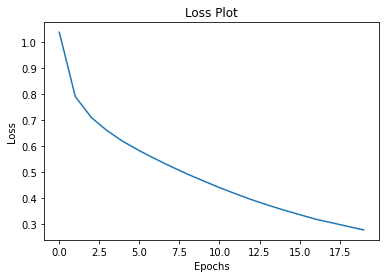

In [43]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [44]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [45]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [46]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Prediction Caption: two <unk> on guns controllers as she playing <unk> stand in a an office <end>


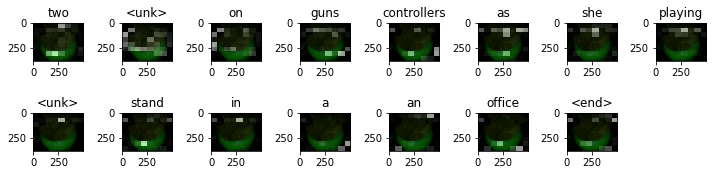

In [52]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i]
                        # for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate('/content/gdrive/MyDrive/all_shooting_images_newest/' + str(ImageID[1200]) + '.jpg')

# print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [54]:
ImageID[1200]

124

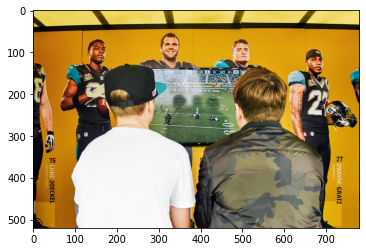

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('/content/gdrive/MyDrive/all_shooting_images_newest/' + str(ImageID[1200]) + '.jpg'))

In [49]:
image

'/content/train2014/COCO_train2014_000000169456.jpg'

## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


65536/64400 [==============================] - 0s 1us/step
Prediction Caption: a man in the waves in the ocean <end>


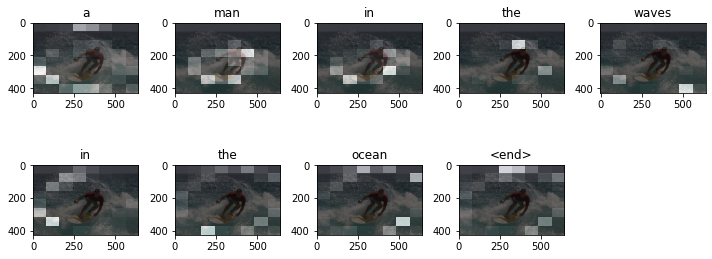

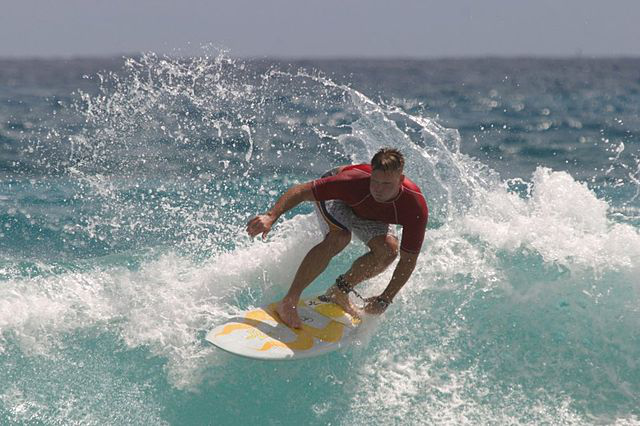

In [50]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.